In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
from torch.autograd import Variable
from copy import deepcopy
from tqdm import tqdm


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [ ]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')
    plt.show()

In [ ]:
#@title Experiment Constants
epochs = 2
epochs = 150
lr = 1e-4
batch_size = 128
sample_size = 200
hidden_size = 512
num_task = 3 # Number of tasks, task 1 we would not have any permutation
batch_size = 128

In [ ]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        if self.train:
          # print("data", type(self.train_data),type(self.train_data[0]),self.train_data.shape, self.train_data[0].shape, self.train_data[0])
          self.training_data= torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.train_data])
          self.training_labels = self.train_labels
        else:
          self.testing_data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.test_data])
          self.testing_labels = self.test_labels

    def __getitem__(self, index):

        if self.train:
            img, target = self.training_data[index], self.training_labels[index]
        else:
            img, target = self.testing_data[index], self.testing_labels[index]

        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.training_data[sample_idx]]

In [ ]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28)) # first time there is no shuffle
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        print(f'Index for  task {i} \n {idx}')
        idx = random.sample(idx, len(idx))
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2127659.28it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 492161.43it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 911860.30it/s] 


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2496792.76it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Index for  task 0 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,

 ------task 0 --------
torch.Size([784])
label :  4


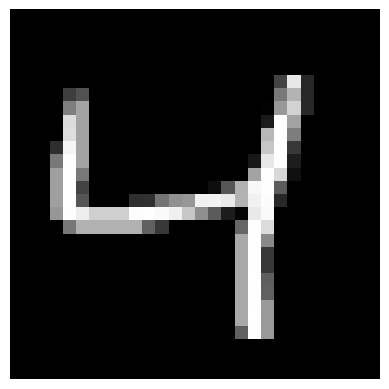

 ------task 1 --------
torch.Size([784])
label :  4


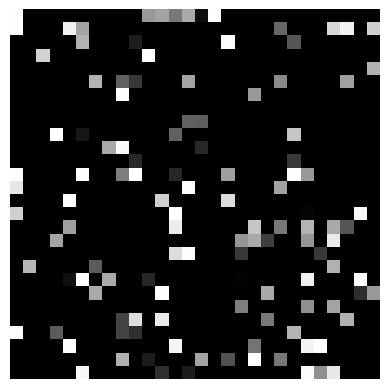

 ------task 2 --------
torch.Size([784])
label :  4


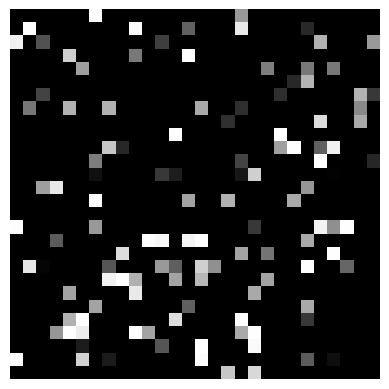

In [ ]:

t = 0
for i in range(num_task):
  print(f' ------task {i} --------')
  batch = next(iter(train_loader[i]))
  if t == 0:
    t = random.randint(1,len(batch))
  image, label = batch[0][t], batch[1][t]
  print (batch[0][t].shape)
  print("label : ", label.item())
  mnist_imshow(image)

In [ ]:

class MLP(nn.Module):
    def __init__(self, hidden_size=200):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

model = MLP().to(device)
summary(model, input_size=(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 200]         157,000
            Linear-2               [-1, 1, 200]          40,200
            Linear-3               [-1, 1, 200]          40,200
            Linear-4                [-1, 1, 10]           2,010
Total params: 239,410
Trainable params: 239,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


In [ ]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
  """
  Takes in a tensor and converts into a tensor with gradient
  We would need gradients of parameters, hence needed
  """
  if torch.cuda.is_available() and use_cuda:
    t = t.cuda()
  return Variable(t, **kwargs)

In [ ]:
def normal_train(model: nn.Module,
                 optimizer: torch.optim,
                 data_loader: torch.utils.data.DataLoader):
  """
  Takes in a model architecture, trains its and returns average epoch loss
  """
  model.train()
  epoch_loss = 0
  for input, target in data_loader:
      input, target = variable(input), variable(target)
      optimizer.zero_grad()
      output = model(input)
      loss = F.cross_entropy(output, target)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
  return epoch_loss / len(data_loader)

In [ ]:
def test(model: nn.Module,
         data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)

In [ ]:
class EWC(object):
    def __init__(self,
                 model: nn.Module,
                 dataset: list):

        self.model = model
        self.dataset = dataset

        # default model params
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval() # we need to do one round of back propogation to understand the gradients of params
        # interestingly we dont have to always use model.train() to get the gradients
        for input in self.dataset:
            self.model.zero_grad()
            input = variable(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

In [ ]:
def ewc_train(model: nn.Module,
              optimizer: torch.optim,
              data_loader: torch.utils.data.DataLoader,
              ewc: EWC,
              importance: float): # importance is a hyperparam
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        ##-------Updated Loss Function-------###
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

In [ ]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v, label = "Task "+ str(t))
    plt.legend(loc = 'upper right')
    plt.title("Loss Plot")
    plt.show()

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v, label = "Task "+  str(t))
    plt.ylim(0, 1)
    plt.legend(loc = 'upper right')
    plt.title("Accuracy Plot")
    plt.show()

In [ ]:

def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc = {}, {} # across tasks
    for task in range(num_task):
        loss[task] = [] # per task loss
        acc[task] = [] # per task accuracy
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight

In [ ]:
#@title Training and Output of Standard Process
loss, acc, weight = standard_process(epochs) # The weights are used by EWC process

100%|██████████| 150/150 [27:06<00:00, 10.84s/it]


In [ ]:
for task in range(3):
    final_loss = loss[task][-1]  # Get the last loss value for the task
    final_acc = acc[task][-1]    # Get the last accuracy value for the task
    print(f"Task {task}: Final Loss = {final_loss:.4f}, Final Accuracy = {final_acc:.2f}%")

Task 0: Final Loss = 2.1677, Final Accuracy = 0.39%
Task 1: Final Loss = 1.5974, Final Accuracy = 0.57%
Task 2: Final Loss = 1.2301, Final Accuracy = 0.62%


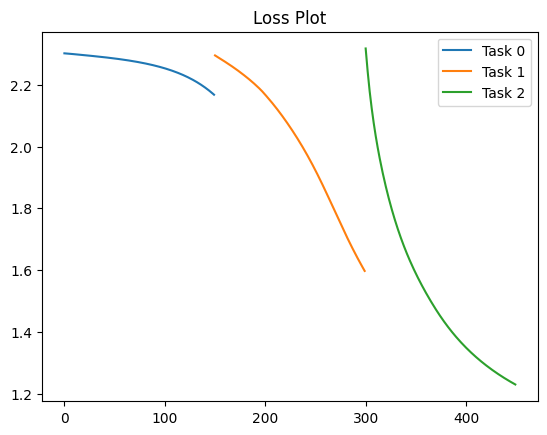

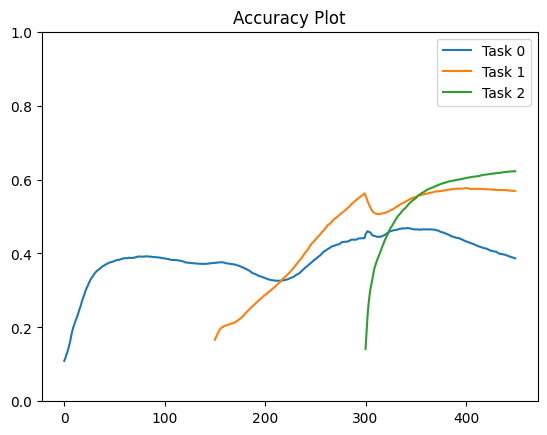

(None, None)

In [ ]:
loss_plot(loss), accuracy_plot(acc)

In [ ]:
(weight)

OrderedDict([('fc1.weight',
              tensor([[ 0.0023, -0.0098,  0.0082,  ...,  0.0337,  0.0416, -0.0084],
                      [-0.0289,  0.0220,  0.0111,  ...,  0.0318, -0.0003,  0.0122],
                      [-0.0253, -0.0336,  0.0124,  ..., -0.0219, -0.0332,  0.0066],
                      ...,
                      [-0.0029, -0.0226, -0.0348,  ...,  0.0143,  0.0071,  0.0273],
                      [ 0.0053,  0.0247, -0.0132,  ...,  0.0248, -0.0272,  0.0066],
                      [-0.0165,  0.0005,  0.0174,  ...,  0.0147,  0.0370,  0.0204]])),
             ('fc1.bias',
              tensor([ 5.1451e-02,  2.4935e-02,  3.2465e-02,  1.0990e-02,  3.5137e-02,
                       3.7663e-02, -1.5025e-02,  2.1256e-02,  3.3771e-02,  4.1000e-03,
                      -2.4524e-02,  3.4888e-02, -1.2528e-02,  2.9730e-03,  7.3531e-03,
                       3.7193e-02,  2.6412e-02, -2.1080e-02,  1.3652e-02,  5.8633e-03,
                       3.0123e-02,  2.3461e-02,  3.5007e-03, -1.

In [ ]:
def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, penalties = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        penalties[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for epoch in tqdm(range(epochs)):
                    epoch_loss = normal_train(model, optimizer, train_loader[task])
                    loss[task].append(epoch_loss)
                    acc[task].append(test(model, test_loader[task]))

                    # Print loss and accuracy for the current epoch
                    print(f"Epoch {epoch+1}/{epochs} | Task {task} | Loss: {epoch_loss:.4f} | Accuracy: {acc[task][-1]:.4f}")

        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for epoch in tqdm(range(epochs)):
                epoch_loss = ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance)
                loss[task].append(epoch_loss)
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader[sub_task]))

                    # Print loss and accuracy for the current epoch
                    print(f"Epoch {epoch+1}/{epochs} | Task {task} | Loss: {epoch_loss:.4f} | Accuracy: {acc[sub_task][-1]:.4f}")

        # Print final loss and accuracy for the task
        print(f'Final Loss and Accuracy after training on Task {task}:')
        for sub_task in range(task + 1):
            print(f'Task {sub_task} | Loss: {loss[sub_task][-1]:.4f} | Accuracy: {acc[sub_task][-1]:.4f}')
        print('-' * 50)

    return loss, acc, penalties

In [ ]:
# Running the EWC process and printing loss and accuracy
loss_ewc, acc_ewc, penalties = ewc_process(epochs, importance=5000)

  1%|          | 1/150 [00:10<25:57, 10.46s/it]

Epoch 1/150 | Task 0 | Loss: 2.3026 | Accuracy: 0.1020


  1%|▏         | 2/150 [00:19<23:35,  9.56s/it]

Epoch 2/150 | Task 0 | Loss: 2.3023 | Accuracy: 0.1078


  2%|▏         | 3/150 [00:29<24:02,  9.81s/it]

Epoch 3/150 | Task 0 | Loss: 2.3020 | Accuracy: 0.1140


  3%|▎         | 4/150 [00:39<24:10,  9.93s/it]

Epoch 4/150 | Task 0 | Loss: 2.3016 | Accuracy: 0.1208


  3%|▎         | 5/150 [00:49<23:34,  9.76s/it]

Epoch 5/150 | Task 0 | Loss: 2.3013 | Accuracy: 0.1288


  4%|▍         | 6/150 [00:58<23:08,  9.64s/it]

Epoch 6/150 | Task 0 | Loss: 2.3010 | Accuracy: 0.1357


  5%|▍         | 7/150 [01:08<23:19,  9.79s/it]

Epoch 7/150 | Task 0 | Loss: 2.3007 | Accuracy: 0.1424


  5%|▌         | 8/150 [01:18<23:19,  9.85s/it]

Epoch 8/150 | Task 0 | Loss: 2.3004 | Accuracy: 0.1482


  6%|▌         | 9/150 [01:27<22:22,  9.52s/it]

Epoch 9/150 | Task 0 | Loss: 2.3001 | Accuracy: 0.1533


  7%|▋         | 10/150 [01:37<22:32,  9.66s/it]

Epoch 10/150 | Task 0 | Loss: 2.2998 | Accuracy: 0.1581


  7%|▋         | 11/150 [01:47<22:34,  9.75s/it]

Epoch 11/150 | Task 0 | Loss: 2.2995 | Accuracy: 0.1635


  8%|▊         | 12/150 [01:57<22:26,  9.76s/it]

Epoch 12/150 | Task 0 | Loss: 2.2992 | Accuracy: 0.1668


  9%|▊         | 13/150 [02:05<21:34,  9.45s/it]

Epoch 13/150 | Task 0 | Loss: 2.2989 | Accuracy: 0.1696


  9%|▉         | 14/150 [02:15<21:55,  9.67s/it]

Epoch 14/150 | Task 0 | Loss: 2.2986 | Accuracy: 0.1731


 10%|█         | 15/150 [02:26<22:03,  9.80s/it]

Epoch 15/150 | Task 0 | Loss: 2.2983 | Accuracy: 0.1765


 11%|█         | 16/150 [02:35<21:35,  9.67s/it]

Epoch 16/150 | Task 0 | Loss: 2.2980 | Accuracy: 0.1782


 11%|█▏        | 17/150 [02:44<21:16,  9.60s/it]

Epoch 17/150 | Task 0 | Loss: 2.2977 | Accuracy: 0.1811


 12%|█▏        | 18/150 [02:54<21:20,  9.70s/it]

Epoch 18/150 | Task 0 | Loss: 2.2974 | Accuracy: 0.1825


 13%|█▎        | 19/150 [03:04<21:26,  9.82s/it]

Epoch 19/150 | Task 0 | Loss: 2.2971 | Accuracy: 0.1847


 13%|█▎        | 20/150 [03:13<20:39,  9.54s/it]

Epoch 20/150 | Task 0 | Loss: 2.2968 | Accuracy: 0.1882


 14%|█▍        | 21/150 [03:23<20:46,  9.66s/it]

Epoch 21/150 | Task 0 | Loss: 2.2965 | Accuracy: 0.1915


 15%|█▍        | 22/150 [03:33<20:53,  9.79s/it]

Epoch 22/150 | Task 0 | Loss: 2.2962 | Accuracy: 0.1940


 15%|█▌        | 23/150 [03:43<20:44,  9.80s/it]

Epoch 23/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.1983


 16%|█▌        | 24/150 [03:52<19:59,  9.52s/it]

Epoch 24/150 | Task 0 | Loss: 2.2956 | Accuracy: 0.2016


 17%|█▋        | 25/150 [04:02<20:13,  9.71s/it]

Epoch 25/150 | Task 0 | Loss: 2.2953 | Accuracy: 0.2047


 17%|█▋        | 26/150 [04:12<20:14,  9.79s/it]

Epoch 26/150 | Task 0 | Loss: 2.2950 | Accuracy: 0.2076


 18%|█▊        | 27/150 [04:21<19:43,  9.62s/it]

Epoch 27/150 | Task 0 | Loss: 2.2947 | Accuracy: 0.2110


 19%|█▊        | 28/150 [04:31<19:34,  9.62s/it]

Epoch 28/150 | Task 0 | Loss: 2.2944 | Accuracy: 0.2149


 19%|█▉        | 29/150 [04:41<19:38,  9.74s/it]

Epoch 29/150 | Task 0 | Loss: 2.2941 | Accuracy: 0.2197


 20%|██        | 30/150 [04:51<19:32,  9.77s/it]

Epoch 30/150 | Task 0 | Loss: 2.2938 | Accuracy: 0.2242


 21%|██        | 31/150 [05:00<18:51,  9.51s/it]

Epoch 31/150 | Task 0 | Loss: 2.2934 | Accuracy: 0.2282


 21%|██▏       | 32/150 [05:10<19:01,  9.67s/it]

Epoch 32/150 | Task 0 | Loss: 2.2931 | Accuracy: 0.2334


 22%|██▏       | 33/150 [05:20<19:04,  9.78s/it]

Epoch 33/150 | Task 0 | Loss: 2.2928 | Accuracy: 0.2378


 23%|██▎       | 34/150 [05:30<19:01,  9.84s/it]

Epoch 34/150 | Task 0 | Loss: 2.2925 | Accuracy: 0.2422


 23%|██▎       | 35/150 [05:39<18:18,  9.55s/it]

Epoch 35/150 | Task 0 | Loss: 2.2921 | Accuracy: 0.2467


 24%|██▍       | 36/150 [05:49<18:18,  9.63s/it]

Epoch 36/150 | Task 0 | Loss: 2.2918 | Accuracy: 0.2525


 25%|██▍       | 37/150 [05:58<18:19,  9.73s/it]

Epoch 37/150 | Task 0 | Loss: 2.2915 | Accuracy: 0.2573


 25%|██▌       | 38/150 [06:07<17:43,  9.50s/it]

Epoch 38/150 | Task 0 | Loss: 2.2911 | Accuracy: 0.2622


 26%|██▌       | 39/150 [06:17<17:41,  9.56s/it]

Epoch 39/150 | Task 0 | Loss: 2.2908 | Accuracy: 0.2689


 27%|██▋       | 40/150 [06:27<17:44,  9.68s/it]

Epoch 40/150 | Task 0 | Loss: 2.2905 | Accuracy: 0.2744


 27%|██▋       | 41/150 [06:37<17:40,  9.73s/it]

Epoch 41/150 | Task 0 | Loss: 2.2901 | Accuracy: 0.2803


 28%|██▊       | 42/150 [06:46<16:55,  9.41s/it]

Epoch 42/150 | Task 0 | Loss: 2.2897 | Accuracy: 0.2865


 29%|██▊       | 43/150 [06:56<17:02,  9.56s/it]

Epoch 43/150 | Task 0 | Loss: 2.2894 | Accuracy: 0.2924


 29%|██▉       | 44/150 [07:06<17:12,  9.74s/it]

Epoch 44/150 | Task 0 | Loss: 2.2890 | Accuracy: 0.2980


 30%|███       | 45/150 [07:15<16:56,  9.68s/it]

Epoch 45/150 | Task 0 | Loss: 2.2887 | Accuracy: 0.3042


 31%|███       | 46/150 [07:25<16:37,  9.59s/it]

Epoch 46/150 | Task 0 | Loss: 2.2883 | Accuracy: 0.3092


 31%|███▏      | 47/150 [07:35<16:45,  9.76s/it]

Epoch 47/150 | Task 0 | Loss: 2.2879 | Accuracy: 0.3137


 32%|███▏      | 48/150 [07:45<16:44,  9.85s/it]

Epoch 48/150 | Task 0 | Loss: 2.2875 | Accuracy: 0.3188


 33%|███▎      | 49/150 [07:54<16:06,  9.57s/it]

Epoch 49/150 | Task 0 | Loss: 2.2872 | Accuracy: 0.3238


 33%|███▎      | 50/150 [08:04<16:10,  9.71s/it]

Epoch 50/150 | Task 0 | Loss: 2.2868 | Accuracy: 0.3287


 34%|███▍      | 51/150 [08:14<16:08,  9.79s/it]

Epoch 51/150 | Task 0 | Loss: 2.2864 | Accuracy: 0.3332


 35%|███▍      | 52/150 [08:23<15:56,  9.76s/it]

Epoch 52/150 | Task 0 | Loss: 2.2860 | Accuracy: 0.3383


 35%|███▌      | 53/150 [08:32<15:19,  9.48s/it]

Epoch 53/150 | Task 0 | Loss: 2.2856 | Accuracy: 0.3438


 36%|███▌      | 54/150 [08:42<15:22,  9.61s/it]

Epoch 54/150 | Task 0 | Loss: 2.2852 | Accuracy: 0.3485


 37%|███▋      | 55/150 [08:52<15:18,  9.67s/it]

Epoch 55/150 | Task 0 | Loss: 2.2848 | Accuracy: 0.3526


 37%|███▋      | 56/150 [09:01<15:02,  9.60s/it]

Epoch 56/150 | Task 0 | Loss: 2.2843 | Accuracy: 0.3573


 38%|███▊      | 57/150 [09:11<14:49,  9.56s/it]

Epoch 57/150 | Task 0 | Loss: 2.2839 | Accuracy: 0.3611


 39%|███▊      | 58/150 [09:21<14:50,  9.68s/it]

Epoch 58/150 | Task 0 | Loss: 2.2835 | Accuracy: 0.3650


 39%|███▉      | 59/150 [09:31<14:51,  9.80s/it]

Epoch 59/150 | Task 0 | Loss: 2.2830 | Accuracy: 0.3680


 40%|████      | 60/150 [09:40<14:12,  9.47s/it]

Epoch 60/150 | Task 0 | Loss: 2.2826 | Accuracy: 0.3732


 41%|████      | 61/150 [09:50<14:17,  9.63s/it]

Epoch 61/150 | Task 0 | Loss: 2.2821 | Accuracy: 0.3778


 41%|████▏     | 62/150 [10:00<14:17,  9.74s/it]

Epoch 62/150 | Task 0 | Loss: 2.2817 | Accuracy: 0.3828


 42%|████▏     | 63/150 [10:09<14:08,  9.75s/it]

Epoch 63/150 | Task 0 | Loss: 2.2812 | Accuracy: 0.3862


 43%|████▎     | 64/150 [10:18<13:34,  9.47s/it]

Epoch 64/150 | Task 0 | Loss: 2.2808 | Accuracy: 0.3893


 43%|████▎     | 65/150 [10:28<13:34,  9.59s/it]

Epoch 65/150 | Task 0 | Loss: 2.2803 | Accuracy: 0.3924


 44%|████▍     | 66/150 [10:38<13:37,  9.73s/it]

Epoch 66/150 | Task 0 | Loss: 2.2798 | Accuracy: 0.3956


 45%|████▍     | 67/150 [10:47<13:14,  9.57s/it]

Epoch 67/150 | Task 0 | Loss: 2.2793 | Accuracy: 0.3994


 45%|████▌     | 68/150 [10:57<13:08,  9.61s/it]

Epoch 68/150 | Task 0 | Loss: 2.2788 | Accuracy: 0.4018


 46%|████▌     | 69/150 [11:07<13:11,  9.77s/it]

Epoch 69/150 | Task 0 | Loss: 2.2783 | Accuracy: 0.4053


 47%|████▋     | 70/150 [11:17<13:07,  9.84s/it]

Epoch 70/150 | Task 0 | Loss: 2.2778 | Accuracy: 0.4076


 47%|████▋     | 71/150 [11:26<12:32,  9.52s/it]

Epoch 71/150 | Task 0 | Loss: 2.2773 | Accuracy: 0.4110


 48%|████▊     | 72/150 [11:36<12:35,  9.69s/it]

Epoch 72/150 | Task 0 | Loss: 2.2767 | Accuracy: 0.4132


 49%|████▊     | 73/150 [11:46<12:31,  9.75s/it]

Epoch 73/150 | Task 0 | Loss: 2.2762 | Accuracy: 0.4156


 49%|████▉     | 74/150 [11:56<12:20,  9.75s/it]

Epoch 74/150 | Task 0 | Loss: 2.2756 | Accuracy: 0.4171


 50%|█████     | 75/150 [12:05<11:51,  9.49s/it]

Epoch 75/150 | Task 0 | Loss: 2.2751 | Accuracy: 0.4193


 51%|█████     | 76/150 [12:14<11:49,  9.59s/it]

Epoch 76/150 | Task 0 | Loss: 2.2745 | Accuracy: 0.4214


 51%|█████▏    | 77/150 [12:24<11:48,  9.70s/it]

Epoch 77/150 | Task 0 | Loss: 2.2739 | Accuracy: 0.4228


 52%|█████▏    | 78/150 [12:34<11:31,  9.60s/it]

Epoch 78/150 | Task 0 | Loss: 2.2733 | Accuracy: 0.4242


 53%|█████▎    | 79/150 [12:43<11:18,  9.56s/it]

Epoch 79/150 | Task 0 | Loss: 2.2727 | Accuracy: 0.4263


 53%|█████▎    | 80/150 [12:53<11:17,  9.68s/it]

Epoch 80/150 | Task 0 | Loss: 2.2721 | Accuracy: 0.4276


 54%|█████▍    | 81/150 [13:03<11:17,  9.82s/it]

Epoch 81/150 | Task 0 | Loss: 2.2715 | Accuracy: 0.4297


 55%|█████▍    | 82/150 [13:12<10:47,  9.52s/it]

Epoch 82/150 | Task 0 | Loss: 2.2709 | Accuracy: 0.4317


 55%|█████▌    | 83/150 [13:22<10:46,  9.66s/it]

Epoch 83/150 | Task 0 | Loss: 2.2702 | Accuracy: 0.4333


 56%|█████▌    | 84/150 [13:32<10:46,  9.79s/it]

Epoch 84/150 | Task 0 | Loss: 2.2696 | Accuracy: 0.4353


 57%|█████▋    | 85/150 [13:42<10:30,  9.71s/it]

Epoch 85/150 | Task 0 | Loss: 2.2689 | Accuracy: 0.4361


 57%|█████▋    | 86/150 [13:51<10:10,  9.54s/it]

Epoch 86/150 | Task 0 | Loss: 2.2682 | Accuracy: 0.4376


 58%|█████▊    | 87/150 [14:01<10:12,  9.72s/it]

Epoch 87/150 | Task 0 | Loss: 2.2675 | Accuracy: 0.4387


 59%|█████▊    | 88/150 [14:11<10:13,  9.89s/it]

Epoch 88/150 | Task 0 | Loss: 2.2668 | Accuracy: 0.4398


 59%|█████▉    | 89/150 [14:21<09:57,  9.79s/it]

Epoch 89/150 | Task 0 | Loss: 2.2661 | Accuracy: 0.4405


 60%|██████    | 90/150 [14:30<09:43,  9.72s/it]

Epoch 90/150 | Task 0 | Loss: 2.2653 | Accuracy: 0.4415


 61%|██████    | 91/150 [14:41<09:42,  9.88s/it]

Epoch 91/150 | Task 0 | Loss: 2.2646 | Accuracy: 0.4430


 61%|██████▏   | 92/150 [14:51<09:35,  9.92s/it]

Epoch 92/150 | Task 0 | Loss: 2.2638 | Accuracy: 0.4446


 62%|██████▏   | 93/150 [14:59<09:05,  9.56s/it]

Epoch 93/150 | Task 0 | Loss: 2.2630 | Accuracy: 0.4458


 63%|██████▎   | 94/150 [15:10<09:07,  9.78s/it]

Epoch 94/150 | Task 0 | Loss: 2.2622 | Accuracy: 0.4466


 63%|██████▎   | 95/150 [15:20<09:01,  9.84s/it]

Epoch 95/150 | Task 0 | Loss: 2.2614 | Accuracy: 0.4471


 64%|██████▍   | 96/150 [15:30<08:51,  9.85s/it]

Epoch 96/150 | Task 0 | Loss: 2.2606 | Accuracy: 0.4476


 65%|██████▍   | 97/150 [15:38<08:26,  9.56s/it]

Epoch 97/150 | Task 0 | Loss: 2.2597 | Accuracy: 0.4487


 65%|██████▌   | 98/150 [15:49<08:26,  9.74s/it]

Epoch 98/150 | Task 0 | Loss: 2.2589 | Accuracy: 0.4492


 66%|██████▌   | 99/150 [15:59<08:19,  9.80s/it]

Epoch 99/150 | Task 0 | Loss: 2.2580 | Accuracy: 0.4493


 67%|██████▋   | 100/150 [16:08<08:11,  9.82s/it]

Epoch 100/150 | Task 0 | Loss: 2.2571 | Accuracy: 0.4494


 67%|██████▋   | 101/150 [16:18<07:54,  9.69s/it]

Epoch 101/150 | Task 0 | Loss: 2.2561 | Accuracy: 0.4501


 68%|██████▊   | 102/150 [16:28<07:50,  9.79s/it]

Epoch 102/150 | Task 0 | Loss: 2.2552 | Accuracy: 0.4504


 69%|██████▊   | 103/150 [16:38<07:44,  9.89s/it]

Epoch 103/150 | Task 0 | Loss: 2.2542 | Accuracy: 0.4506


 69%|██████▉   | 104/150 [16:47<07:21,  9.60s/it]

Epoch 104/150 | Task 0 | Loss: 2.2533 | Accuracy: 0.4505


 70%|███████   | 105/150 [16:57<07:17,  9.72s/it]

Epoch 105/150 | Task 0 | Loss: 2.2522 | Accuracy: 0.4505


 71%|███████   | 106/150 [17:07<07:15,  9.90s/it]

Epoch 106/150 | Task 0 | Loss: 2.2512 | Accuracy: 0.4503


 71%|███████▏  | 107/150 [17:17<07:08,  9.96s/it]

Epoch 107/150 | Task 0 | Loss: 2.2502 | Accuracy: 0.4499


 72%|███████▏  | 108/150 [17:26<06:43,  9.62s/it]

Epoch 108/150 | Task 0 | Loss: 2.2491 | Accuracy: 0.4505


 73%|███████▎  | 109/150 [17:36<06:41,  9.80s/it]

Epoch 109/150 | Task 0 | Loss: 2.2480 | Accuracy: 0.4508


 73%|███████▎  | 110/150 [17:46<06:33,  9.85s/it]

Epoch 110/150 | Task 0 | Loss: 2.2469 | Accuracy: 0.4511


 74%|███████▍  | 111/150 [17:56<06:21,  9.79s/it]

Epoch 111/150 | Task 0 | Loss: 2.2457 | Accuracy: 0.4512


 75%|███████▍  | 112/150 [18:05<06:05,  9.61s/it]

Epoch 112/150 | Task 0 | Loss: 2.2445 | Accuracy: 0.4506


 75%|███████▌  | 113/150 [18:15<05:59,  9.73s/it]

Epoch 113/150 | Task 0 | Loss: 2.2433 | Accuracy: 0.4503


 76%|███████▌  | 114/150 [18:25<05:52,  9.79s/it]

Epoch 114/150 | Task 0 | Loss: 2.2421 | Accuracy: 0.4499


 77%|███████▋  | 115/150 [18:34<05:33,  9.53s/it]

Epoch 115/150 | Task 0 | Loss: 2.2409 | Accuracy: 0.4495


 77%|███████▋  | 116/150 [18:44<05:26,  9.59s/it]

Epoch 116/150 | Task 0 | Loss: 2.2396 | Accuracy: 0.4489


 78%|███████▊  | 117/150 [18:54<05:20,  9.70s/it]

Epoch 117/150 | Task 0 | Loss: 2.2383 | Accuracy: 0.4481


 79%|███████▊  | 118/150 [19:04<05:12,  9.78s/it]

Epoch 118/150 | Task 0 | Loss: 2.2369 | Accuracy: 0.4478


 79%|███████▉  | 119/150 [19:13<04:56,  9.57s/it]

Epoch 119/150 | Task 0 | Loss: 2.2355 | Accuracy: 0.4475


 80%|████████  | 120/150 [19:23<04:50,  9.69s/it]

Epoch 120/150 | Task 0 | Loss: 2.2341 | Accuracy: 0.4468


 81%|████████  | 121/150 [19:33<04:44,  9.81s/it]

Epoch 121/150 | Task 0 | Loss: 2.2327 | Accuracy: 0.4461


 81%|████████▏ | 122/150 [19:45<04:54, 10.52s/it]

Epoch 122/150 | Task 0 | Loss: 2.2312 | Accuracy: 0.4454


 82%|████████▏ | 123/150 [19:54<04:31, 10.07s/it]

Epoch 123/150 | Task 0 | Loss: 2.2297 | Accuracy: 0.4447


 83%|████████▎ | 124/150 [20:04<04:18,  9.96s/it]

Epoch 124/150 | Task 0 | Loss: 2.2281 | Accuracy: 0.4439


 83%|████████▎ | 125/150 [20:14<04:09,  9.97s/it]

Epoch 125/150 | Task 0 | Loss: 2.2265 | Accuracy: 0.4429


 84%|████████▍ | 126/150 [20:24<03:58,  9.94s/it]

Epoch 126/150 | Task 0 | Loss: 2.2249 | Accuracy: 0.4423


 85%|████████▍ | 127/150 [20:32<03:40,  9.59s/it]

Epoch 127/150 | Task 0 | Loss: 2.2232 | Accuracy: 0.4414


 85%|████████▌ | 128/150 [20:42<03:34,  9.75s/it]

Epoch 128/150 | Task 0 | Loss: 2.2215 | Accuracy: 0.4405


 86%|████████▌ | 129/150 [20:52<03:26,  9.82s/it]

Epoch 129/150 | Task 0 | Loss: 2.2198 | Accuracy: 0.4397


 87%|████████▋ | 130/150 [21:02<03:15,  9.75s/it]

Epoch 130/150 | Task 0 | Loss: 2.2180 | Accuracy: 0.4392


 87%|████████▋ | 131/150 [21:11<03:03,  9.67s/it]

Epoch 131/150 | Task 0 | Loss: 2.2161 | Accuracy: 0.4387


 88%|████████▊ | 132/150 [21:22<02:56,  9.78s/it]

Epoch 132/150 | Task 0 | Loss: 2.2142 | Accuracy: 0.4381


 89%|████████▊ | 133/150 [21:32<02:49,  9.95s/it]

Epoch 133/150 | Task 0 | Loss: 2.2123 | Accuracy: 0.4376


 89%|████████▉ | 134/150 [21:42<02:38,  9.89s/it]

Epoch 134/150 | Task 0 | Loss: 2.2103 | Accuracy: 0.4376


 90%|█████████ | 135/150 [21:51<02:28,  9.88s/it]

Epoch 135/150 | Task 0 | Loss: 2.2083 | Accuracy: 0.4370


 91%|█████████ | 136/150 [22:02<02:19,  9.97s/it]

Epoch 136/150 | Task 0 | Loss: 2.2062 | Accuracy: 0.4367


 91%|█████████▏| 137/150 [22:12<02:10, 10.06s/it]

Epoch 137/150 | Task 0 | Loss: 2.2041 | Accuracy: 0.4357


 92%|█████████▏| 138/150 [22:21<01:56,  9.72s/it]

Epoch 138/150 | Task 0 | Loss: 2.2019 | Accuracy: 0.4353


 93%|█████████▎| 139/150 [22:31<01:47,  9.79s/it]

Epoch 139/150 | Task 0 | Loss: 2.1997 | Accuracy: 0.4349


 93%|█████████▎| 140/150 [22:41<01:39,  9.97s/it]

Epoch 140/150 | Task 0 | Loss: 2.1974 | Accuracy: 0.4342


 94%|█████████▍| 141/150 [22:51<01:29,  9.98s/it]

Epoch 141/150 | Task 0 | Loss: 2.1950 | Accuracy: 0.4337


 95%|█████████▍| 142/150 [23:00<01:17,  9.68s/it]

Epoch 142/150 | Task 0 | Loss: 2.1926 | Accuracy: 0.4330


 95%|█████████▌| 143/150 [23:10<01:08,  9.85s/it]

Epoch 143/150 | Task 0 | Loss: 2.1902 | Accuracy: 0.4323


 96%|█████████▌| 144/150 [23:21<00:59,  9.93s/it]

Epoch 144/150 | Task 0 | Loss: 2.1876 | Accuracy: 0.4320


 97%|█████████▋| 145/150 [23:30<00:49,  9.92s/it]

Epoch 145/150 | Task 0 | Loss: 2.1850 | Accuracy: 0.4318


 97%|█████████▋| 146/150 [23:39<00:38,  9.65s/it]

Epoch 146/150 | Task 0 | Loss: 2.1824 | Accuracy: 0.4313


 98%|█████████▊| 147/150 [23:49<00:29,  9.76s/it]

Epoch 147/150 | Task 0 | Loss: 2.1797 | Accuracy: 0.4309


 99%|█████████▊| 148/150 [24:00<00:19,  9.86s/it]

Epoch 148/150 | Task 0 | Loss: 2.1769 | Accuracy: 0.4303


 99%|█████████▉| 149/150 [24:09<00:09,  9.71s/it]

Epoch 149/150 | Task 0 | Loss: 2.1740 | Accuracy: 0.4302


100%|██████████| 150/150 [24:18<00:00,  9.73s/it]


Epoch 150/150 | Task 0 | Loss: 2.1711 | Accuracy: 0.4294
Final Loss and Accuracy after training on Task 0:
Task 0 | Loss: 2.1711 | Accuracy: 0.4294
--------------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150 | Task 1 | Loss: 2.3012 | Accuracy: 0.4285


  1%|          | 1/150 [00:14<36:47, 14.81s/it]

Epoch 1/150 | Task 1 | Loss: 2.3012 | Accuracy: 0.1088
Epoch 2/150 | Task 1 | Loss: 2.2997 | Accuracy: 0.4278


  1%|▏         | 2/150 [00:29<37:03, 15.03s/it]

Epoch 2/150 | Task 1 | Loss: 2.2997 | Accuracy: 0.1148
Epoch 3/150 | Task 1 | Loss: 2.2982 | Accuracy: 0.4275


  2%|▏         | 3/150 [00:45<37:13, 15.19s/it]

Epoch 3/150 | Task 1 | Loss: 2.2982 | Accuracy: 0.1187
Epoch 4/150 | Task 1 | Loss: 2.2966 | Accuracy: 0.4264


  3%|▎         | 4/150 [01:01<37:48, 15.54s/it]

Epoch 4/150 | Task 1 | Loss: 2.2966 | Accuracy: 0.1222
Epoch 5/150 | Task 1 | Loss: 2.2951 | Accuracy: 0.4252


  3%|▎         | 5/150 [01:16<36:54, 15.27s/it]

Epoch 5/150 | Task 1 | Loss: 2.2951 | Accuracy: 0.1253
Epoch 6/150 | Task 1 | Loss: 2.2935 | Accuracy: 0.4245


  4%|▍         | 6/150 [01:31<36:13, 15.10s/it]

Epoch 6/150 | Task 1 | Loss: 2.2935 | Accuracy: 0.1278
Epoch 7/150 | Task 1 | Loss: 2.2919 | Accuracy: 0.4237


  5%|▍         | 7/150 [01:45<35:38, 14.95s/it]

Epoch 7/150 | Task 1 | Loss: 2.2919 | Accuracy: 0.1294
Epoch 8/150 | Task 1 | Loss: 2.2903 | Accuracy: 0.4227


  5%|▌         | 8/150 [02:00<35:23, 14.95s/it]

Epoch 8/150 | Task 1 | Loss: 2.2903 | Accuracy: 0.1308
Epoch 9/150 | Task 1 | Loss: 2.2886 | Accuracy: 0.4215


  6%|▌         | 9/150 [02:15<34:58, 14.89s/it]

Epoch 9/150 | Task 1 | Loss: 2.2886 | Accuracy: 0.1325
Epoch 10/150 | Task 1 | Loss: 2.2870 | Accuracy: 0.4200


  7%|▋         | 10/150 [02:30<35:09, 15.07s/it]

Epoch 10/150 | Task 1 | Loss: 2.2870 | Accuracy: 0.1334
Epoch 11/150 | Task 1 | Loss: 2.2853 | Accuracy: 0.4182


  7%|▋         | 11/150 [02:46<35:20, 15.25s/it]

Epoch 11/150 | Task 1 | Loss: 2.2853 | Accuracy: 0.1346
Epoch 12/150 | Task 1 | Loss: 2.2836 | Accuracy: 0.4161


  8%|▊         | 12/150 [03:01<35:10, 15.29s/it]

Epoch 12/150 | Task 1 | Loss: 2.2836 | Accuracy: 0.1355
Epoch 13/150 | Task 1 | Loss: 2.2820 | Accuracy: 0.4135


  9%|▊         | 13/150 [03:17<34:48, 15.24s/it]

Epoch 13/150 | Task 1 | Loss: 2.2820 | Accuracy: 0.1370
Epoch 14/150 | Task 1 | Loss: 2.2803 | Accuracy: 0.4112


  9%|▉         | 14/150 [03:32<34:35, 15.26s/it]

Epoch 14/150 | Task 1 | Loss: 2.2803 | Accuracy: 0.1383
Epoch 15/150 | Task 1 | Loss: 2.2786 | Accuracy: 0.4091


 10%|█         | 15/150 [03:47<34:07, 15.17s/it]

Epoch 15/150 | Task 1 | Loss: 2.2786 | Accuracy: 0.1394
Epoch 16/150 | Task 1 | Loss: 2.2769 | Accuracy: 0.4073


 11%|█         | 16/150 [04:02<33:52, 15.17s/it]

Epoch 16/150 | Task 1 | Loss: 2.2769 | Accuracy: 0.1404
Epoch 17/150 | Task 1 | Loss: 2.2752 | Accuracy: 0.4063


 11%|█▏        | 17/150 [04:18<33:53, 15.29s/it]

Epoch 17/150 | Task 1 | Loss: 2.2752 | Accuracy: 0.1415
Epoch 18/150 | Task 1 | Loss: 2.2735 | Accuracy: 0.4051


 12%|█▏        | 18/150 [04:33<33:40, 15.31s/it]

Epoch 18/150 | Task 1 | Loss: 2.2735 | Accuracy: 0.1429
Epoch 19/150 | Task 1 | Loss: 2.2718 | Accuracy: 0.4029


 13%|█▎        | 19/150 [04:48<33:08, 15.18s/it]

Epoch 19/150 | Task 1 | Loss: 2.2718 | Accuracy: 0.1442
Epoch 20/150 | Task 1 | Loss: 2.2700 | Accuracy: 0.4013


 13%|█▎        | 20/150 [05:03<32:44, 15.11s/it]

Epoch 20/150 | Task 1 | Loss: 2.2700 | Accuracy: 0.1464
Epoch 21/150 | Task 1 | Loss: 2.2683 | Accuracy: 0.3987


 14%|█▍        | 21/150 [05:17<32:12, 14.98s/it]

Epoch 21/150 | Task 1 | Loss: 2.2683 | Accuracy: 0.1484
Epoch 22/150 | Task 1 | Loss: 2.2665 | Accuracy: 0.3969


 15%|█▍        | 22/150 [05:32<31:44, 14.88s/it]

Epoch 22/150 | Task 1 | Loss: 2.2665 | Accuracy: 0.1502
Epoch 23/150 | Task 1 | Loss: 2.2647 | Accuracy: 0.3939


 15%|█▌        | 23/150 [05:48<32:03, 15.14s/it]

Epoch 23/150 | Task 1 | Loss: 2.2647 | Accuracy: 0.1523
Epoch 24/150 | Task 1 | Loss: 2.2629 | Accuracy: 0.3923


 16%|█▌        | 24/150 [06:03<32:07, 15.30s/it]

Epoch 24/150 | Task 1 | Loss: 2.2629 | Accuracy: 0.1546
Epoch 25/150 | Task 1 | Loss: 2.2610 | Accuracy: 0.3904


 17%|█▋        | 25/150 [06:19<32:08, 15.42s/it]

Epoch 25/150 | Task 1 | Loss: 2.2610 | Accuracy: 0.1583
Epoch 26/150 | Task 1 | Loss: 2.2591 | Accuracy: 0.3882


 17%|█▋        | 26/150 [06:35<31:51, 15.41s/it]

Epoch 26/150 | Task 1 | Loss: 2.2591 | Accuracy: 0.1596
Epoch 27/150 | Task 1 | Loss: 2.2572 | Accuracy: 0.3870


 18%|█▊        | 27/150 [06:50<31:55, 15.57s/it]

Epoch 27/150 | Task 1 | Loss: 2.2572 | Accuracy: 0.1630
Epoch 28/150 | Task 1 | Loss: 2.2553 | Accuracy: 0.3849


 19%|█▊        | 28/150 [07:06<31:38, 15.56s/it]

Epoch 28/150 | Task 1 | Loss: 2.2553 | Accuracy: 0.1670
Epoch 29/150 | Task 1 | Loss: 2.2534 | Accuracy: 0.3830


 19%|█▉        | 29/150 [07:21<31:06, 15.43s/it]

Epoch 29/150 | Task 1 | Loss: 2.2534 | Accuracy: 0.1709
Epoch 30/150 | Task 1 | Loss: 2.2514 | Accuracy: 0.3812


 20%|██        | 30/150 [07:36<30:39, 15.33s/it]

Epoch 30/150 | Task 1 | Loss: 2.2514 | Accuracy: 0.1741
Epoch 31/150 | Task 1 | Loss: 2.2494 | Accuracy: 0.3802


 21%|██        | 31/150 [07:52<30:36, 15.43s/it]

Epoch 31/150 | Task 1 | Loss: 2.2494 | Accuracy: 0.1780
Epoch 32/150 | Task 1 | Loss: 2.2473 | Accuracy: 0.3787


 21%|██▏       | 32/150 [08:07<30:22, 15.45s/it]

Epoch 32/150 | Task 1 | Loss: 2.2473 | Accuracy: 0.1829
Epoch 33/150 | Task 1 | Loss: 2.2453 | Accuracy: 0.3767


 22%|██▏       | 33/150 [08:22<29:53, 15.33s/it]

Epoch 33/150 | Task 1 | Loss: 2.2453 | Accuracy: 0.1868
Epoch 34/150 | Task 1 | Loss: 2.2432 | Accuracy: 0.3748


 23%|██▎       | 34/150 [08:37<29:22, 15.19s/it]

Epoch 34/150 | Task 1 | Loss: 2.2432 | Accuracy: 0.1906
Epoch 35/150 | Task 1 | Loss: 2.2411 | Accuracy: 0.3727


 23%|██▎       | 35/150 [08:52<28:56, 15.10s/it]

Epoch 35/150 | Task 1 | Loss: 2.2411 | Accuracy: 0.1947
Epoch 36/150 | Task 1 | Loss: 2.2389 | Accuracy: 0.3705


 24%|██▍       | 36/150 [09:07<28:30, 15.01s/it]

Epoch 36/150 | Task 1 | Loss: 2.2389 | Accuracy: 0.1994
Epoch 37/150 | Task 1 | Loss: 2.2367 | Accuracy: 0.3686


 25%|██▍       | 37/150 [09:22<28:02, 14.89s/it]

Epoch 37/150 | Task 1 | Loss: 2.2367 | Accuracy: 0.2036
Epoch 38/150 | Task 1 | Loss: 2.2345 | Accuracy: 0.3674


 25%|██▌       | 38/150 [09:37<27:49, 14.90s/it]

Epoch 38/150 | Task 1 | Loss: 2.2345 | Accuracy: 0.2079
Epoch 39/150 | Task 1 | Loss: 2.2322 | Accuracy: 0.3650


 26%|██▌       | 39/150 [09:52<27:51, 15.06s/it]

Epoch 39/150 | Task 1 | Loss: 2.2322 | Accuracy: 0.2136
Epoch 40/150 | Task 1 | Loss: 2.2299 | Accuracy: 0.3634


 27%|██▋       | 40/150 [10:07<27:30, 15.00s/it]

Epoch 40/150 | Task 1 | Loss: 2.2299 | Accuracy: 0.2197
Epoch 41/150 | Task 1 | Loss: 2.2276 | Accuracy: 0.3619


 27%|██▋       | 41/150 [10:22<27:05, 14.91s/it]

Epoch 41/150 | Task 1 | Loss: 2.2276 | Accuracy: 0.2241
Epoch 42/150 | Task 1 | Loss: 2.2252 | Accuracy: 0.3599


 28%|██▊       | 42/150 [10:36<26:51, 14.92s/it]

Epoch 42/150 | Task 1 | Loss: 2.2252 | Accuracy: 0.2292
Epoch 43/150 | Task 1 | Loss: 2.2228 | Accuracy: 0.3585


 29%|██▊       | 43/150 [10:52<26:46, 15.01s/it]

Epoch 43/150 | Task 1 | Loss: 2.2228 | Accuracy: 0.2333
Epoch 44/150 | Task 1 | Loss: 2.2203 | Accuracy: 0.3567


 29%|██▉       | 44/150 [11:07<26:39, 15.09s/it]

Epoch 44/150 | Task 1 | Loss: 2.2203 | Accuracy: 0.2381
Epoch 45/150 | Task 1 | Loss: 2.2178 | Accuracy: 0.3545


 30%|███       | 45/150 [11:22<26:28, 15.13s/it]

Epoch 45/150 | Task 1 | Loss: 2.2178 | Accuracy: 0.2425
Epoch 46/150 | Task 1 | Loss: 2.2153 | Accuracy: 0.3523


 31%|███       | 46/150 [11:38<26:37, 15.36s/it]

Epoch 46/150 | Task 1 | Loss: 2.2153 | Accuracy: 0.2470
Epoch 47/150 | Task 1 | Loss: 2.2127 | Accuracy: 0.3504


 31%|███▏      | 47/150 [11:53<26:20, 15.34s/it]

Epoch 47/150 | Task 1 | Loss: 2.2127 | Accuracy: 0.2516
Epoch 48/150 | Task 1 | Loss: 2.2101 | Accuracy: 0.3493


 32%|███▏      | 48/150 [12:08<25:51, 15.22s/it]

Epoch 48/150 | Task 1 | Loss: 2.2101 | Accuracy: 0.2554
Epoch 49/150 | Task 1 | Loss: 2.2075 | Accuracy: 0.3474


 33%|███▎      | 49/150 [12:24<25:58, 15.43s/it]

Epoch 49/150 | Task 1 | Loss: 2.2075 | Accuracy: 0.2609
Epoch 50/150 | Task 1 | Loss: 2.2048 | Accuracy: 0.3454


 33%|███▎      | 50/150 [12:39<25:30, 15.30s/it]

Epoch 50/150 | Task 1 | Loss: 2.2048 | Accuracy: 0.2642
Epoch 51/150 | Task 1 | Loss: 2.2021 | Accuracy: 0.3437


 34%|███▍      | 51/150 [12:54<25:06, 15.22s/it]

Epoch 51/150 | Task 1 | Loss: 2.2021 | Accuracy: 0.2694
Epoch 52/150 | Task 1 | Loss: 2.1993 | Accuracy: 0.3413


 35%|███▍      | 52/150 [13:09<24:51, 15.22s/it]

Epoch 52/150 | Task 1 | Loss: 2.1993 | Accuracy: 0.2728
Epoch 53/150 | Task 1 | Loss: 2.1965 | Accuracy: 0.3397


 35%|███▌      | 53/150 [13:26<25:07, 15.55s/it]

Epoch 53/150 | Task 1 | Loss: 2.1965 | Accuracy: 0.2765
Epoch 54/150 | Task 1 | Loss: 2.1936 | Accuracy: 0.3377


 36%|███▌      | 54/150 [13:41<24:47, 15.50s/it]

Epoch 54/150 | Task 1 | Loss: 2.1936 | Accuracy: 0.2808
Epoch 55/150 | Task 1 | Loss: 2.1907 | Accuracy: 0.3350


 37%|███▋      | 55/150 [13:56<24:24, 15.42s/it]

Epoch 55/150 | Task 1 | Loss: 2.1907 | Accuracy: 0.2849
Epoch 56/150 | Task 1 | Loss: 2.1878 | Accuracy: 0.3324


 37%|███▋      | 56/150 [14:12<24:20, 15.54s/it]

Epoch 56/150 | Task 1 | Loss: 2.1878 | Accuracy: 0.2883
Epoch 57/150 | Task 1 | Loss: 2.1848 | Accuracy: 0.3303


 38%|███▊      | 57/150 [14:28<24:09, 15.59s/it]

Epoch 57/150 | Task 1 | Loss: 2.1848 | Accuracy: 0.2918
Epoch 58/150 | Task 1 | Loss: 2.1818 | Accuracy: 0.3276


 39%|███▊      | 58/150 [14:43<23:47, 15.51s/it]

Epoch 58/150 | Task 1 | Loss: 2.1818 | Accuracy: 0.2963
Epoch 59/150 | Task 1 | Loss: 2.1787 | Accuracy: 0.3259


 39%|███▉      | 59/150 [14:59<23:39, 15.60s/it]

Epoch 59/150 | Task 1 | Loss: 2.1787 | Accuracy: 0.2989
Epoch 60/150 | Task 1 | Loss: 2.1756 | Accuracy: 0.3235


 40%|████      | 60/150 [15:14<23:02, 15.36s/it]

Epoch 60/150 | Task 1 | Loss: 2.1756 | Accuracy: 0.3013
Epoch 61/150 | Task 1 | Loss: 2.1724 | Accuracy: 0.3222


 41%|████      | 61/150 [15:29<22:28, 15.15s/it]

Epoch 61/150 | Task 1 | Loss: 2.1724 | Accuracy: 0.3060
Epoch 62/150 | Task 1 | Loss: 2.1692 | Accuracy: 0.3200


 41%|████▏     | 62/150 [15:43<22:07, 15.09s/it]

Epoch 62/150 | Task 1 | Loss: 2.1692 | Accuracy: 0.3098
Epoch 63/150 | Task 1 | Loss: 2.1660 | Accuracy: 0.3188


 42%|████▏     | 63/150 [15:58<21:45, 15.01s/it]

Epoch 63/150 | Task 1 | Loss: 2.1660 | Accuracy: 0.3131
Epoch 64/150 | Task 1 | Loss: 2.1627 | Accuracy: 0.3171


 43%|████▎     | 64/150 [16:13<21:26, 14.96s/it]

Epoch 64/150 | Task 1 | Loss: 2.1627 | Accuracy: 0.3149
Epoch 65/150 | Task 1 | Loss: 2.1593 | Accuracy: 0.3156


 43%|████▎     | 65/150 [16:28<21:04, 14.88s/it]

Epoch 65/150 | Task 1 | Loss: 2.1593 | Accuracy: 0.3177
Epoch 66/150 | Task 1 | Loss: 2.1560 | Accuracy: 0.3148


 44%|████▍     | 66/150 [16:43<20:54, 14.93s/it]

Epoch 66/150 | Task 1 | Loss: 2.1560 | Accuracy: 0.3197
Epoch 67/150 | Task 1 | Loss: 2.1525 | Accuracy: 0.3134


 45%|████▍     | 67/150 [16:59<20:56, 15.14s/it]

Epoch 67/150 | Task 1 | Loss: 2.1525 | Accuracy: 0.3227
Epoch 68/150 | Task 1 | Loss: 2.1490 | Accuracy: 0.3125


 45%|████▌     | 68/150 [17:14<20:40, 15.13s/it]

Epoch 68/150 | Task 1 | Loss: 2.1490 | Accuracy: 0.3251
Epoch 69/150 | Task 1 | Loss: 2.1455 | Accuracy: 0.3117


 46%|████▌     | 69/150 [17:29<20:19, 15.06s/it]

Epoch 69/150 | Task 1 | Loss: 2.1455 | Accuracy: 0.3269
Epoch 70/150 | Task 1 | Loss: 2.1419 | Accuracy: 0.3104


 47%|████▋     | 70/150 [17:44<20:04, 15.05s/it]

Epoch 70/150 | Task 1 | Loss: 2.1419 | Accuracy: 0.3295
Epoch 71/150 | Task 1 | Loss: 2.1382 | Accuracy: 0.3098


 47%|████▋     | 71/150 [17:58<19:46, 15.02s/it]

Epoch 71/150 | Task 1 | Loss: 2.1382 | Accuracy: 0.3316
Epoch 72/150 | Task 1 | Loss: 2.1346 | Accuracy: 0.3092


 48%|████▊     | 72/150 [18:14<19:33, 15.04s/it]

Epoch 72/150 | Task 1 | Loss: 2.1346 | Accuracy: 0.3334
Epoch 73/150 | Task 1 | Loss: 2.1308 | Accuracy: 0.3086


 49%|████▊     | 73/150 [18:28<19:14, 14.99s/it]

Epoch 73/150 | Task 1 | Loss: 2.1308 | Accuracy: 0.3360
Epoch 74/150 | Task 1 | Loss: 2.1270 | Accuracy: 0.3078


 49%|████▉     | 74/150 [18:45<19:26, 15.35s/it]

Epoch 74/150 | Task 1 | Loss: 2.1270 | Accuracy: 0.3381
Epoch 75/150 | Task 1 | Loss: 2.1232 | Accuracy: 0.3073


 50%|█████     | 75/150 [19:00<19:11, 15.35s/it]

Epoch 75/150 | Task 1 | Loss: 2.1232 | Accuracy: 0.3401
Epoch 76/150 | Task 1 | Loss: 2.1193 | Accuracy: 0.3070


 51%|█████     | 76/150 [19:15<18:46, 15.23s/it]

Epoch 76/150 | Task 1 | Loss: 2.1193 | Accuracy: 0.3428
Epoch 77/150 | Task 1 | Loss: 2.1154 | Accuracy: 0.3064


 51%|█████▏    | 77/150 [19:30<18:21, 15.09s/it]

Epoch 77/150 | Task 1 | Loss: 2.1154 | Accuracy: 0.3459
Epoch 78/150 | Task 1 | Loss: 2.1114 | Accuracy: 0.3052


 52%|█████▏    | 78/150 [19:45<18:03, 15.05s/it]

Epoch 78/150 | Task 1 | Loss: 2.1114 | Accuracy: 0.3489
Epoch 79/150 | Task 1 | Loss: 2.1073 | Accuracy: 0.3053


 53%|█████▎    | 79/150 [20:00<17:48, 15.05s/it]

Epoch 79/150 | Task 1 | Loss: 2.1073 | Accuracy: 0.3509
Epoch 80/150 | Task 1 | Loss: 2.1032 | Accuracy: 0.3052


 53%|█████▎    | 80/150 [20:15<17:34, 15.07s/it]

Epoch 80/150 | Task 1 | Loss: 2.1032 | Accuracy: 0.3543
Epoch 81/150 | Task 1 | Loss: 2.0991 | Accuracy: 0.3061


 54%|█████▍    | 81/150 [20:30<17:25, 15.15s/it]

Epoch 81/150 | Task 1 | Loss: 2.0991 | Accuracy: 0.3573
Epoch 82/150 | Task 1 | Loss: 2.0949 | Accuracy: 0.3060


 55%|█████▍    | 82/150 [20:45<17:11, 15.16s/it]

Epoch 82/150 | Task 1 | Loss: 2.0949 | Accuracy: 0.3608
Epoch 83/150 | Task 1 | Loss: 2.0906 | Accuracy: 0.3060


 55%|█████▌    | 83/150 [21:00<16:51, 15.10s/it]

Epoch 83/150 | Task 1 | Loss: 2.0906 | Accuracy: 0.3641
Epoch 84/150 | Task 1 | Loss: 2.0863 | Accuracy: 0.3064


 56%|█████▌    | 84/150 [21:15<16:35, 15.09s/it]

Epoch 84/150 | Task 1 | Loss: 2.0863 | Accuracy: 0.3676
Epoch 85/150 | Task 1 | Loss: 2.0820 | Accuracy: 0.3068


 57%|█████▋    | 85/150 [21:30<16:14, 14.99s/it]

Epoch 85/150 | Task 1 | Loss: 2.0820 | Accuracy: 0.3702
Epoch 86/150 | Task 1 | Loss: 2.0776 | Accuracy: 0.3070


 57%|█████▋    | 86/150 [21:45<15:55, 14.93s/it]

Epoch 86/150 | Task 1 | Loss: 2.0776 | Accuracy: 0.3726
Epoch 87/150 | Task 1 | Loss: 2.0731 | Accuracy: 0.3082


 58%|█████▊    | 87/150 [22:00<15:41, 14.94s/it]

Epoch 87/150 | Task 1 | Loss: 2.0731 | Accuracy: 0.3749
Epoch 88/150 | Task 1 | Loss: 2.0686 | Accuracy: 0.3094


 59%|█████▊    | 88/150 [22:15<15:26, 14.94s/it]

Epoch 88/150 | Task 1 | Loss: 2.0686 | Accuracy: 0.3774
Epoch 89/150 | Task 1 | Loss: 2.0640 | Accuracy: 0.3097


 59%|█████▉    | 89/150 [22:30<15:20, 15.10s/it]

Epoch 89/150 | Task 1 | Loss: 2.0640 | Accuracy: 0.3791
Epoch 90/150 | Task 1 | Loss: 2.0594 | Accuracy: 0.3111


 60%|██████    | 90/150 [22:46<15:09, 15.16s/it]

Epoch 90/150 | Task 1 | Loss: 2.0594 | Accuracy: 0.3810
Epoch 91/150 | Task 1 | Loss: 2.0548 | Accuracy: 0.3120


 61%|██████    | 91/150 [23:01<14:51, 15.10s/it]

Epoch 91/150 | Task 1 | Loss: 2.0548 | Accuracy: 0.3823
Epoch 92/150 | Task 1 | Loss: 2.0501 | Accuracy: 0.3132


 61%|██████▏   | 92/150 [23:16<14:35, 15.10s/it]

Epoch 92/150 | Task 1 | Loss: 2.0501 | Accuracy: 0.3843
Epoch 93/150 | Task 1 | Loss: 2.0453 | Accuracy: 0.3149


 62%|██████▏   | 93/150 [23:31<14:17, 15.04s/it]

Epoch 93/150 | Task 1 | Loss: 2.0453 | Accuracy: 0.3859
Epoch 94/150 | Task 1 | Loss: 2.0405 | Accuracy: 0.3163


 63%|██████▎   | 94/150 [23:46<14:03, 15.05s/it]

Epoch 94/150 | Task 1 | Loss: 2.0405 | Accuracy: 0.3883
Epoch 95/150 | Task 1 | Loss: 2.0356 | Accuracy: 0.3180


 63%|██████▎   | 95/150 [24:01<13:46, 15.02s/it]

Epoch 95/150 | Task 1 | Loss: 2.0356 | Accuracy: 0.3905
Epoch 96/150 | Task 1 | Loss: 2.0307 | Accuracy: 0.3196


 64%|██████▍   | 96/150 [24:16<13:39, 15.17s/it]

Epoch 96/150 | Task 1 | Loss: 2.0307 | Accuracy: 0.3928
Epoch 97/150 | Task 1 | Loss: 2.0258 | Accuracy: 0.3207


 65%|██████▍   | 97/150 [24:31<13:26, 15.22s/it]

Epoch 97/150 | Task 1 | Loss: 2.0258 | Accuracy: 0.3953
Epoch 98/150 | Task 1 | Loss: 2.0208 | Accuracy: 0.3227


 65%|██████▌   | 98/150 [24:47<13:08, 15.17s/it]

Epoch 98/150 | Task 1 | Loss: 2.0208 | Accuracy: 0.3972
Epoch 99/150 | Task 1 | Loss: 2.0157 | Accuracy: 0.3248


 66%|██████▌   | 99/150 [25:02<12:55, 15.20s/it]

Epoch 99/150 | Task 1 | Loss: 2.0157 | Accuracy: 0.3991
Epoch 100/150 | Task 1 | Loss: 2.0106 | Accuracy: 0.3260


 67%|██████▋   | 100/150 [25:17<12:37, 15.14s/it]

Epoch 100/150 | Task 1 | Loss: 2.0106 | Accuracy: 0.4012
Epoch 101/150 | Task 1 | Loss: 2.0055 | Accuracy: 0.3269


 67%|██████▋   | 101/150 [25:32<12:19, 15.09s/it]

Epoch 101/150 | Task 1 | Loss: 2.0055 | Accuracy: 0.4026
Epoch 102/150 | Task 1 | Loss: 2.0003 | Accuracy: 0.3280


 68%|██████▊   | 102/150 [25:47<12:03, 15.07s/it]

Epoch 102/150 | Task 1 | Loss: 2.0003 | Accuracy: 0.4044
Epoch 103/150 | Task 1 | Loss: 1.9951 | Accuracy: 0.3290


 69%|██████▊   | 103/150 [26:02<11:44, 15.00s/it]

Epoch 103/150 | Task 1 | Loss: 1.9951 | Accuracy: 0.4062
Epoch 104/150 | Task 1 | Loss: 1.9898 | Accuracy: 0.3291


 69%|██████▉   | 104/150 [26:17<11:34, 15.10s/it]

Epoch 104/150 | Task 1 | Loss: 1.9898 | Accuracy: 0.4075
Epoch 105/150 | Task 1 | Loss: 1.9845 | Accuracy: 0.3300


 70%|███████   | 105/150 [26:32<11:18, 15.08s/it]

Epoch 105/150 | Task 1 | Loss: 1.9845 | Accuracy: 0.4108
Epoch 106/150 | Task 1 | Loss: 1.9791 | Accuracy: 0.3314


 71%|███████   | 106/150 [26:47<11:02, 15.05s/it]

Epoch 106/150 | Task 1 | Loss: 1.9791 | Accuracy: 0.4125
Epoch 107/150 | Task 1 | Loss: 1.9738 | Accuracy: 0.3328


 71%|███████▏  | 107/150 [27:02<10:44, 14.98s/it]

Epoch 107/150 | Task 1 | Loss: 1.9738 | Accuracy: 0.4142
Epoch 108/150 | Task 1 | Loss: 1.9683 | Accuracy: 0.3345


 72%|███████▏  | 108/150 [27:17<10:26, 14.93s/it]

Epoch 108/150 | Task 1 | Loss: 1.9683 | Accuracy: 0.4154
Epoch 109/150 | Task 1 | Loss: 1.9629 | Accuracy: 0.3366


 73%|███████▎  | 109/150 [27:31<10:11, 14.93s/it]

Epoch 109/150 | Task 1 | Loss: 1.9629 | Accuracy: 0.4169
Epoch 110/150 | Task 1 | Loss: 1.9574 | Accuracy: 0.3376


 73%|███████▎  | 110/150 [27:46<09:57, 14.93s/it]

Epoch 110/150 | Task 1 | Loss: 1.9574 | Accuracy: 0.4191
Epoch 111/150 | Task 1 | Loss: 1.9519 | Accuracy: 0.3390


 74%|███████▍  | 111/150 [28:01<09:41, 14.90s/it]

Epoch 111/150 | Task 1 | Loss: 1.9519 | Accuracy: 0.4207
Epoch 112/150 | Task 1 | Loss: 1.9463 | Accuracy: 0.3399


 75%|███████▍  | 112/150 [28:17<09:33, 15.08s/it]

Epoch 112/150 | Task 1 | Loss: 1.9463 | Accuracy: 0.4226
Epoch 113/150 | Task 1 | Loss: 1.9407 | Accuracy: 0.3413


 75%|███████▌  | 113/150 [28:32<09:16, 15.05s/it]

Epoch 113/150 | Task 1 | Loss: 1.9407 | Accuracy: 0.4244
Epoch 114/150 | Task 1 | Loss: 1.9351 | Accuracy: 0.3427


 76%|███████▌  | 114/150 [28:47<09:00, 15.02s/it]

Epoch 114/150 | Task 1 | Loss: 1.9351 | Accuracy: 0.4262
Epoch 115/150 | Task 1 | Loss: 1.9295 | Accuracy: 0.3440


 77%|███████▋  | 115/150 [29:02<08:44, 14.97s/it]

Epoch 115/150 | Task 1 | Loss: 1.9295 | Accuracy: 0.4282
Epoch 116/150 | Task 1 | Loss: 1.9238 | Accuracy: 0.3455


 77%|███████▋  | 116/150 [29:17<08:30, 15.02s/it]

Epoch 116/150 | Task 1 | Loss: 1.9238 | Accuracy: 0.4295
Epoch 117/150 | Task 1 | Loss: 1.9181 | Accuracy: 0.3484


 78%|███████▊  | 117/150 [29:32<08:16, 15.06s/it]

Epoch 117/150 | Task 1 | Loss: 1.9181 | Accuracy: 0.4312
Epoch 118/150 | Task 1 | Loss: 1.9123 | Accuracy: 0.3498


 79%|███████▊  | 118/150 [29:47<08:01, 15.05s/it]

Epoch 118/150 | Task 1 | Loss: 1.9123 | Accuracy: 0.4329
Epoch 119/150 | Task 1 | Loss: 1.9066 | Accuracy: 0.3511


 79%|███████▉  | 119/150 [30:02<07:46, 15.06s/it]

Epoch 119/150 | Task 1 | Loss: 1.9066 | Accuracy: 0.4346
Epoch 120/150 | Task 1 | Loss: 1.9008 | Accuracy: 0.3519


 80%|████████  | 120/150 [30:17<07:35, 15.18s/it]

Epoch 120/150 | Task 1 | Loss: 1.9008 | Accuracy: 0.4371
Epoch 121/150 | Task 1 | Loss: 1.8950 | Accuracy: 0.3538


 81%|████████  | 121/150 [30:32<07:16, 15.06s/it]

Epoch 121/150 | Task 1 | Loss: 1.8950 | Accuracy: 0.4389
Epoch 122/150 | Task 1 | Loss: 1.8892 | Accuracy: 0.3556


 81%|████████▏ | 122/150 [30:47<06:59, 14.99s/it]

Epoch 122/150 | Task 1 | Loss: 1.8892 | Accuracy: 0.4405
Epoch 123/150 | Task 1 | Loss: 1.8834 | Accuracy: 0.3578


 82%|████████▏ | 123/150 [31:02<06:44, 14.97s/it]

Epoch 123/150 | Task 1 | Loss: 1.8834 | Accuracy: 0.4427
Epoch 124/150 | Task 1 | Loss: 1.8776 | Accuracy: 0.3589


 83%|████████▎ | 124/150 [31:17<06:30, 15.02s/it]

Epoch 124/150 | Task 1 | Loss: 1.8776 | Accuracy: 0.4444
Epoch 125/150 | Task 1 | Loss: 1.8717 | Accuracy: 0.3606


 83%|████████▎ | 125/150 [31:32<06:13, 14.96s/it]

Epoch 125/150 | Task 1 | Loss: 1.8717 | Accuracy: 0.4467
Epoch 126/150 | Task 1 | Loss: 1.8659 | Accuracy: 0.3625


 84%|████████▍ | 126/150 [31:47<05:57, 14.91s/it]

Epoch 126/150 | Task 1 | Loss: 1.8659 | Accuracy: 0.4474
Epoch 127/150 | Task 1 | Loss: 1.8600 | Accuracy: 0.3643


 85%|████████▍ | 127/150 [32:02<05:43, 14.93s/it]

Epoch 127/150 | Task 1 | Loss: 1.8600 | Accuracy: 0.4488
Epoch 128/150 | Task 1 | Loss: 1.8542 | Accuracy: 0.3659


 85%|████████▌ | 128/150 [32:17<05:32, 15.12s/it]

Epoch 128/150 | Task 1 | Loss: 1.8542 | Accuracy: 0.4502
Epoch 129/150 | Task 1 | Loss: 1.8483 | Accuracy: 0.3675


 86%|████████▌ | 129/150 [32:32<05:16, 15.08s/it]

Epoch 129/150 | Task 1 | Loss: 1.8483 | Accuracy: 0.4507
Epoch 130/150 | Task 1 | Loss: 1.8424 | Accuracy: 0.3686


 87%|████████▋ | 130/150 [32:47<05:00, 15.03s/it]

Epoch 130/150 | Task 1 | Loss: 1.8424 | Accuracy: 0.4524
Epoch 131/150 | Task 1 | Loss: 1.8366 | Accuracy: 0.3698


 87%|████████▋ | 131/150 [33:02<04:45, 15.00s/it]

Epoch 131/150 | Task 1 | Loss: 1.8366 | Accuracy: 0.4539
Epoch 132/150 | Task 1 | Loss: 1.8307 | Accuracy: 0.3719


 88%|████████▊ | 132/150 [33:17<04:30, 15.01s/it]

Epoch 132/150 | Task 1 | Loss: 1.8307 | Accuracy: 0.4552
Epoch 133/150 | Task 1 | Loss: 1.8249 | Accuracy: 0.3728


 89%|████████▊ | 133/150 [33:32<04:15, 15.01s/it]

Epoch 133/150 | Task 1 | Loss: 1.8249 | Accuracy: 0.4572
Epoch 134/150 | Task 1 | Loss: 1.8191 | Accuracy: 0.3730


 89%|████████▉ | 134/150 [33:47<04:00, 15.00s/it]

Epoch 134/150 | Task 1 | Loss: 1.8191 | Accuracy: 0.4594
Epoch 135/150 | Task 1 | Loss: 1.8132 | Accuracy: 0.3743


 90%|█████████ | 135/150 [34:02<03:46, 15.08s/it]

Epoch 135/150 | Task 1 | Loss: 1.8132 | Accuracy: 0.4608
Epoch 136/150 | Task 1 | Loss: 1.8074 | Accuracy: 0.3750


 91%|█████████ | 136/150 [34:18<03:32, 15.20s/it]

Epoch 136/150 | Task 1 | Loss: 1.8074 | Accuracy: 0.4625
Epoch 137/150 | Task 1 | Loss: 1.8016 | Accuracy: 0.3755


 91%|█████████▏| 137/150 [34:33<03:15, 15.05s/it]

Epoch 137/150 | Task 1 | Loss: 1.8016 | Accuracy: 0.4639
Epoch 138/150 | Task 1 | Loss: 1.7958 | Accuracy: 0.3766


 92%|█████████▏| 138/150 [34:48<03:01, 15.12s/it]

Epoch 138/150 | Task 1 | Loss: 1.7958 | Accuracy: 0.4656
Epoch 139/150 | Task 1 | Loss: 1.7901 | Accuracy: 0.3775


 93%|█████████▎| 139/150 [35:03<02:46, 15.11s/it]

Epoch 139/150 | Task 1 | Loss: 1.7901 | Accuracy: 0.4671
Epoch 140/150 | Task 1 | Loss: 1.7843 | Accuracy: 0.3781


 93%|█████████▎| 140/150 [35:18<02:30, 15.01s/it]

Epoch 140/150 | Task 1 | Loss: 1.7843 | Accuracy: 0.4697
Epoch 141/150 | Task 1 | Loss: 1.7785 | Accuracy: 0.3786


 94%|█████████▍| 141/150 [35:33<02:14, 14.97s/it]

Epoch 141/150 | Task 1 | Loss: 1.7785 | Accuracy: 0.4710
Epoch 142/150 | Task 1 | Loss: 1.7728 | Accuracy: 0.3797


 95%|█████████▍| 142/150 [35:48<01:59, 14.98s/it]

Epoch 142/150 | Task 1 | Loss: 1.7728 | Accuracy: 0.4725
Epoch 143/150 | Task 1 | Loss: 1.7671 | Accuracy: 0.3808


 95%|█████████▌| 143/150 [36:03<01:46, 15.15s/it]

Epoch 143/150 | Task 1 | Loss: 1.7671 | Accuracy: 0.4733
Epoch 144/150 | Task 1 | Loss: 1.7614 | Accuracy: 0.3821


 96%|█████████▌| 144/150 [36:18<01:31, 15.20s/it]

Epoch 144/150 | Task 1 | Loss: 1.7614 | Accuracy: 0.4745
Epoch 145/150 | Task 1 | Loss: 1.7558 | Accuracy: 0.3830


 97%|█████████▋| 145/150 [36:33<01:15, 15.08s/it]

Epoch 145/150 | Task 1 | Loss: 1.7558 | Accuracy: 0.4768
Epoch 146/150 | Task 1 | Loss: 1.7502 | Accuracy: 0.3830


 97%|█████████▋| 146/150 [36:48<01:00, 15.05s/it]

Epoch 146/150 | Task 1 | Loss: 1.7502 | Accuracy: 0.4789
Epoch 147/150 | Task 1 | Loss: 1.7446 | Accuracy: 0.3839


 98%|█████████▊| 147/150 [37:03<00:44, 14.99s/it]

Epoch 147/150 | Task 1 | Loss: 1.7446 | Accuracy: 0.4809
Epoch 148/150 | Task 1 | Loss: 1.7390 | Accuracy: 0.3838


 99%|█████████▊| 148/150 [37:18<00:29, 14.92s/it]

Epoch 148/150 | Task 1 | Loss: 1.7390 | Accuracy: 0.4827
Epoch 149/150 | Task 1 | Loss: 1.7335 | Accuracy: 0.3841


 99%|█████████▉| 149/150 [37:33<00:14, 14.93s/it]

Epoch 149/150 | Task 1 | Loss: 1.7335 | Accuracy: 0.4837
Epoch 150/150 | Task 1 | Loss: 1.7280 | Accuracy: 0.3841


100%|██████████| 150/150 [37:48<00:00, 15.12s/it]


Epoch 150/150 | Task 1 | Loss: 1.7280 | Accuracy: 0.4854
Final Loss and Accuracy after training on Task 1:
Task 0 | Loss: 2.1711 | Accuracy: 0.3841
Task 1 | Loss: 1.7280 | Accuracy: 0.4854
--------------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150 | Task 2 | Loss: 2.3273 | Accuracy: 0.3915
Epoch 1/150 | Task 2 | Loss: 2.3273 | Accuracy: 0.4887


  1%|          | 1/150 [00:16<40:15, 16.21s/it]

Epoch 1/150 | Task 2 | Loss: 2.3273 | Accuracy: 0.0852
Epoch 2/150 | Task 2 | Loss: 2.3033 | Accuracy: 0.3971
Epoch 2/150 | Task 2 | Loss: 2.3033 | Accuracy: 0.4906


  1%|▏         | 2/150 [00:31<38:52, 15.76s/it]

Epoch 2/150 | Task 2 | Loss: 2.3033 | Accuracy: 0.1010
Epoch 3/150 | Task 2 | Loss: 2.2818 | Accuracy: 0.3981
Epoch 3/150 | Task 2 | Loss: 2.2818 | Accuracy: 0.4900


  2%|▏         | 3/150 [00:46<37:58, 15.50s/it]

Epoch 3/150 | Task 2 | Loss: 2.2818 | Accuracy: 0.1225
Epoch 4/150 | Task 2 | Loss: 2.2621 | Accuracy: 0.3976
Epoch 4/150 | Task 2 | Loss: 2.2621 | Accuracy: 0.4899


  3%|▎         | 4/150 [01:02<37:45, 15.51s/it]

Epoch 4/150 | Task 2 | Loss: 2.2621 | Accuracy: 0.1475
Epoch 5/150 | Task 2 | Loss: 2.2437 | Accuracy: 0.3967
Epoch 5/150 | Task 2 | Loss: 2.2437 | Accuracy: 0.4895


  3%|▎         | 5/150 [01:17<37:23, 15.47s/it]

Epoch 5/150 | Task 2 | Loss: 2.2437 | Accuracy: 0.1729
Epoch 6/150 | Task 2 | Loss: 2.2264 | Accuracy: 0.3951
Epoch 6/150 | Task 2 | Loss: 2.2264 | Accuracy: 0.4899


  4%|▍         | 6/150 [01:33<37:08, 15.47s/it]

Epoch 6/150 | Task 2 | Loss: 2.2264 | Accuracy: 0.1988
Epoch 7/150 | Task 2 | Loss: 2.2098 | Accuracy: 0.3947
Epoch 7/150 | Task 2 | Loss: 2.2098 | Accuracy: 0.4881


  5%|▍         | 7/150 [01:49<37:25, 15.71s/it]

Epoch 7/150 | Task 2 | Loss: 2.2098 | Accuracy: 0.2222
Epoch 8/150 | Task 2 | Loss: 2.1939 | Accuracy: 0.3938
Epoch 8/150 | Task 2 | Loss: 2.1939 | Accuracy: 0.4875


  5%|▌         | 8/150 [02:04<36:59, 15.63s/it]

Epoch 8/150 | Task 2 | Loss: 2.1939 | Accuracy: 0.2492
Epoch 9/150 | Task 2 | Loss: 2.1786 | Accuracy: 0.3918
Epoch 9/150 | Task 2 | Loss: 2.1786 | Accuracy: 0.4864


  6%|▌         | 9/150 [02:20<36:30, 15.54s/it]

Epoch 9/150 | Task 2 | Loss: 2.1786 | Accuracy: 0.2683
Epoch 10/150 | Task 2 | Loss: 2.1637 | Accuracy: 0.3904
Epoch 10/150 | Task 2 | Loss: 2.1637 | Accuracy: 0.4858


  7%|▋         | 10/150 [02:35<36:13, 15.53s/it]

Epoch 10/150 | Task 2 | Loss: 2.1637 | Accuracy: 0.2899
Epoch 11/150 | Task 2 | Loss: 2.1493 | Accuracy: 0.3884
Epoch 11/150 | Task 2 | Loss: 2.1493 | Accuracy: 0.4847


  7%|▋         | 11/150 [02:50<35:43, 15.42s/it]

Epoch 11/150 | Task 2 | Loss: 2.1493 | Accuracy: 0.3081
Epoch 12/150 | Task 2 | Loss: 2.1353 | Accuracy: 0.3866
Epoch 12/150 | Task 2 | Loss: 2.1353 | Accuracy: 0.4838


  8%|▊         | 12/150 [03:06<35:27, 15.42s/it]

Epoch 12/150 | Task 2 | Loss: 2.1353 | Accuracy: 0.3240
Epoch 13/150 | Task 2 | Loss: 2.1216 | Accuracy: 0.3853
Epoch 13/150 | Task 2 | Loss: 2.1216 | Accuracy: 0.4831


  9%|▊         | 13/150 [03:22<35:39, 15.62s/it]

Epoch 13/150 | Task 2 | Loss: 2.1216 | Accuracy: 0.3372
Epoch 14/150 | Task 2 | Loss: 2.1083 | Accuracy: 0.3831
Epoch 14/150 | Task 2 | Loss: 2.1083 | Accuracy: 0.4823


  9%|▉         | 14/150 [03:37<35:10, 15.52s/it]

Epoch 14/150 | Task 2 | Loss: 2.1083 | Accuracy: 0.3449
Epoch 15/150 | Task 2 | Loss: 2.0953 | Accuracy: 0.3811
Epoch 15/150 | Task 2 | Loss: 2.0953 | Accuracy: 0.4812


 10%|█         | 15/150 [03:52<34:37, 15.39s/it]

Epoch 15/150 | Task 2 | Loss: 2.0953 | Accuracy: 0.3531
Epoch 16/150 | Task 2 | Loss: 2.0827 | Accuracy: 0.3774
Epoch 16/150 | Task 2 | Loss: 2.0827 | Accuracy: 0.4803


 11%|█         | 16/150 [04:08<34:18, 15.36s/it]

Epoch 16/150 | Task 2 | Loss: 2.0827 | Accuracy: 0.3609
Epoch 17/150 | Task 2 | Loss: 2.0703 | Accuracy: 0.3746
Epoch 17/150 | Task 2 | Loss: 2.0703 | Accuracy: 0.4789


 11%|█▏        | 17/150 [04:23<34:00, 15.34s/it]

Epoch 17/150 | Task 2 | Loss: 2.0703 | Accuracy: 0.3676
Epoch 18/150 | Task 2 | Loss: 2.0582 | Accuracy: 0.3722
Epoch 18/150 | Task 2 | Loss: 2.0582 | Accuracy: 0.4780


 12%|█▏        | 18/150 [04:38<33:51, 15.39s/it]

Epoch 18/150 | Task 2 | Loss: 2.0582 | Accuracy: 0.3716
Epoch 19/150 | Task 2 | Loss: 2.0463 | Accuracy: 0.3703
Epoch 19/150 | Task 2 | Loss: 2.0463 | Accuracy: 0.4773


 13%|█▎        | 19/150 [04:54<34:02, 15.59s/it]

Epoch 19/150 | Task 2 | Loss: 2.0463 | Accuracy: 0.3762
Epoch 20/150 | Task 2 | Loss: 2.0347 | Accuracy: 0.3679
Epoch 20/150 | Task 2 | Loss: 2.0347 | Accuracy: 0.4759


 13%|█▎        | 20/150 [05:10<33:45, 15.58s/it]

Epoch 20/150 | Task 2 | Loss: 2.0347 | Accuracy: 0.3811
Epoch 21/150 | Task 2 | Loss: 2.0234 | Accuracy: 0.3654
Epoch 21/150 | Task 2 | Loss: 2.0234 | Accuracy: 0.4753


 14%|█▍        | 21/150 [05:25<33:24, 15.54s/it]

Epoch 21/150 | Task 2 | Loss: 2.0234 | Accuracy: 0.3854
Epoch 22/150 | Task 2 | Loss: 2.0123 | Accuracy: 0.3635
Epoch 22/150 | Task 2 | Loss: 2.0123 | Accuracy: 0.4744


 15%|█▍        | 22/150 [05:41<32:58, 15.46s/it]

Epoch 22/150 | Task 2 | Loss: 2.0123 | Accuracy: 0.3890
Epoch 23/150 | Task 2 | Loss: 2.0014 | Accuracy: 0.3616
Epoch 23/150 | Task 2 | Loss: 2.0014 | Accuracy: 0.4736


 15%|█▌        | 23/150 [05:56<32:31, 15.37s/it]

Epoch 23/150 | Task 2 | Loss: 2.0014 | Accuracy: 0.3918
Epoch 24/150 | Task 2 | Loss: 1.9907 | Accuracy: 0.3599
Epoch 24/150 | Task 2 | Loss: 1.9907 | Accuracy: 0.4727


 16%|█▌        | 24/150 [06:11<32:18, 15.38s/it]

Epoch 24/150 | Task 2 | Loss: 1.9907 | Accuracy: 0.3946
Epoch 25/150 | Task 2 | Loss: 1.9803 | Accuracy: 0.3581
Epoch 25/150 | Task 2 | Loss: 1.9803 | Accuracy: 0.4721


 17%|█▋        | 25/150 [06:27<32:27, 15.58s/it]

Epoch 25/150 | Task 2 | Loss: 1.9803 | Accuracy: 0.3979
Epoch 26/150 | Task 2 | Loss: 1.9700 | Accuracy: 0.3570
Epoch 26/150 | Task 2 | Loss: 1.9700 | Accuracy: 0.4715


 17%|█▋        | 26/150 [06:43<31:58, 15.47s/it]

Epoch 26/150 | Task 2 | Loss: 1.9700 | Accuracy: 0.4006
Epoch 27/150 | Task 2 | Loss: 1.9599 | Accuracy: 0.3557
Epoch 27/150 | Task 2 | Loss: 1.9599 | Accuracy: 0.4702


 18%|█▊        | 27/150 [06:58<31:37, 15.43s/it]

Epoch 27/150 | Task 2 | Loss: 1.9599 | Accuracy: 0.4030
Epoch 28/150 | Task 2 | Loss: 1.9501 | Accuracy: 0.3546
Epoch 28/150 | Task 2 | Loss: 1.9501 | Accuracy: 0.4697


 19%|█▊        | 28/150 [07:13<31:18, 15.40s/it]

Epoch 28/150 | Task 2 | Loss: 1.9501 | Accuracy: 0.4045
Epoch 29/150 | Task 2 | Loss: 1.9404 | Accuracy: 0.3535
Epoch 29/150 | Task 2 | Loss: 1.9404 | Accuracy: 0.4699


 19%|█▉        | 29/150 [07:28<30:58, 15.36s/it]

Epoch 29/150 | Task 2 | Loss: 1.9404 | Accuracy: 0.4069
Epoch 30/150 | Task 2 | Loss: 1.9308 | Accuracy: 0.3528
Epoch 30/150 | Task 2 | Loss: 1.9308 | Accuracy: 0.4696


 20%|██        | 30/150 [07:44<30:47, 15.39s/it]

Epoch 30/150 | Task 2 | Loss: 1.9308 | Accuracy: 0.4096
Epoch 31/150 | Task 2 | Loss: 1.9215 | Accuracy: 0.3523
Epoch 31/150 | Task 2 | Loss: 1.9215 | Accuracy: 0.4699


 21%|██        | 31/150 [08:00<31:03, 15.66s/it]

Epoch 31/150 | Task 2 | Loss: 1.9215 | Accuracy: 0.4120
Epoch 32/150 | Task 2 | Loss: 1.9123 | Accuracy: 0.3516
Epoch 32/150 | Task 2 | Loss: 1.9123 | Accuracy: 0.4704


 21%|██▏       | 32/150 [08:15<30:33, 15.53s/it]

Epoch 32/150 | Task 2 | Loss: 1.9123 | Accuracy: 0.4137
Epoch 33/150 | Task 2 | Loss: 1.9032 | Accuracy: 0.3509
Epoch 33/150 | Task 2 | Loss: 1.9032 | Accuracy: 0.4704


 22%|██▏       | 33/150 [08:31<30:05, 15.43s/it]

Epoch 33/150 | Task 2 | Loss: 1.9032 | Accuracy: 0.4159
Epoch 34/150 | Task 2 | Loss: 1.8943 | Accuracy: 0.3504
Epoch 34/150 | Task 2 | Loss: 1.8943 | Accuracy: 0.4704


 23%|██▎       | 34/150 [08:46<29:42, 15.37s/it]

Epoch 34/150 | Task 2 | Loss: 1.8943 | Accuracy: 0.4180
Epoch 35/150 | Task 2 | Loss: 1.8855 | Accuracy: 0.3498
Epoch 35/150 | Task 2 | Loss: 1.8855 | Accuracy: 0.4709


 23%|██▎       | 35/150 [09:01<29:26, 15.36s/it]

Epoch 35/150 | Task 2 | Loss: 1.8855 | Accuracy: 0.4191
Epoch 36/150 | Task 2 | Loss: 1.8769 | Accuracy: 0.3492
Epoch 36/150 | Task 2 | Loss: 1.8769 | Accuracy: 0.4713


 24%|██▍       | 36/150 [09:16<29:03, 15.29s/it]

Epoch 36/150 | Task 2 | Loss: 1.8769 | Accuracy: 0.4216
Epoch 37/150 | Task 2 | Loss: 1.8684 | Accuracy: 0.3485
Epoch 37/150 | Task 2 | Loss: 1.8684 | Accuracy: 0.4711


 25%|██▍       | 37/150 [09:32<29:10, 15.49s/it]

Epoch 37/150 | Task 2 | Loss: 1.8684 | Accuracy: 0.4240
Epoch 38/150 | Task 2 | Loss: 1.8601 | Accuracy: 0.3479
Epoch 38/150 | Task 2 | Loss: 1.8601 | Accuracy: 0.4712


 25%|██▌       | 38/150 [09:48<28:49, 15.44s/it]

Epoch 38/150 | Task 2 | Loss: 1.8601 | Accuracy: 0.4262
Epoch 39/150 | Task 2 | Loss: 1.8518 | Accuracy: 0.3478
Epoch 39/150 | Task 2 | Loss: 1.8518 | Accuracy: 0.4710


 26%|██▌       | 39/150 [10:03<28:29, 15.40s/it]

Epoch 39/150 | Task 2 | Loss: 1.8518 | Accuracy: 0.4281
Epoch 40/150 | Task 2 | Loss: 1.8437 | Accuracy: 0.3477
Epoch 40/150 | Task 2 | Loss: 1.8437 | Accuracy: 0.4710


 27%|██▋       | 40/150 [10:18<28:13, 15.40s/it]

Epoch 40/150 | Task 2 | Loss: 1.8437 | Accuracy: 0.4298
Epoch 41/150 | Task 2 | Loss: 1.8358 | Accuracy: 0.3467
Epoch 41/150 | Task 2 | Loss: 1.8358 | Accuracy: 0.4712


 27%|██▋       | 41/150 [10:34<28:18, 15.58s/it]

Epoch 41/150 | Task 2 | Loss: 1.8358 | Accuracy: 0.4321
Epoch 42/150 | Task 2 | Loss: 1.8279 | Accuracy: 0.3465
Epoch 42/150 | Task 2 | Loss: 1.8279 | Accuracy: 0.4723


 28%|██▊       | 42/150 [10:50<28:03, 15.58s/it]

Epoch 42/150 | Task 2 | Loss: 1.8279 | Accuracy: 0.4347
Epoch 43/150 | Task 2 | Loss: 1.8201 | Accuracy: 0.3458
Epoch 43/150 | Task 2 | Loss: 1.8201 | Accuracy: 0.4728


 29%|██▊       | 43/150 [11:07<28:25, 15.94s/it]

Epoch 43/150 | Task 2 | Loss: 1.8201 | Accuracy: 0.4375
Epoch 44/150 | Task 2 | Loss: 1.8125 | Accuracy: 0.3455
Epoch 44/150 | Task 2 | Loss: 1.8125 | Accuracy: 0.4735


 29%|██▉       | 44/150 [11:22<28:01, 15.86s/it]

Epoch 44/150 | Task 2 | Loss: 1.8125 | Accuracy: 0.4404
Epoch 45/150 | Task 2 | Loss: 1.8050 | Accuracy: 0.3453
Epoch 45/150 | Task 2 | Loss: 1.8050 | Accuracy: 0.4737


 30%|███       | 45/150 [11:38<27:41, 15.83s/it]

Epoch 45/150 | Task 2 | Loss: 1.8050 | Accuracy: 0.4429
Epoch 46/150 | Task 2 | Loss: 1.7975 | Accuracy: 0.3451
Epoch 46/150 | Task 2 | Loss: 1.7975 | Accuracy: 0.4744


 31%|███       | 46/150 [11:54<27:22, 15.80s/it]

Epoch 46/150 | Task 2 | Loss: 1.7975 | Accuracy: 0.4452
Epoch 47/150 | Task 2 | Loss: 1.7902 | Accuracy: 0.3453
Epoch 47/150 | Task 2 | Loss: 1.7902 | Accuracy: 0.4746


 31%|███▏      | 47/150 [12:10<27:03, 15.76s/it]

Epoch 47/150 | Task 2 | Loss: 1.7902 | Accuracy: 0.4472
Epoch 48/150 | Task 2 | Loss: 1.7830 | Accuracy: 0.3454
Epoch 48/150 | Task 2 | Loss: 1.7830 | Accuracy: 0.4749


 32%|███▏      | 48/150 [12:26<27:10, 15.98s/it]

Epoch 48/150 | Task 2 | Loss: 1.7830 | Accuracy: 0.4501
Epoch 49/150 | Task 2 | Loss: 1.7759 | Accuracy: 0.3448
Epoch 49/150 | Task 2 | Loss: 1.7759 | Accuracy: 0.4757


 33%|███▎      | 49/150 [12:41<26:30, 15.75s/it]

Epoch 49/150 | Task 2 | Loss: 1.7759 | Accuracy: 0.4521
Epoch 50/150 | Task 2 | Loss: 1.7688 | Accuracy: 0.3451
Epoch 50/150 | Task 2 | Loss: 1.7688 | Accuracy: 0.4754


 33%|███▎      | 50/150 [12:56<25:59, 15.60s/it]

Epoch 50/150 | Task 2 | Loss: 1.7688 | Accuracy: 0.4538
Epoch 51/150 | Task 2 | Loss: 1.7619 | Accuracy: 0.3446
Epoch 51/150 | Task 2 | Loss: 1.7619 | Accuracy: 0.4758


 34%|███▍      | 51/150 [13:12<25:43, 15.59s/it]

Epoch 51/150 | Task 2 | Loss: 1.7619 | Accuracy: 0.4571
Epoch 52/150 | Task 2 | Loss: 1.7551 | Accuracy: 0.3453
Epoch 52/150 | Task 2 | Loss: 1.7551 | Accuracy: 0.4760


 35%|███▍      | 52/150 [13:27<25:15, 15.47s/it]

Epoch 52/150 | Task 2 | Loss: 1.7551 | Accuracy: 0.4588
Epoch 53/150 | Task 2 | Loss: 1.7484 | Accuracy: 0.3445
Epoch 53/150 | Task 2 | Loss: 1.7484 | Accuracy: 0.4764


 35%|███▌      | 53/150 [13:43<24:54, 15.41s/it]

Epoch 53/150 | Task 2 | Loss: 1.7484 | Accuracy: 0.4612
Epoch 54/150 | Task 2 | Loss: 1.7418 | Accuracy: 0.3440
Epoch 54/150 | Task 2 | Loss: 1.7418 | Accuracy: 0.4777


 36%|███▌      | 54/150 [13:59<25:00, 15.63s/it]

Epoch 54/150 | Task 2 | Loss: 1.7418 | Accuracy: 0.4631
Epoch 55/150 | Task 2 | Loss: 1.7352 | Accuracy: 0.3440
Epoch 55/150 | Task 2 | Loss: 1.7352 | Accuracy: 0.4781


 37%|███▋      | 55/150 [14:14<24:37, 15.56s/it]

Epoch 55/150 | Task 2 | Loss: 1.7352 | Accuracy: 0.4648
Epoch 56/150 | Task 2 | Loss: 1.7288 | Accuracy: 0.3437
Epoch 56/150 | Task 2 | Loss: 1.7288 | Accuracy: 0.4784


 37%|███▋      | 56/150 [14:29<24:12, 15.45s/it]

Epoch 56/150 | Task 2 | Loss: 1.7288 | Accuracy: 0.4670
Epoch 57/150 | Task 2 | Loss: 1.7224 | Accuracy: 0.3430
Epoch 57/150 | Task 2 | Loss: 1.7224 | Accuracy: 0.4791


 38%|███▊      | 57/150 [14:45<23:57, 15.46s/it]

Epoch 57/150 | Task 2 | Loss: 1.7224 | Accuracy: 0.4702
Epoch 58/150 | Task 2 | Loss: 1.7162 | Accuracy: 0.3430
Epoch 58/150 | Task 2 | Loss: 1.7162 | Accuracy: 0.4793


 39%|███▊      | 58/150 [15:00<23:45, 15.50s/it]

Epoch 58/150 | Task 2 | Loss: 1.7162 | Accuracy: 0.4721
Epoch 59/150 | Task 2 | Loss: 1.7100 | Accuracy: 0.3418
Epoch 59/150 | Task 2 | Loss: 1.7100 | Accuracy: 0.4802


 39%|███▉      | 59/150 [15:16<23:31, 15.52s/it]

Epoch 59/150 | Task 2 | Loss: 1.7100 | Accuracy: 0.4736
Epoch 60/150 | Task 2 | Loss: 1.7039 | Accuracy: 0.3426
Epoch 60/150 | Task 2 | Loss: 1.7039 | Accuracy: 0.4812


 40%|████      | 60/150 [15:33<23:46, 15.85s/it]

Epoch 60/150 | Task 2 | Loss: 1.7039 | Accuracy: 0.4756
Epoch 61/150 | Task 2 | Loss: 1.6980 | Accuracy: 0.3429
Epoch 61/150 | Task 2 | Loss: 1.6980 | Accuracy: 0.4821


 41%|████      | 61/150 [15:48<23:23, 15.77s/it]

Epoch 61/150 | Task 2 | Loss: 1.6980 | Accuracy: 0.4769
Epoch 62/150 | Task 2 | Loss: 1.6921 | Accuracy: 0.3429
Epoch 62/150 | Task 2 | Loss: 1.6921 | Accuracy: 0.4825


 41%|████▏     | 62/150 [16:04<23:03, 15.73s/it]

Epoch 62/150 | Task 2 | Loss: 1.6921 | Accuracy: 0.4786
Epoch 63/150 | Task 2 | Loss: 1.6863 | Accuracy: 0.3433
Epoch 63/150 | Task 2 | Loss: 1.6863 | Accuracy: 0.4830


 42%|████▏     | 63/150 [16:21<23:24, 16.14s/it]

Epoch 63/150 | Task 2 | Loss: 1.6863 | Accuracy: 0.4812
Epoch 64/150 | Task 2 | Loss: 1.6805 | Accuracy: 0.3431
Epoch 64/150 | Task 2 | Loss: 1.6805 | Accuracy: 0.4824


 43%|████▎     | 64/150 [16:37<23:04, 16.09s/it]

Epoch 64/150 | Task 2 | Loss: 1.6805 | Accuracy: 0.4828
Epoch 65/150 | Task 2 | Loss: 1.6749 | Accuracy: 0.3434
Epoch 65/150 | Task 2 | Loss: 1.6749 | Accuracy: 0.4821


 43%|████▎     | 65/150 [16:53<22:49, 16.11s/it]

Epoch 65/150 | Task 2 | Loss: 1.6749 | Accuracy: 0.4852
Epoch 66/150 | Task 2 | Loss: 1.6693 | Accuracy: 0.3435
Epoch 66/150 | Task 2 | Loss: 1.6693 | Accuracy: 0.4824


 44%|████▍     | 66/150 [17:09<22:28, 16.05s/it]

Epoch 66/150 | Task 2 | Loss: 1.6693 | Accuracy: 0.4866
Epoch 67/150 | Task 2 | Loss: 1.6639 | Accuracy: 0.3437
Epoch 67/150 | Task 2 | Loss: 1.6639 | Accuracy: 0.4829


 45%|████▍     | 67/150 [17:24<21:54, 15.84s/it]

Epoch 67/150 | Task 2 | Loss: 1.6639 | Accuracy: 0.4881
Epoch 68/150 | Task 2 | Loss: 1.6585 | Accuracy: 0.3428
Epoch 68/150 | Task 2 | Loss: 1.6585 | Accuracy: 0.4842


 45%|████▌     | 68/150 [17:39<21:24, 15.66s/it]

Epoch 68/150 | Task 2 | Loss: 1.6585 | Accuracy: 0.4896
Epoch 69/150 | Task 2 | Loss: 1.6531 | Accuracy: 0.3425
Epoch 69/150 | Task 2 | Loss: 1.6531 | Accuracy: 0.4852


 46%|████▌     | 69/150 [17:55<21:02, 15.59s/it]

Epoch 69/150 | Task 2 | Loss: 1.6531 | Accuracy: 0.4906
Epoch 70/150 | Task 2 | Loss: 1.6479 | Accuracy: 0.3422
Epoch 70/150 | Task 2 | Loss: 1.6479 | Accuracy: 0.4854


 47%|████▋     | 70/150 [18:11<20:50, 15.63s/it]

Epoch 70/150 | Task 2 | Loss: 1.6479 | Accuracy: 0.4924
Epoch 71/150 | Task 2 | Loss: 1.6427 | Accuracy: 0.3414
Epoch 71/150 | Task 2 | Loss: 1.6427 | Accuracy: 0.4856


 47%|████▋     | 71/150 [18:26<20:38, 15.68s/it]

Epoch 71/150 | Task 2 | Loss: 1.6427 | Accuracy: 0.4941
Epoch 72/150 | Task 2 | Loss: 1.6377 | Accuracy: 0.3404
Epoch 72/150 | Task 2 | Loss: 1.6377 | Accuracy: 0.4857


 48%|████▊     | 72/150 [18:42<20:17, 15.61s/it]

Epoch 72/150 | Task 2 | Loss: 1.6377 | Accuracy: 0.4961
Epoch 73/150 | Task 2 | Loss: 1.6326 | Accuracy: 0.3415
Epoch 73/150 | Task 2 | Loss: 1.6326 | Accuracy: 0.4861


 49%|████▊     | 73/150 [18:57<19:54, 15.51s/it]

Epoch 73/150 | Task 2 | Loss: 1.6326 | Accuracy: 0.4981
Epoch 74/150 | Task 2 | Loss: 1.6277 | Accuracy: 0.3413
Epoch 74/150 | Task 2 | Loss: 1.6277 | Accuracy: 0.4868


 49%|████▉     | 74/150 [19:13<19:40, 15.53s/it]

Epoch 74/150 | Task 2 | Loss: 1.6277 | Accuracy: 0.4994
Epoch 75/150 | Task 2 | Loss: 1.6228 | Accuracy: 0.3423
Epoch 75/150 | Task 2 | Loss: 1.6228 | Accuracy: 0.4876


 50%|█████     | 75/150 [19:28<19:23, 15.52s/it]

Epoch 75/150 | Task 2 | Loss: 1.6228 | Accuracy: 0.5011
Epoch 76/150 | Task 2 | Loss: 1.6180 | Accuracy: 0.3424
Epoch 76/150 | Task 2 | Loss: 1.6180 | Accuracy: 0.4880


 51%|█████     | 76/150 [19:44<19:18, 15.66s/it]

Epoch 76/150 | Task 2 | Loss: 1.6180 | Accuracy: 0.5025
Epoch 77/150 | Task 2 | Loss: 1.6133 | Accuracy: 0.3439
Epoch 77/150 | Task 2 | Loss: 1.6133 | Accuracy: 0.4874


 51%|█████▏    | 77/150 [20:00<19:03, 15.66s/it]

Epoch 77/150 | Task 2 | Loss: 1.6133 | Accuracy: 0.5040
Epoch 78/150 | Task 2 | Loss: 1.6086 | Accuracy: 0.3445
Epoch 78/150 | Task 2 | Loss: 1.6086 | Accuracy: 0.4877


 52%|█████▏    | 78/150 [20:15<18:43, 15.61s/it]

Epoch 78/150 | Task 2 | Loss: 1.6086 | Accuracy: 0.5058
Epoch 79/150 | Task 2 | Loss: 1.6040 | Accuracy: 0.3441
Epoch 79/150 | Task 2 | Loss: 1.6040 | Accuracy: 0.4881


 53%|█████▎    | 79/150 [20:31<18:27, 15.59s/it]

Epoch 79/150 | Task 2 | Loss: 1.6040 | Accuracy: 0.5070
Epoch 80/150 | Task 2 | Loss: 1.5995 | Accuracy: 0.3444
Epoch 80/150 | Task 2 | Loss: 1.5995 | Accuracy: 0.4880


 53%|█████▎    | 80/150 [20:47<18:21, 15.74s/it]

Epoch 80/150 | Task 2 | Loss: 1.5995 | Accuracy: 0.5078
Epoch 81/150 | Task 2 | Loss: 1.5950 | Accuracy: 0.3449
Epoch 81/150 | Task 2 | Loss: 1.5950 | Accuracy: 0.4882


 54%|█████▍    | 81/150 [21:04<18:25, 16.02s/it]

Epoch 81/150 | Task 2 | Loss: 1.5950 | Accuracy: 0.5093
Epoch 82/150 | Task 2 | Loss: 1.5906 | Accuracy: 0.3451
Epoch 82/150 | Task 2 | Loss: 1.5906 | Accuracy: 0.4882


 55%|█████▍    | 82/150 [21:20<18:12, 16.07s/it]

Epoch 82/150 | Task 2 | Loss: 1.5906 | Accuracy: 0.5103
Epoch 83/150 | Task 2 | Loss: 1.5862 | Accuracy: 0.3467
Epoch 83/150 | Task 2 | Loss: 1.5862 | Accuracy: 0.4885


 55%|█████▌    | 83/150 [21:36<17:55, 16.06s/it]

Epoch 83/150 | Task 2 | Loss: 1.5862 | Accuracy: 0.5129
Epoch 84/150 | Task 2 | Loss: 1.5819 | Accuracy: 0.3473
Epoch 84/150 | Task 2 | Loss: 1.5819 | Accuracy: 0.4889


 56%|█████▌    | 84/150 [21:52<17:41, 16.09s/it]

Epoch 84/150 | Task 2 | Loss: 1.5819 | Accuracy: 0.5142
Epoch 85/150 | Task 2 | Loss: 1.5777 | Accuracy: 0.3484
Epoch 85/150 | Task 2 | Loss: 1.5777 | Accuracy: 0.4889


 57%|█████▋    | 85/150 [22:08<17:32, 16.19s/it]

Epoch 85/150 | Task 2 | Loss: 1.5777 | Accuracy: 0.5158
Epoch 86/150 | Task 2 | Loss: 1.5735 | Accuracy: 0.3497
Epoch 86/150 | Task 2 | Loss: 1.5735 | Accuracy: 0.4888


 57%|█████▋    | 86/150 [22:25<17:28, 16.38s/it]

Epoch 86/150 | Task 2 | Loss: 1.5735 | Accuracy: 0.5165
Epoch 87/150 | Task 2 | Loss: 1.5694 | Accuracy: 0.3504
Epoch 87/150 | Task 2 | Loss: 1.5694 | Accuracy: 0.4891


 58%|█████▊    | 87/150 [22:41<17:02, 16.23s/it]

Epoch 87/150 | Task 2 | Loss: 1.5694 | Accuracy: 0.5183
Epoch 88/150 | Task 2 | Loss: 1.5653 | Accuracy: 0.3509
Epoch 88/150 | Task 2 | Loss: 1.5653 | Accuracy: 0.4886


 59%|█████▊    | 88/150 [22:57<16:33, 16.02s/it]

Epoch 88/150 | Task 2 | Loss: 1.5653 | Accuracy: 0.5196
Epoch 89/150 | Task 2 | Loss: 1.5613 | Accuracy: 0.3512
Epoch 89/150 | Task 2 | Loss: 1.5613 | Accuracy: 0.4883


 59%|█████▉    | 89/150 [23:12<16:10, 15.92s/it]

Epoch 89/150 | Task 2 | Loss: 1.5613 | Accuracy: 0.5207
Epoch 90/150 | Task 2 | Loss: 1.5573 | Accuracy: 0.3520
Epoch 90/150 | Task 2 | Loss: 1.5573 | Accuracy: 0.4879


 60%|██████    | 90/150 [23:28<15:45, 15.76s/it]

Epoch 90/150 | Task 2 | Loss: 1.5573 | Accuracy: 0.5223
Epoch 91/150 | Task 2 | Loss: 1.5534 | Accuracy: 0.3518
Epoch 91/150 | Task 2 | Loss: 1.5534 | Accuracy: 0.4877


 61%|██████    | 91/150 [23:44<15:34, 15.83s/it]

Epoch 91/150 | Task 2 | Loss: 1.5534 | Accuracy: 0.5241
Epoch 92/150 | Task 2 | Loss: 1.5495 | Accuracy: 0.3521
Epoch 92/150 | Task 2 | Loss: 1.5495 | Accuracy: 0.4880


 61%|██████▏   | 92/150 [24:00<15:24, 15.94s/it]

Epoch 92/150 | Task 2 | Loss: 1.5495 | Accuracy: 0.5248
Epoch 93/150 | Task 2 | Loss: 1.5457 | Accuracy: 0.3533
Epoch 93/150 | Task 2 | Loss: 1.5457 | Accuracy: 0.4877


 62%|██████▏   | 93/150 [24:16<15:03, 15.84s/it]

Epoch 93/150 | Task 2 | Loss: 1.5457 | Accuracy: 0.5256
Epoch 94/150 | Task 2 | Loss: 1.5419 | Accuracy: 0.3535
Epoch 94/150 | Task 2 | Loss: 1.5419 | Accuracy: 0.4877


 63%|██████▎   | 94/150 [24:31<14:38, 15.68s/it]

Epoch 94/150 | Task 2 | Loss: 1.5419 | Accuracy: 0.5266
Epoch 95/150 | Task 2 | Loss: 1.5382 | Accuracy: 0.3530
Epoch 95/150 | Task 2 | Loss: 1.5382 | Accuracy: 0.4874


 63%|██████▎   | 95/150 [24:47<14:23, 15.71s/it]

Epoch 95/150 | Task 2 | Loss: 1.5382 | Accuracy: 0.5282
Epoch 96/150 | Task 2 | Loss: 1.5345 | Accuracy: 0.3529
Epoch 96/150 | Task 2 | Loss: 1.5345 | Accuracy: 0.4875


 64%|██████▍   | 96/150 [25:03<14:12, 15.79s/it]

Epoch 96/150 | Task 2 | Loss: 1.5345 | Accuracy: 0.5291
Epoch 97/150 | Task 2 | Loss: 1.5309 | Accuracy: 0.3530
Epoch 97/150 | Task 2 | Loss: 1.5309 | Accuracy: 0.4874


 65%|██████▍   | 97/150 [25:19<14:11, 16.07s/it]

Epoch 97/150 | Task 2 | Loss: 1.5309 | Accuracy: 0.5300
Epoch 98/150 | Task 2 | Loss: 1.5273 | Accuracy: 0.3529
Epoch 98/150 | Task 2 | Loss: 1.5273 | Accuracy: 0.4871


 65%|██████▌   | 98/150 [25:35<13:53, 16.02s/it]

Epoch 98/150 | Task 2 | Loss: 1.5273 | Accuracy: 0.5306
Epoch 99/150 | Task 2 | Loss: 1.5237 | Accuracy: 0.3530
Epoch 99/150 | Task 2 | Loss: 1.5237 | Accuracy: 0.4867


 66%|██████▌   | 99/150 [25:51<13:33, 15.96s/it]

Epoch 99/150 | Task 2 | Loss: 1.5237 | Accuracy: 0.5318
Epoch 100/150 | Task 2 | Loss: 1.5202 | Accuracy: 0.3532
Epoch 100/150 | Task 2 | Loss: 1.5202 | Accuracy: 0.4863


 67%|██████▋   | 100/150 [26:07<13:13, 15.88s/it]

Epoch 100/150 | Task 2 | Loss: 1.5202 | Accuracy: 0.5331
Epoch 101/150 | Task 2 | Loss: 1.5167 | Accuracy: 0.3539
Epoch 101/150 | Task 2 | Loss: 1.5167 | Accuracy: 0.4863


 67%|██████▋   | 101/150 [26:22<12:51, 15.75s/it]

Epoch 101/150 | Task 2 | Loss: 1.5167 | Accuracy: 0.5339
Epoch 102/150 | Task 2 | Loss: 1.5133 | Accuracy: 0.3535
Epoch 102/150 | Task 2 | Loss: 1.5133 | Accuracy: 0.4857


 68%|██████▊   | 102/150 [26:38<12:40, 15.84s/it]

Epoch 102/150 | Task 2 | Loss: 1.5133 | Accuracy: 0.5353
Epoch 103/150 | Task 2 | Loss: 1.5099 | Accuracy: 0.3538
Epoch 103/150 | Task 2 | Loss: 1.5099 | Accuracy: 0.4857


 69%|██████▊   | 103/150 [26:54<12:21, 15.78s/it]

Epoch 103/150 | Task 2 | Loss: 1.5099 | Accuracy: 0.5367
Epoch 104/150 | Task 2 | Loss: 1.5065 | Accuracy: 0.3543
Epoch 104/150 | Task 2 | Loss: 1.5065 | Accuracy: 0.4853


 69%|██████▉   | 104/150 [27:09<12:00, 15.67s/it]

Epoch 104/150 | Task 2 | Loss: 1.5065 | Accuracy: 0.5372
Epoch 105/150 | Task 2 | Loss: 1.5032 | Accuracy: 0.3541
Epoch 105/150 | Task 2 | Loss: 1.5032 | Accuracy: 0.4849


 70%|███████   | 105/150 [27:25<11:39, 15.55s/it]

Epoch 105/150 | Task 2 | Loss: 1.5032 | Accuracy: 0.5382
Epoch 106/150 | Task 2 | Loss: 1.5000 | Accuracy: 0.3548
Epoch 106/150 | Task 2 | Loss: 1.5000 | Accuracy: 0.4850


 71%|███████   | 106/150 [27:40<11:20, 15.46s/it]

Epoch 106/150 | Task 2 | Loss: 1.5000 | Accuracy: 0.5389
Epoch 107/150 | Task 2 | Loss: 1.4967 | Accuracy: 0.3553
Epoch 107/150 | Task 2 | Loss: 1.4967 | Accuracy: 0.4850


 71%|███████▏  | 107/150 [27:55<11:03, 15.44s/it]

Epoch 107/150 | Task 2 | Loss: 1.4967 | Accuracy: 0.5401
Epoch 108/150 | Task 2 | Loss: 1.4935 | Accuracy: 0.3563
Epoch 108/150 | Task 2 | Loss: 1.4935 | Accuracy: 0.4850


 72%|███████▏  | 108/150 [28:11<10:51, 15.52s/it]

Epoch 108/150 | Task 2 | Loss: 1.4935 | Accuracy: 0.5404
Epoch 109/150 | Task 2 | Loss: 1.4903 | Accuracy: 0.3567
Epoch 109/150 | Task 2 | Loss: 1.4903 | Accuracy: 0.4842


 73%|███████▎  | 109/150 [28:27<10:37, 15.56s/it]

Epoch 109/150 | Task 2 | Loss: 1.4903 | Accuracy: 0.5409
Epoch 110/150 | Task 2 | Loss: 1.4872 | Accuracy: 0.3569
Epoch 110/150 | Task 2 | Loss: 1.4872 | Accuracy: 0.4835


 73%|███████▎  | 110/150 [28:42<10:20, 15.51s/it]

Epoch 110/150 | Task 2 | Loss: 1.4872 | Accuracy: 0.5419
Epoch 111/150 | Task 2 | Loss: 1.4841 | Accuracy: 0.3562
Epoch 111/150 | Task 2 | Loss: 1.4841 | Accuracy: 0.4837


 74%|███████▍  | 111/150 [28:58<10:05, 15.53s/it]

Epoch 111/150 | Task 2 | Loss: 1.4841 | Accuracy: 0.5425
Epoch 112/150 | Task 2 | Loss: 1.4811 | Accuracy: 0.3561
Epoch 112/150 | Task 2 | Loss: 1.4811 | Accuracy: 0.4839


 75%|███████▍  | 112/150 [29:14<09:55, 15.68s/it]

Epoch 112/150 | Task 2 | Loss: 1.4811 | Accuracy: 0.5434
Epoch 113/150 | Task 2 | Loss: 1.4780 | Accuracy: 0.3562
Epoch 113/150 | Task 2 | Loss: 1.4780 | Accuracy: 0.4837


 75%|███████▌  | 113/150 [29:30<09:45, 15.83s/it]

Epoch 113/150 | Task 2 | Loss: 1.4780 | Accuracy: 0.5448
Epoch 114/150 | Task 2 | Loss: 1.4750 | Accuracy: 0.3560
Epoch 114/150 | Task 2 | Loss: 1.4750 | Accuracy: 0.4833


 76%|███████▌  | 114/150 [29:46<09:39, 16.09s/it]

Epoch 114/150 | Task 2 | Loss: 1.4750 | Accuracy: 0.5457
Epoch 115/150 | Task 2 | Loss: 1.4720 | Accuracy: 0.3560
Epoch 115/150 | Task 2 | Loss: 1.4720 | Accuracy: 0.4829


 77%|███████▋  | 115/150 [30:02<09:19, 16.00s/it]

Epoch 115/150 | Task 2 | Loss: 1.4720 | Accuracy: 0.5460
Epoch 116/150 | Task 2 | Loss: 1.4691 | Accuracy: 0.3552
Epoch 116/150 | Task 2 | Loss: 1.4691 | Accuracy: 0.4821


 77%|███████▋  | 116/150 [30:18<09:02, 15.96s/it]

Epoch 116/150 | Task 2 | Loss: 1.4691 | Accuracy: 0.5472
Epoch 117/150 | Task 2 | Loss: 1.4662 | Accuracy: 0.3556
Epoch 117/150 | Task 2 | Loss: 1.4662 | Accuracy: 0.4816


 78%|███████▊  | 117/150 [30:34<08:44, 15.89s/it]

Epoch 117/150 | Task 2 | Loss: 1.4662 | Accuracy: 0.5479
Epoch 118/150 | Task 2 | Loss: 1.4633 | Accuracy: 0.3557
Epoch 118/150 | Task 2 | Loss: 1.4633 | Accuracy: 0.4814


 79%|███████▊  | 118/150 [30:49<08:26, 15.82s/it]

Epoch 118/150 | Task 2 | Loss: 1.4633 | Accuracy: 0.5484
Epoch 119/150 | Task 2 | Loss: 1.4605 | Accuracy: 0.3549
Epoch 119/150 | Task 2 | Loss: 1.4605 | Accuracy: 0.4807


 79%|███████▉  | 119/150 [31:06<08:18, 16.08s/it]

Epoch 119/150 | Task 2 | Loss: 1.4605 | Accuracy: 0.5493
Epoch 120/150 | Task 2 | Loss: 1.4576 | Accuracy: 0.3553
Epoch 120/150 | Task 2 | Loss: 1.4576 | Accuracy: 0.4801


 80%|████████  | 120/150 [31:22<07:58, 15.94s/it]

Epoch 120/150 | Task 2 | Loss: 1.4576 | Accuracy: 0.5506
Epoch 121/150 | Task 2 | Loss: 1.4548 | Accuracy: 0.3552
Epoch 121/150 | Task 2 | Loss: 1.4548 | Accuracy: 0.4797


 81%|████████  | 121/150 [31:37<07:38, 15.80s/it]

Epoch 121/150 | Task 2 | Loss: 1.4548 | Accuracy: 0.5511
Epoch 122/150 | Task 2 | Loss: 1.4521 | Accuracy: 0.3548
Epoch 122/150 | Task 2 | Loss: 1.4521 | Accuracy: 0.4792


 81%|████████▏ | 122/150 [31:53<07:20, 15.74s/it]

Epoch 122/150 | Task 2 | Loss: 1.4521 | Accuracy: 0.5516
Epoch 123/150 | Task 2 | Loss: 1.4493 | Accuracy: 0.3547
Epoch 123/150 | Task 2 | Loss: 1.4493 | Accuracy: 0.4790


 82%|████████▏ | 123/150 [32:08<07:03, 15.68s/it]

Epoch 123/150 | Task 2 | Loss: 1.4493 | Accuracy: 0.5522
Epoch 124/150 | Task 2 | Loss: 1.4466 | Accuracy: 0.3540
Epoch 124/150 | Task 2 | Loss: 1.4466 | Accuracy: 0.4784


 83%|████████▎ | 124/150 [32:25<06:56, 16.02s/it]

Epoch 124/150 | Task 2 | Loss: 1.4466 | Accuracy: 0.5527
Epoch 125/150 | Task 2 | Loss: 1.4440 | Accuracy: 0.3531
Epoch 125/150 | Task 2 | Loss: 1.4440 | Accuracy: 0.4782


 83%|████████▎ | 125/150 [32:41<06:37, 15.89s/it]

Epoch 125/150 | Task 2 | Loss: 1.4440 | Accuracy: 0.5536
Epoch 126/150 | Task 2 | Loss: 1.4413 | Accuracy: 0.3526
Epoch 126/150 | Task 2 | Loss: 1.4413 | Accuracy: 0.4773


 84%|████████▍ | 126/150 [32:56<06:18, 15.78s/it]

Epoch 126/150 | Task 2 | Loss: 1.4413 | Accuracy: 0.5546
Epoch 127/150 | Task 2 | Loss: 1.4386 | Accuracy: 0.3527
Epoch 127/150 | Task 2 | Loss: 1.4386 | Accuracy: 0.4766


 85%|████████▍ | 127/150 [33:12<06:01, 15.70s/it]

Epoch 127/150 | Task 2 | Loss: 1.4386 | Accuracy: 0.5552
Epoch 128/150 | Task 2 | Loss: 1.4360 | Accuracy: 0.3526
Epoch 128/150 | Task 2 | Loss: 1.4360 | Accuracy: 0.4761


 85%|████████▌ | 128/150 [33:27<05:43, 15.64s/it]

Epoch 128/150 | Task 2 | Loss: 1.4360 | Accuracy: 0.5558
Epoch 129/150 | Task 2 | Loss: 1.4334 | Accuracy: 0.3521
Epoch 129/150 | Task 2 | Loss: 1.4334 | Accuracy: 0.4756


 86%|████████▌ | 129/150 [33:43<05:26, 15.55s/it]

Epoch 129/150 | Task 2 | Loss: 1.4334 | Accuracy: 0.5560
Epoch 130/150 | Task 2 | Loss: 1.4309 | Accuracy: 0.3522
Epoch 130/150 | Task 2 | Loss: 1.4309 | Accuracy: 0.4751


 87%|████████▋ | 130/150 [33:59<05:16, 15.82s/it]

Epoch 130/150 | Task 2 | Loss: 1.4309 | Accuracy: 0.5564
Epoch 131/150 | Task 2 | Loss: 1.4284 | Accuracy: 0.3521
Epoch 131/150 | Task 2 | Loss: 1.4284 | Accuracy: 0.4749


 87%|████████▋ | 131/150 [34:15<04:58, 15.73s/it]

Epoch 131/150 | Task 2 | Loss: 1.4284 | Accuracy: 0.5567
Epoch 132/150 | Task 2 | Loss: 1.4258 | Accuracy: 0.3519
Epoch 132/150 | Task 2 | Loss: 1.4258 | Accuracy: 0.4747


 88%|████████▊ | 132/150 [34:30<04:42, 15.71s/it]

Epoch 132/150 | Task 2 | Loss: 1.4258 | Accuracy: 0.5577
Epoch 133/150 | Task 2 | Loss: 1.4234 | Accuracy: 0.3516
Epoch 133/150 | Task 2 | Loss: 1.4234 | Accuracy: 0.4744


 89%|████████▊ | 133/150 [34:46<04:26, 15.66s/it]

Epoch 133/150 | Task 2 | Loss: 1.4234 | Accuracy: 0.5586
Epoch 134/150 | Task 2 | Loss: 1.4209 | Accuracy: 0.3511
Epoch 134/150 | Task 2 | Loss: 1.4209 | Accuracy: 0.4739


 89%|████████▉ | 134/150 [35:01<04:09, 15.61s/it]

Epoch 134/150 | Task 2 | Loss: 1.4209 | Accuracy: 0.5591
Epoch 135/150 | Task 2 | Loss: 1.4184 | Accuracy: 0.3507
Epoch 135/150 | Task 2 | Loss: 1.4184 | Accuracy: 0.4736


 90%|█████████ | 135/150 [35:17<03:55, 15.69s/it]

Epoch 135/150 | Task 2 | Loss: 1.4184 | Accuracy: 0.5596
Epoch 136/150 | Task 2 | Loss: 1.4160 | Accuracy: 0.3504
Epoch 136/150 | Task 2 | Loss: 1.4160 | Accuracy: 0.4729


 91%|█████████ | 136/150 [35:33<03:41, 15.85s/it]

Epoch 136/150 | Task 2 | Loss: 1.4160 | Accuracy: 0.5600
Epoch 137/150 | Task 2 | Loss: 1.4136 | Accuracy: 0.3505
Epoch 137/150 | Task 2 | Loss: 1.4136 | Accuracy: 0.4729


 91%|█████████▏| 137/150 [35:49<03:25, 15.77s/it]

Epoch 137/150 | Task 2 | Loss: 1.4136 | Accuracy: 0.5604
Epoch 138/150 | Task 2 | Loss: 1.4113 | Accuracy: 0.3503
Epoch 138/150 | Task 2 | Loss: 1.4113 | Accuracy: 0.4729


 92%|█████████▏| 138/150 [36:05<03:08, 15.69s/it]

Epoch 138/150 | Task 2 | Loss: 1.4113 | Accuracy: 0.5608
Epoch 139/150 | Task 2 | Loss: 1.4089 | Accuracy: 0.3503
Epoch 139/150 | Task 2 | Loss: 1.4089 | Accuracy: 0.4727


 93%|█████████▎| 139/150 [36:20<02:52, 15.64s/it]

Epoch 139/150 | Task 2 | Loss: 1.4089 | Accuracy: 0.5615
Epoch 140/150 | Task 2 | Loss: 1.4066 | Accuracy: 0.3500
Epoch 140/150 | Task 2 | Loss: 1.4066 | Accuracy: 0.4720


 93%|█████████▎| 140/150 [36:35<02:35, 15.58s/it]

Epoch 140/150 | Task 2 | Loss: 1.4066 | Accuracy: 0.5626
Epoch 141/150 | Task 2 | Loss: 1.4042 | Accuracy: 0.3504
Epoch 141/150 | Task 2 | Loss: 1.4042 | Accuracy: 0.4717


 94%|█████████▍| 141/150 [36:52<02:21, 15.74s/it]

Epoch 141/150 | Task 2 | Loss: 1.4042 | Accuracy: 0.5627
Epoch 142/150 | Task 2 | Loss: 1.4019 | Accuracy: 0.3501
Epoch 142/150 | Task 2 | Loss: 1.4019 | Accuracy: 0.4711


 95%|█████████▍| 142/150 [37:07<02:06, 15.77s/it]

Epoch 142/150 | Task 2 | Loss: 1.4019 | Accuracy: 0.5630
Epoch 143/150 | Task 2 | Loss: 1.3997 | Accuracy: 0.3502
Epoch 143/150 | Task 2 | Loss: 1.3997 | Accuracy: 0.4703


 95%|█████████▌| 143/150 [37:23<01:50, 15.72s/it]

Epoch 143/150 | Task 2 | Loss: 1.3997 | Accuracy: 0.5635
Epoch 144/150 | Task 2 | Loss: 1.3974 | Accuracy: 0.3496
Epoch 144/150 | Task 2 | Loss: 1.3974 | Accuracy: 0.4700


 96%|█████████▌| 144/150 [37:38<01:33, 15.61s/it]

Epoch 144/150 | Task 2 | Loss: 1.3974 | Accuracy: 0.5638
Epoch 145/150 | Task 2 | Loss: 1.3952 | Accuracy: 0.3499
Epoch 145/150 | Task 2 | Loss: 1.3952 | Accuracy: 0.4702


 97%|█████████▋| 145/150 [37:54<01:17, 15.55s/it]

Epoch 145/150 | Task 2 | Loss: 1.3952 | Accuracy: 0.5641
Epoch 146/150 | Task 2 | Loss: 1.3930 | Accuracy: 0.3494
Epoch 146/150 | Task 2 | Loss: 1.3930 | Accuracy: 0.4698


 97%|█████████▋| 146/150 [38:09<01:01, 15.46s/it]

Epoch 146/150 | Task 2 | Loss: 1.3930 | Accuracy: 0.5648
Epoch 147/150 | Task 2 | Loss: 1.3908 | Accuracy: 0.3498
Epoch 147/150 | Task 2 | Loss: 1.3908 | Accuracy: 0.4692


 98%|█████████▊| 147/150 [38:25<00:46, 15.60s/it]

Epoch 147/150 | Task 2 | Loss: 1.3908 | Accuracy: 0.5656
Epoch 148/150 | Task 2 | Loss: 1.3886 | Accuracy: 0.3493
Epoch 148/150 | Task 2 | Loss: 1.3886 | Accuracy: 0.4686


 99%|█████████▊| 148/150 [38:41<00:31, 15.63s/it]

Epoch 148/150 | Task 2 | Loss: 1.3886 | Accuracy: 0.5661
Epoch 149/150 | Task 2 | Loss: 1.3864 | Accuracy: 0.3492
Epoch 149/150 | Task 2 | Loss: 1.3864 | Accuracy: 0.4680


 99%|█████████▉| 149/150 [38:58<00:16, 16.01s/it]

Epoch 149/150 | Task 2 | Loss: 1.3864 | Accuracy: 0.5662
Epoch 150/150 | Task 2 | Loss: 1.3843 | Accuracy: 0.3490
Epoch 150/150 | Task 2 | Loss: 1.3843 | Accuracy: 0.4680


100%|██████████| 150/150 [39:14<00:00, 15.70s/it]

Epoch 150/150 | Task 2 | Loss: 1.3843 | Accuracy: 0.5664
Final Loss and Accuracy after training on Task 2:
Task 0 | Loss: 2.1711 | Accuracy: 0.3490
Task 1 | Loss: 1.7280 | Accuracy: 0.4680
Task 2 | Loss: 1.3843 | Accuracy: 0.5664
--------------------------------------------------


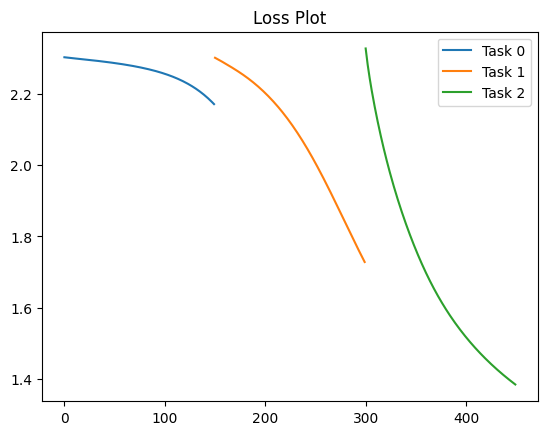

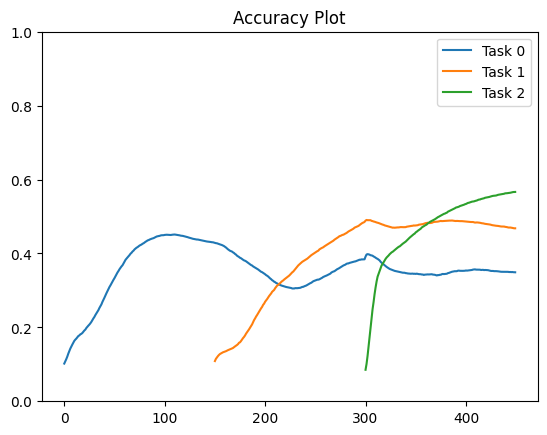

(None, None)

In [ ]:
loss_plot(loss_ewc) , accuracy_plot(acc_ewc)

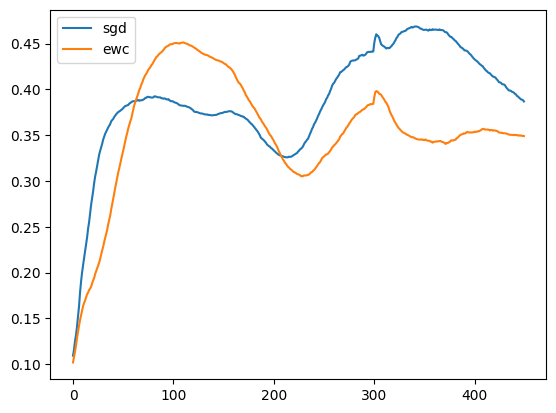

In [ ]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()

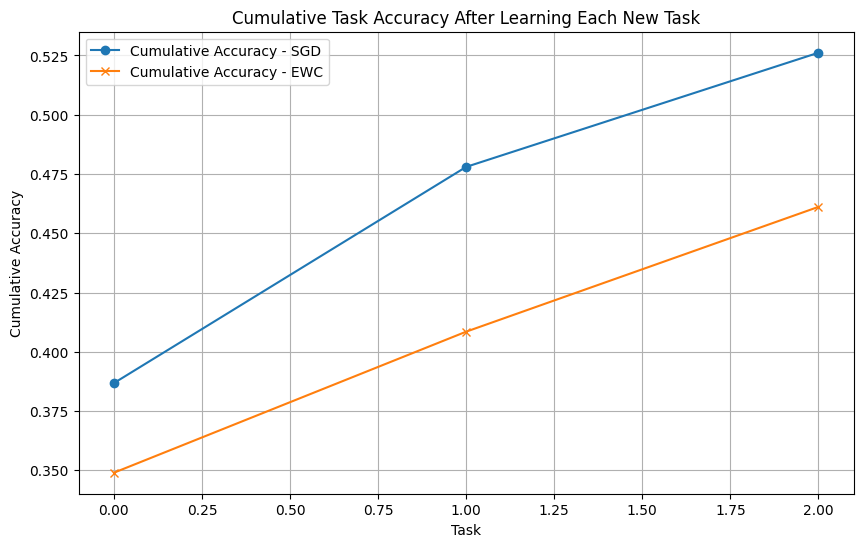

In [ ]:
def cumulative_accuracy_plot(acc_sgd, acc_ewc):
    plt.figure(figsize=(10, 6))

    # Plot cumulative accuracy for SGD
    cum_acc_sgd = [sum(acc_sgd[task][-1] for task in range(i + 1)) / (i + 1) for i in range(num_task)]
    plt.plot(cum_acc_sgd, label="Cumulative Accuracy - SGD", marker='o')

    # Plot cumulative accuracy for EWC
    cum_acc_ewc = [sum(acc_ewc[task][-1] for task in range(i + 1)) / (i + 1) for i in range(num_task)]
    plt.plot(cum_acc_ewc, label="Cumulative Accuracy - EWC", marker='x')

    plt.title("Cumulative Task Accuracy After Learning Each New Task")
    plt.xlabel("Task")
    plt.ylabel("Cumulative Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
cumulative_accuracy_plot(acc, acc_ewc)

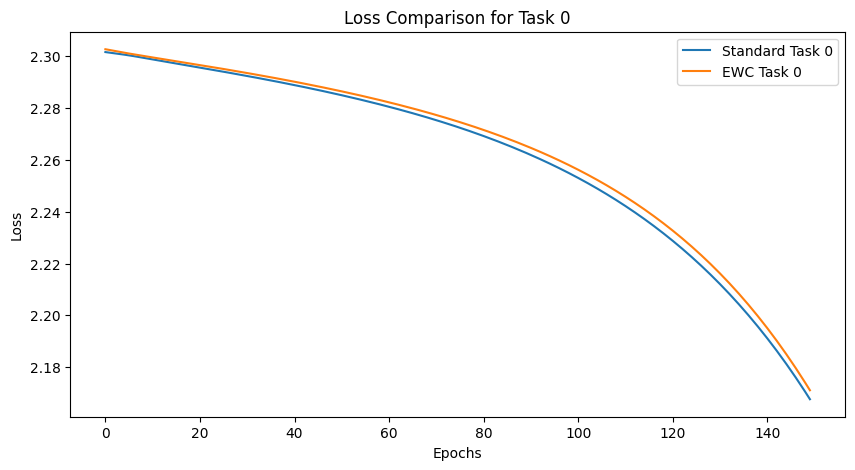

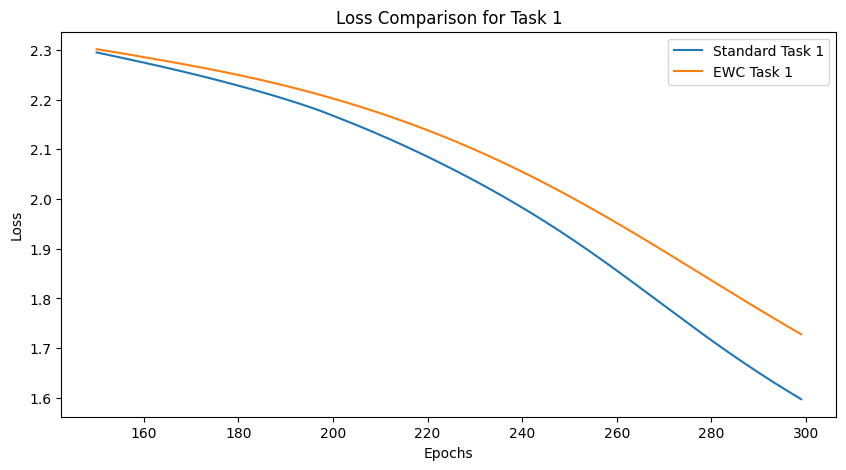

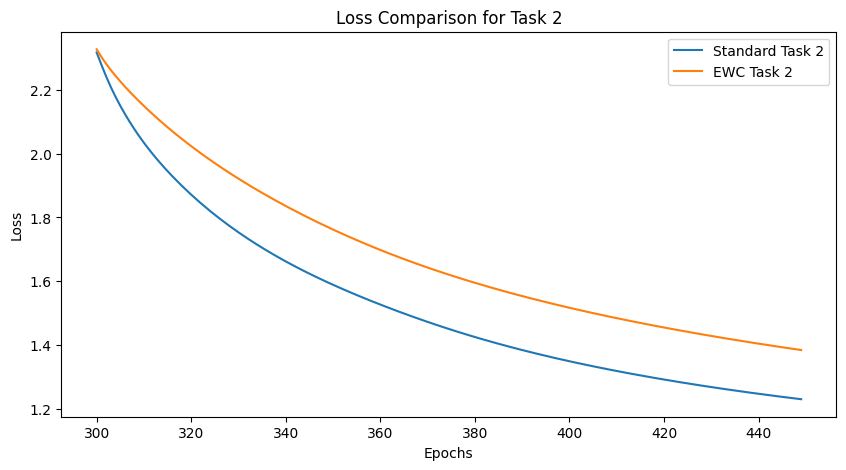

In [ ]:
# Loss Comparison for Each Task
for task in range(num_task):
    plt.figure(figsize=(10, 5))
    plt.plot(range(task * epochs, (task + 1) * epochs), loss[task], label=f'Standard Task {task}')
    plt.plot(range(task * epochs, (task + 1) * epochs), loss_ewc[task], label=f'EWC Task {task}')
    plt.legend()
    plt.title(f'Loss Comparison for Task {task}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()


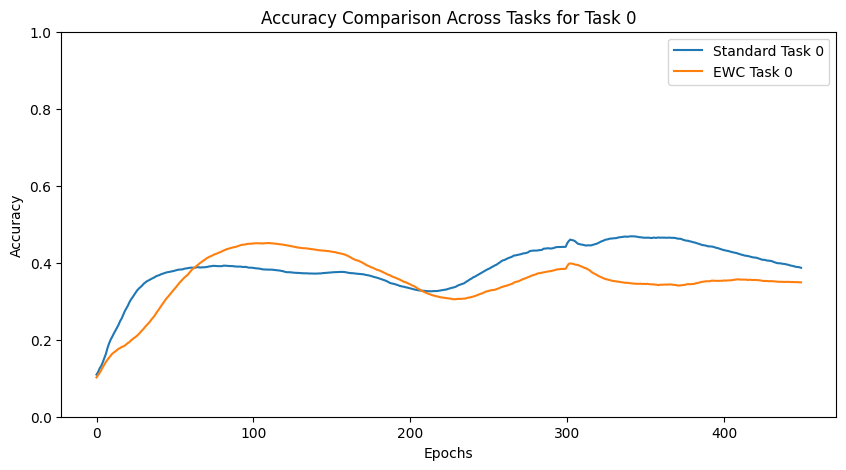

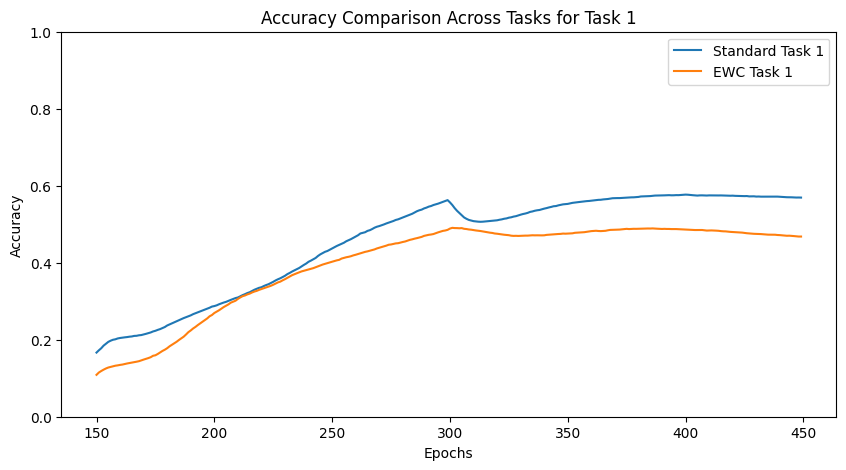

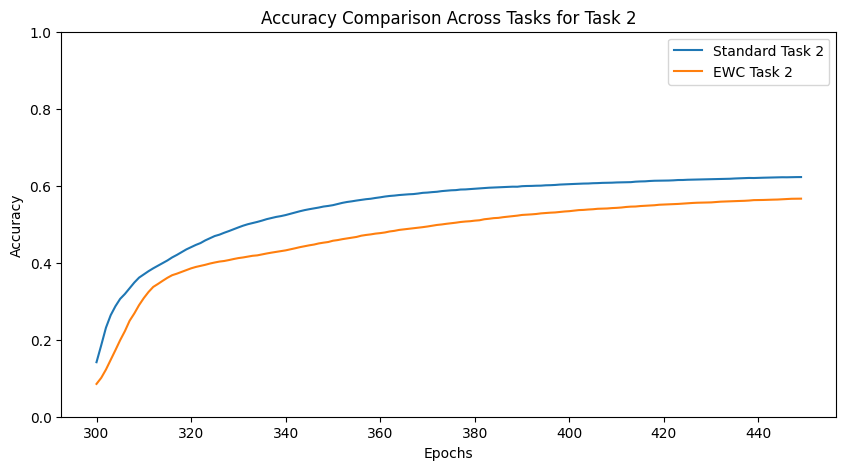

In [ ]:
# Accuracy Comparison Across Tasks
for task in range(num_task):
    plt.figure(figsize=(10, 5))
    plt.plot(range(task * epochs, num_task * epochs), acc[task], label=f'Standard Task {task}')
    plt.plot(range(task * epochs, num_task * epochs), acc_ewc[task], label=f'EWC Task {task}')
    plt.legend()
    plt.title(f'Accuracy Comparison Across Tasks for Task {task}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()


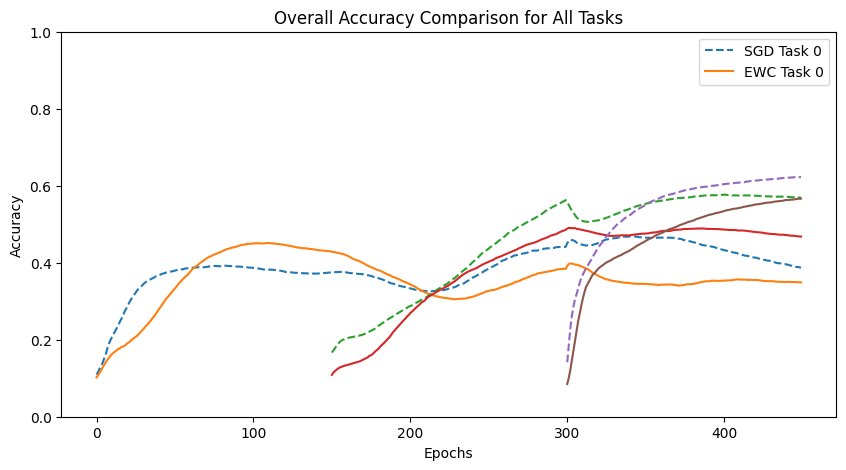

In [ ]:
# Overall Accuracy Comparison for All Tasks
plt.figure(figsize=(10, 5))
plt.plot(range(num_task * epochs), acc[0], label='SGD Task 0', linestyle='dashed')
plt.plot(range(num_task * epochs), acc_ewc[0], label='EWC Task 0', linestyle='solid')
for task in range(1, num_task):
    plt.plot(range(task * epochs, num_task * epochs), acc[task], linestyle='dashed')
    plt.plot(range(task * epochs, num_task * epochs), acc_ewc[task], linestyle='solid')
plt.legend()
plt.title('Overall Accuracy Comparison for All Tasks')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()


In [ ]:
importance_values = [10000]
best_importance = 0
best_accuracy = 0

for importance in importance_values:
    print(f"\nTraining with importance = {importance}")
    loss_ewc, acc_ewc, penalties = ewc_process(epochs, importance=importance)
    final_accuracy = acc_ewc[num_task-1][-1]
    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_importance = importance

print(f"Best importance value: {best_importance} with final accuracy: {best_accuracy}")


Training with importance = 10000


  1%|          | 1/150 [00:10<24:56, 10.04s/it]

Epoch 1/150 | Task 0 | Loss: 2.3023 | Accuracy: 0.0913


  1%|▏         | 2/150 [00:19<23:22,  9.48s/it]

Epoch 2/150 | Task 0 | Loss: 2.3018 | Accuracy: 0.0929


  2%|▏         | 3/150 [00:29<24:04,  9.82s/it]

Epoch 3/150 | Task 0 | Loss: 2.3013 | Accuracy: 0.0938


  3%|▎         | 4/150 [00:39<24:15,  9.97s/it]

Epoch 4/150 | Task 0 | Loss: 2.3008 | Accuracy: 0.0965


  3%|▎         | 5/150 [00:49<23:49,  9.86s/it]

Epoch 5/150 | Task 0 | Loss: 2.3004 | Accuracy: 0.0998


  4%|▍         | 6/150 [00:58<23:13,  9.67s/it]

Epoch 6/150 | Task 0 | Loss: 2.2999 | Accuracy: 0.1018


  5%|▍         | 7/150 [01:08<23:22,  9.81s/it]

Epoch 7/150 | Task 0 | Loss: 2.2995 | Accuracy: 0.1055


  5%|▌         | 8/150 [01:18<23:29,  9.92s/it]

Epoch 8/150 | Task 0 | Loss: 2.2991 | Accuracy: 0.1101


  6%|▌         | 9/150 [01:27<22:44,  9.67s/it]

Epoch 9/150 | Task 0 | Loss: 2.2987 | Accuracy: 0.1149


  7%|▋         | 10/150 [01:37<22:47,  9.76s/it]

Epoch 10/150 | Task 0 | Loss: 2.2983 | Accuracy: 0.1247


  7%|▋         | 11/150 [01:47<22:48,  9.84s/it]

Epoch 11/150 | Task 0 | Loss: 2.2979 | Accuracy: 0.1364


  8%|▊         | 12/150 [01:57<22:41,  9.87s/it]

Epoch 12/150 | Task 0 | Loss: 2.2975 | Accuracy: 0.1476


  9%|▊         | 13/150 [02:06<21:54,  9.60s/it]

Epoch 13/150 | Task 0 | Loss: 2.2971 | Accuracy: 0.1606


  9%|▉         | 14/150 [02:17<22:13,  9.81s/it]

Epoch 14/150 | Task 0 | Loss: 2.2967 | Accuracy: 0.1759


 10%|█         | 15/150 [02:27<22:19,  9.92s/it]

Epoch 15/150 | Task 0 | Loss: 2.2963 | Accuracy: 0.1900


 11%|█         | 16/150 [02:37<22:12,  9.95s/it]

Epoch 16/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.2087


 11%|█▏        | 17/150 [02:46<21:20,  9.63s/it]

Epoch 17/150 | Task 0 | Loss: 2.2955 | Accuracy: 0.2260


 12%|█▏        | 18/150 [02:56<21:29,  9.77s/it]

Epoch 18/150 | Task 0 | Loss: 2.2951 | Accuracy: 0.2406


 13%|█▎        | 19/150 [03:06<21:35,  9.89s/it]

Epoch 19/150 | Task 0 | Loss: 2.2946 | Accuracy: 0.2564


 13%|█▎        | 20/150 [03:16<21:15,  9.81s/it]

Epoch 20/150 | Task 0 | Loss: 2.2942 | Accuracy: 0.2727


 14%|█▍        | 21/150 [03:25<20:52,  9.71s/it]

Epoch 21/150 | Task 0 | Loss: 2.2938 | Accuracy: 0.2890


 15%|█▍        | 22/150 [03:35<20:59,  9.84s/it]

Epoch 22/150 | Task 0 | Loss: 2.2934 | Accuracy: 0.3012


 15%|█▌        | 23/150 [03:45<20:59,  9.92s/it]

Epoch 23/150 | Task 0 | Loss: 2.2930 | Accuracy: 0.3125


 16%|█▌        | 24/150 [03:55<20:26,  9.73s/it]

Epoch 24/150 | Task 0 | Loss: 2.2926 | Accuracy: 0.3252


 17%|█▋        | 25/150 [04:04<20:19,  9.75s/it]

Epoch 25/150 | Task 0 | Loss: 2.2921 | Accuracy: 0.3347


 17%|█▋        | 26/150 [04:15<20:22,  9.86s/it]

Epoch 26/150 | Task 0 | Loss: 2.2917 | Accuracy: 0.3449


 18%|█▊        | 27/150 [04:24<20:16,  9.89s/it]

Epoch 27/150 | Task 0 | Loss: 2.2913 | Accuracy: 0.3546


 19%|█▊        | 28/150 [04:33<19:27,  9.57s/it]

Epoch 28/150 | Task 0 | Loss: 2.2908 | Accuracy: 0.3634


 19%|█▉        | 29/150 [04:43<19:31,  9.68s/it]

Epoch 29/150 | Task 0 | Loss: 2.2904 | Accuracy: 0.3710


 20%|██        | 30/150 [04:53<19:29,  9.74s/it]

Epoch 30/150 | Task 0 | Loss: 2.2899 | Accuracy: 0.3798


 21%|██        | 31/150 [05:03<19:13,  9.69s/it]

Epoch 31/150 | Task 0 | Loss: 2.2895 | Accuracy: 0.3863


 21%|██▏       | 32/150 [05:12<18:43,  9.53s/it]

Epoch 32/150 | Task 0 | Loss: 2.2890 | Accuracy: 0.3935


 22%|██▏       | 33/150 [05:22<18:58,  9.73s/it]

Epoch 33/150 | Task 0 | Loss: 2.2886 | Accuracy: 0.3995


 23%|██▎       | 34/150 [05:32<19:00,  9.83s/it]

Epoch 34/150 | Task 0 | Loss: 2.2881 | Accuracy: 0.4066


 23%|██▎       | 35/150 [05:41<18:31,  9.67s/it]

Epoch 35/150 | Task 0 | Loss: 2.2877 | Accuracy: 0.4129


 24%|██▍       | 36/150 [05:51<18:20,  9.65s/it]

Epoch 36/150 | Task 0 | Loss: 2.2872 | Accuracy: 0.4179


 25%|██▍       | 37/150 [06:01<18:23,  9.76s/it]

Epoch 37/150 | Task 0 | Loss: 2.2867 | Accuracy: 0.4234


 25%|██▌       | 38/150 [06:11<18:30,  9.91s/it]

Epoch 38/150 | Task 0 | Loss: 2.2862 | Accuracy: 0.4285


 26%|██▌       | 39/150 [06:20<17:48,  9.63s/it]

Epoch 39/150 | Task 0 | Loss: 2.2857 | Accuracy: 0.4338


 27%|██▋       | 40/150 [06:30<17:58,  9.80s/it]

Epoch 40/150 | Task 0 | Loss: 2.2852 | Accuracy: 0.4386


 27%|██▋       | 41/150 [06:41<18:04,  9.95s/it]

Epoch 41/150 | Task 0 | Loss: 2.2847 | Accuracy: 0.4441


 28%|██▊       | 42/150 [06:51<18:04, 10.04s/it]

Epoch 42/150 | Task 0 | Loss: 2.2842 | Accuracy: 0.4506


 29%|██▊       | 43/150 [07:00<17:17,  9.70s/it]

Epoch 43/150 | Task 0 | Loss: 2.2837 | Accuracy: 0.4560


 29%|██▉       | 44/150 [07:10<17:18,  9.80s/it]

Epoch 44/150 | Task 0 | Loss: 2.2832 | Accuracy: 0.4614


 30%|███       | 45/150 [07:20<17:21,  9.92s/it]

Epoch 45/150 | Task 0 | Loss: 2.2827 | Accuracy: 0.4659


 31%|███       | 46/150 [07:30<17:05,  9.86s/it]

Epoch 46/150 | Task 0 | Loss: 2.2821 | Accuracy: 0.4702


 31%|███▏      | 47/150 [07:39<16:25,  9.57s/it]

Epoch 47/150 | Task 0 | Loss: 2.2816 | Accuracy: 0.4739


 32%|███▏      | 48/150 [07:49<16:28,  9.69s/it]

Epoch 48/150 | Task 0 | Loss: 2.2810 | Accuracy: 0.4785


 33%|███▎      | 49/150 [07:59<16:25,  9.76s/it]

Epoch 49/150 | Task 0 | Loss: 2.2805 | Accuracy: 0.4822


 33%|███▎      | 50/150 [08:08<15:58,  9.58s/it]

Epoch 50/150 | Task 0 | Loss: 2.2799 | Accuracy: 0.4855


 34%|███▍      | 51/150 [08:18<15:53,  9.63s/it]

Epoch 51/150 | Task 0 | Loss: 2.2793 | Accuracy: 0.4888


 35%|███▍      | 52/150 [08:28<15:58,  9.78s/it]

Epoch 52/150 | Task 0 | Loss: 2.2787 | Accuracy: 0.4933


 35%|███▌      | 53/150 [08:38<15:57,  9.88s/it]

Epoch 53/150 | Task 0 | Loss: 2.2781 | Accuracy: 0.4966


 36%|███▌      | 54/150 [08:47<15:20,  9.59s/it]

Epoch 54/150 | Task 0 | Loss: 2.2775 | Accuracy: 0.5008


 37%|███▋      | 55/150 [08:57<15:24,  9.73s/it]

Epoch 55/150 | Task 0 | Loss: 2.2769 | Accuracy: 0.5049


 37%|███▋      | 56/150 [09:07<15:27,  9.87s/it]

Epoch 56/150 | Task 0 | Loss: 2.2763 | Accuracy: 0.5079


 38%|███▊      | 57/150 [09:16<15:09,  9.78s/it]

Epoch 57/150 | Task 0 | Loss: 2.2756 | Accuracy: 0.5115


 39%|███▊      | 58/150 [09:26<14:38,  9.55s/it]

Epoch 58/150 | Task 0 | Loss: 2.2750 | Accuracy: 0.5145


 39%|███▉      | 59/150 [09:35<14:37,  9.64s/it]

Epoch 59/150 | Task 0 | Loss: 2.2743 | Accuracy: 0.5168


 40%|████      | 60/150 [09:46<14:41,  9.79s/it]

Epoch 60/150 | Task 0 | Loss: 2.2737 | Accuracy: 0.5192


 41%|████      | 61/150 [09:54<14:07,  9.52s/it]

Epoch 61/150 | Task 0 | Loss: 2.2730 | Accuracy: 0.5212


 41%|████▏     | 62/150 [10:04<14:03,  9.58s/it]

Epoch 62/150 | Task 0 | Loss: 2.2723 | Accuracy: 0.5243


 42%|████▏     | 63/150 [10:14<14:04,  9.71s/it]

Epoch 63/150 | Task 0 | Loss: 2.2716 | Accuracy: 0.5268


 43%|████▎     | 64/150 [10:24<13:59,  9.77s/it]

Epoch 64/150 | Task 0 | Loss: 2.2709 | Accuracy: 0.5290


 43%|████▎     | 65/150 [10:33<13:31,  9.55s/it]

Epoch 65/150 | Task 0 | Loss: 2.2701 | Accuracy: 0.5312


 44%|████▍     | 66/150 [10:43<13:37,  9.73s/it]

Epoch 66/150 | Task 0 | Loss: 2.2694 | Accuracy: 0.5332


 45%|████▍     | 67/150 [10:53<13:33,  9.80s/it]

Epoch 67/150 | Task 0 | Loss: 2.2686 | Accuracy: 0.5353


 45%|████▌     | 68/150 [11:03<13:20,  9.76s/it]

Epoch 68/150 | Task 0 | Loss: 2.2678 | Accuracy: 0.5381


 46%|████▌     | 69/150 [11:12<12:55,  9.57s/it]

Epoch 69/150 | Task 0 | Loss: 2.2671 | Accuracy: 0.5404


 47%|████▋     | 70/150 [11:22<13:00,  9.76s/it]

Epoch 70/150 | Task 0 | Loss: 2.2663 | Accuracy: 0.5429


 47%|████▋     | 71/150 [11:32<12:58,  9.86s/it]

Epoch 71/150 | Task 0 | Loss: 2.2654 | Accuracy: 0.5439


 48%|████▊     | 72/150 [11:42<12:36,  9.70s/it]

Epoch 72/150 | Task 0 | Loss: 2.2646 | Accuracy: 0.5457


 49%|████▊     | 73/150 [11:51<12:22,  9.64s/it]

Epoch 73/150 | Task 0 | Loss: 2.2638 | Accuracy: 0.5475


 49%|████▉     | 74/150 [12:01<12:23,  9.79s/it]

Epoch 74/150 | Task 0 | Loss: 2.2629 | Accuracy: 0.5488


 50%|█████     | 75/150 [12:11<12:21,  9.89s/it]

Epoch 75/150 | Task 0 | Loss: 2.2620 | Accuracy: 0.5510


 51%|█████     | 76/150 [12:20<11:51,  9.62s/it]

Epoch 76/150 | Task 0 | Loss: 2.2611 | Accuracy: 0.5531


 51%|█████▏    | 77/150 [12:30<11:50,  9.73s/it]

Epoch 77/150 | Task 0 | Loss: 2.2602 | Accuracy: 0.5547


 52%|█████▏    | 78/150 [12:40<11:49,  9.86s/it]

Epoch 78/150 | Task 0 | Loss: 2.2593 | Accuracy: 0.5561


 53%|█████▎    | 79/150 [12:50<11:40,  9.87s/it]

Epoch 79/150 | Task 0 | Loss: 2.2583 | Accuracy: 0.5580


 53%|█████▎    | 80/150 [13:00<11:30,  9.87s/it]

Epoch 80/150 | Task 0 | Loss: 2.2573 | Accuracy: 0.5589


 54%|█████▍    | 81/150 [13:11<11:42, 10.18s/it]

Epoch 81/150 | Task 0 | Loss: 2.2563 | Accuracy: 0.5606


 55%|█████▍    | 82/150 [13:22<11:54, 10.51s/it]

Epoch 82/150 | Task 0 | Loss: 2.2553 | Accuracy: 0.5616


 55%|█████▌    | 83/150 [13:32<11:33, 10.35s/it]

Epoch 83/150 | Task 0 | Loss: 2.2543 | Accuracy: 0.5635


 56%|█████▌    | 84/150 [13:42<11:11, 10.18s/it]

Epoch 84/150 | Task 0 | Loss: 2.2532 | Accuracy: 0.5653


 57%|█████▋    | 85/150 [13:52<10:51, 10.03s/it]

Epoch 85/150 | Task 0 | Loss: 2.2521 | Accuracy: 0.5659


 57%|█████▋    | 86/150 [14:02<10:46, 10.11s/it]

Epoch 86/150 | Task 0 | Loss: 2.2510 | Accuracy: 0.5673


 58%|█████▊    | 87/150 [14:12<10:40, 10.17s/it]

Epoch 87/150 | Task 0 | Loss: 2.2499 | Accuracy: 0.5684


 59%|█████▊    | 88/150 [14:22<10:14,  9.92s/it]

Epoch 88/150 | Task 0 | Loss: 2.2488 | Accuracy: 0.5688


 59%|█████▉    | 89/150 [14:32<10:05,  9.93s/it]

Epoch 89/150 | Task 0 | Loss: 2.2476 | Accuracy: 0.5692


 60%|██████    | 90/150 [14:42<10:01, 10.03s/it]

Epoch 90/150 | Task 0 | Loss: 2.2464 | Accuracy: 0.5705


 61%|██████    | 91/150 [14:52<09:53, 10.06s/it]

Epoch 91/150 | Task 0 | Loss: 2.2452 | Accuracy: 0.5707


 61%|██████▏   | 92/150 [15:01<09:23,  9.71s/it]

Epoch 92/150 | Task 0 | Loss: 2.2439 | Accuracy: 0.5710


 62%|██████▏   | 93/150 [15:11<09:21,  9.85s/it]

Epoch 93/150 | Task 0 | Loss: 2.2426 | Accuracy: 0.5719


 63%|██████▎   | 94/150 [15:21<09:14,  9.90s/it]

Epoch 94/150 | Task 0 | Loss: 2.2413 | Accuracy: 0.5723


 63%|██████▎   | 95/150 [15:31<09:03,  9.89s/it]

Epoch 95/150 | Task 0 | Loss: 2.2400 | Accuracy: 0.5732


 64%|██████▍   | 96/150 [15:40<08:35,  9.55s/it]

Epoch 96/150 | Task 0 | Loss: 2.2386 | Accuracy: 0.5737


 65%|██████▍   | 97/150 [15:50<08:35,  9.73s/it]

Epoch 97/150 | Task 0 | Loss: 2.2372 | Accuracy: 0.5733


 65%|██████▌   | 98/150 [16:00<08:28,  9.78s/it]

Epoch 98/150 | Task 0 | Loss: 2.2357 | Accuracy: 0.5736


 66%|██████▌   | 99/150 [16:09<08:11,  9.64s/it]

Epoch 99/150 | Task 0 | Loss: 2.2343 | Accuracy: 0.5744


 67%|██████▋   | 100/150 [16:19<08:02,  9.64s/it]

Epoch 100/150 | Task 0 | Loss: 2.2328 | Accuracy: 0.5754


 67%|██████▋   | 101/150 [16:29<07:58,  9.76s/it]

Epoch 101/150 | Task 0 | Loss: 2.2312 | Accuracy: 0.5752


 68%|██████▊   | 102/150 [16:39<07:50,  9.80s/it]

Epoch 102/150 | Task 0 | Loss: 2.2297 | Accuracy: 0.5754


 69%|██████▊   | 103/150 [16:48<07:26,  9.51s/it]

Epoch 103/150 | Task 0 | Loss: 2.2280 | Accuracy: 0.5760


 69%|██████▉   | 104/150 [16:58<07:25,  9.69s/it]

Epoch 104/150 | Task 0 | Loss: 2.2264 | Accuracy: 0.5766


 70%|███████   | 105/150 [17:08<07:20,  9.79s/it]

Epoch 105/150 | Task 0 | Loss: 2.2247 | Accuracy: 0.5766


 71%|███████   | 106/150 [17:18<07:13,  9.86s/it]

Epoch 106/150 | Task 0 | Loss: 2.2230 | Accuracy: 0.5766


 71%|███████▏  | 107/150 [17:27<06:52,  9.60s/it]

Epoch 107/150 | Task 0 | Loss: 2.2212 | Accuracy: 0.5757


 72%|███████▏  | 108/150 [17:37<06:49,  9.75s/it]

Epoch 108/150 | Task 0 | Loss: 2.2194 | Accuracy: 0.5756


 73%|███████▎  | 109/150 [17:47<06:44,  9.86s/it]

Epoch 109/150 | Task 0 | Loss: 2.2175 | Accuracy: 0.5761


 73%|███████▎  | 110/150 [17:57<06:30,  9.76s/it]

Epoch 110/150 | Task 0 | Loss: 2.2156 | Accuracy: 0.5760


 74%|███████▍  | 111/150 [18:06<06:14,  9.61s/it]

Epoch 111/150 | Task 0 | Loss: 2.2136 | Accuracy: 0.5763


 75%|███████▍  | 112/150 [18:16<06:11,  9.77s/it]

Epoch 112/150 | Task 0 | Loss: 2.2116 | Accuracy: 0.5755


 75%|███████▌  | 113/150 [18:26<06:05,  9.87s/it]

Epoch 113/150 | Task 0 | Loss: 2.2096 | Accuracy: 0.5754


 76%|███████▌  | 114/150 [18:35<05:45,  9.61s/it]

Epoch 114/150 | Task 0 | Loss: 2.2075 | Accuracy: 0.5758


 77%|███████▋  | 115/150 [18:45<05:41,  9.75s/it]

Epoch 115/150 | Task 0 | Loss: 2.2053 | Accuracy: 0.5752


 77%|███████▋  | 116/150 [18:55<05:34,  9.85s/it]

Epoch 116/150 | Task 0 | Loss: 2.2031 | Accuracy: 0.5743


 78%|███████▊  | 117/150 [19:05<05:26,  9.90s/it]

Epoch 117/150 | Task 0 | Loss: 2.2008 | Accuracy: 0.5737


 79%|███████▊  | 118/150 [19:14<05:07,  9.61s/it]

Epoch 118/150 | Task 0 | Loss: 2.1985 | Accuracy: 0.5733


 79%|███████▉  | 119/150 [19:24<05:02,  9.75s/it]

Epoch 119/150 | Task 0 | Loss: 2.1961 | Accuracy: 0.5731


 80%|████████  | 120/150 [19:34<04:54,  9.82s/it]

Epoch 120/150 | Task 0 | Loss: 2.1936 | Accuracy: 0.5729


 81%|████████  | 121/150 [19:44<04:44,  9.81s/it]

Epoch 121/150 | Task 0 | Loss: 2.1911 | Accuracy: 0.5733


 81%|████████▏ | 122/150 [19:53<04:27,  9.57s/it]

Epoch 122/150 | Task 0 | Loss: 2.1885 | Accuracy: 0.5730


 82%|████████▏ | 123/150 [20:03<04:22,  9.71s/it]

Epoch 123/150 | Task 0 | Loss: 2.1859 | Accuracy: 0.5729


 83%|████████▎ | 124/150 [20:13<04:14,  9.80s/it]

Epoch 124/150 | Task 0 | Loss: 2.1831 | Accuracy: 0.5721


 83%|████████▎ | 125/150 [20:23<04:04,  9.79s/it]

Epoch 125/150 | Task 0 | Loss: 2.1803 | Accuracy: 0.5717


 84%|████████▍ | 126/150 [20:32<03:53,  9.71s/it]

Epoch 126/150 | Task 0 | Loss: 2.1774 | Accuracy: 0.5714


 85%|████████▍ | 127/150 [20:42<03:45,  9.80s/it]

Epoch 127/150 | Task 0 | Loss: 2.1745 | Accuracy: 0.5711


 85%|████████▌ | 128/150 [20:52<03:37,  9.87s/it]

Epoch 128/150 | Task 0 | Loss: 2.1714 | Accuracy: 0.5711


 86%|████████▌ | 129/150 [21:01<03:20,  9.53s/it]

Epoch 129/150 | Task 0 | Loss: 2.1683 | Accuracy: 0.5711


 87%|████████▋ | 130/150 [21:11<03:13,  9.68s/it]

Epoch 130/150 | Task 0 | Loss: 2.1651 | Accuracy: 0.5711


 87%|████████▋ | 131/150 [21:21<03:06,  9.84s/it]

Epoch 131/150 | Task 0 | Loss: 2.1618 | Accuracy: 0.5711


 88%|████████▊ | 132/150 [21:31<02:57,  9.85s/it]

Epoch 132/150 | Task 0 | Loss: 2.1584 | Accuracy: 0.5705


 89%|████████▊ | 133/150 [21:40<02:41,  9.51s/it]

Epoch 133/150 | Task 0 | Loss: 2.1549 | Accuracy: 0.5700


 89%|████████▉ | 134/150 [21:50<02:35,  9.71s/it]

Epoch 134/150 | Task 0 | Loss: 2.1513 | Accuracy: 0.5696


 90%|█████████ | 135/150 [22:00<02:26,  9.77s/it]

Epoch 135/150 | Task 0 | Loss: 2.1477 | Accuracy: 0.5694


 91%|█████████ | 136/150 [22:09<02:14,  9.62s/it]

Epoch 136/150 | Task 0 | Loss: 2.1439 | Accuracy: 0.5693


 91%|█████████▏| 137/150 [22:19<02:05,  9.66s/it]

Epoch 137/150 | Task 0 | Loss: 2.1400 | Accuracy: 0.5690


 92%|█████████▏| 138/150 [22:29<01:57,  9.80s/it]

Epoch 138/150 | Task 0 | Loss: 2.1360 | Accuracy: 0.5691


 93%|█████████▎| 139/150 [22:39<01:48,  9.89s/it]

Epoch 139/150 | Task 0 | Loss: 2.1319 | Accuracy: 0.5689


 93%|█████████▎| 140/150 [22:49<01:37,  9.72s/it]

Epoch 140/150 | Task 0 | Loss: 2.1276 | Accuracy: 0.5686


 94%|█████████▍| 141/150 [22:59<01:28,  9.81s/it]

Epoch 141/150 | Task 0 | Loss: 2.1233 | Accuracy: 0.5684


 95%|█████████▍| 142/150 [23:09<01:18,  9.84s/it]

Epoch 142/150 | Task 0 | Loss: 2.1188 | Accuracy: 0.5687


 95%|█████████▌| 143/150 [23:19<01:09,  9.88s/it]

Epoch 143/150 | Task 0 | Loss: 2.1142 | Accuracy: 0.5679


 96%|█████████▌| 144/150 [23:27<00:57,  9.54s/it]

Epoch 144/150 | Task 0 | Loss: 2.1095 | Accuracy: 0.5683


 97%|█████████▋| 145/150 [23:37<00:48,  9.71s/it]

Epoch 145/150 | Task 0 | Loss: 2.1046 | Accuracy: 0.5673


 97%|█████████▋| 146/150 [23:47<00:39,  9.82s/it]

Epoch 146/150 | Task 0 | Loss: 2.0996 | Accuracy: 0.5669


 98%|█████████▊| 147/150 [23:57<00:29,  9.73s/it]

Epoch 147/150 | Task 0 | Loss: 2.0945 | Accuracy: 0.5676


 99%|█████████▊| 148/150 [24:06<00:19,  9.60s/it]

Epoch 148/150 | Task 0 | Loss: 2.0892 | Accuracy: 0.5672


 99%|█████████▉| 149/150 [24:16<00:09,  9.73s/it]

Epoch 149/150 | Task 0 | Loss: 2.0838 | Accuracy: 0.5669


100%|██████████| 150/150 [24:26<00:00,  9.78s/it]


Epoch 150/150 | Task 0 | Loss: 2.0782 | Accuracy: 0.5671
Final Loss and Accuracy after training on Task 0:
Task 0 | Loss: 2.0782 | Accuracy: 0.5671
--------------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150 | Task 1 | Loss: 2.2795 | Accuracy: 0.5665


  1%|          | 1/150 [00:14<37:10, 14.97s/it]

Epoch 1/150 | Task 1 | Loss: 2.2795 | Accuracy: 0.2105
Epoch 2/150 | Task 1 | Loss: 2.2762 | Accuracy: 0.5638


  1%|▏         | 2/150 [00:29<36:58, 14.99s/it]

Epoch 2/150 | Task 1 | Loss: 2.2762 | Accuracy: 0.2115
Epoch 3/150 | Task 1 | Loss: 2.2730 | Accuracy: 0.5612


  2%|▏         | 3/150 [00:44<36:27, 14.88s/it]

Epoch 3/150 | Task 1 | Loss: 2.2730 | Accuracy: 0.2123
Epoch 4/150 | Task 1 | Loss: 2.2697 | Accuracy: 0.5589


  3%|▎         | 4/150 [00:59<36:22, 14.95s/it]

Epoch 4/150 | Task 1 | Loss: 2.2697 | Accuracy: 0.2134
Epoch 5/150 | Task 1 | Loss: 2.2665 | Accuracy: 0.5570


  3%|▎         | 5/150 [01:14<35:55, 14.87s/it]

Epoch 5/150 | Task 1 | Loss: 2.2665 | Accuracy: 0.2140
Epoch 6/150 | Task 1 | Loss: 2.2632 | Accuracy: 0.5559


  4%|▍         | 6/150 [01:29<35:51, 14.94s/it]

Epoch 6/150 | Task 1 | Loss: 2.2632 | Accuracy: 0.2145
Epoch 7/150 | Task 1 | Loss: 2.2599 | Accuracy: 0.5531


  5%|▍         | 7/150 [01:44<35:53, 15.06s/it]

Epoch 7/150 | Task 1 | Loss: 2.2599 | Accuracy: 0.2152
Epoch 8/150 | Task 1 | Loss: 2.2566 | Accuracy: 0.5506


  5%|▌         | 8/150 [01:59<35:40, 15.07s/it]

Epoch 8/150 | Task 1 | Loss: 2.2566 | Accuracy: 0.2169
Epoch 9/150 | Task 1 | Loss: 2.2533 | Accuracy: 0.5485


  6%|▌         | 9/150 [02:14<35:13, 14.99s/it]

Epoch 9/150 | Task 1 | Loss: 2.2533 | Accuracy: 0.2189
Epoch 10/150 | Task 1 | Loss: 2.2499 | Accuracy: 0.5469


  7%|▋         | 10/150 [02:29<34:53, 14.95s/it]

Epoch 10/150 | Task 1 | Loss: 2.2499 | Accuracy: 0.2208
Epoch 11/150 | Task 1 | Loss: 2.2466 | Accuracy: 0.5457


  7%|▋         | 11/150 [02:44<34:25, 14.86s/it]

Epoch 11/150 | Task 1 | Loss: 2.2466 | Accuracy: 0.2234
Epoch 12/150 | Task 1 | Loss: 2.2432 | Accuracy: 0.5438


  8%|▊         | 12/150 [02:59<34:11, 14.87s/it]

Epoch 12/150 | Task 1 | Loss: 2.2432 | Accuracy: 0.2264
Epoch 13/150 | Task 1 | Loss: 2.2398 | Accuracy: 0.5419


  9%|▊         | 13/150 [03:13<33:47, 14.80s/it]

Epoch 13/150 | Task 1 | Loss: 2.2398 | Accuracy: 0.2289
Epoch 14/150 | Task 1 | Loss: 2.2364 | Accuracy: 0.5406


  9%|▉         | 14/150 [03:28<33:32, 14.80s/it]

Epoch 14/150 | Task 1 | Loss: 2.2364 | Accuracy: 0.2324
Epoch 15/150 | Task 1 | Loss: 2.2330 | Accuracy: 0.5393


 10%|█         | 15/150 [03:44<33:49, 15.03s/it]

Epoch 15/150 | Task 1 | Loss: 2.2330 | Accuracy: 0.2355
Epoch 16/150 | Task 1 | Loss: 2.2295 | Accuracy: 0.5368


 11%|█         | 16/150 [03:59<33:47, 15.13s/it]

Epoch 16/150 | Task 1 | Loss: 2.2295 | Accuracy: 0.2396
Epoch 17/150 | Task 1 | Loss: 2.2260 | Accuracy: 0.5356


 11%|█▏        | 17/150 [04:14<33:18, 15.02s/it]

Epoch 17/150 | Task 1 | Loss: 2.2260 | Accuracy: 0.2437
Epoch 18/150 | Task 1 | Loss: 2.2224 | Accuracy: 0.5343


 12%|█▏        | 18/150 [04:29<33:06, 15.05s/it]

Epoch 18/150 | Task 1 | Loss: 2.2224 | Accuracy: 0.2484
Epoch 19/150 | Task 1 | Loss: 2.2188 | Accuracy: 0.5339


 13%|█▎        | 19/150 [04:44<32:42, 14.98s/it]

Epoch 19/150 | Task 1 | Loss: 2.2188 | Accuracy: 0.2541
Epoch 20/150 | Task 1 | Loss: 2.2152 | Accuracy: 0.5329


 13%|█▎        | 20/150 [04:59<32:29, 15.00s/it]

Epoch 20/150 | Task 1 | Loss: 2.2152 | Accuracy: 0.2589
Epoch 21/150 | Task 1 | Loss: 2.2115 | Accuracy: 0.5314


 14%|█▍        | 21/150 [05:13<32:02, 14.90s/it]

Epoch 21/150 | Task 1 | Loss: 2.2115 | Accuracy: 0.2632
Epoch 22/150 | Task 1 | Loss: 2.2078 | Accuracy: 0.5301


 15%|█▍        | 22/150 [05:28<31:43, 14.87s/it]

Epoch 22/150 | Task 1 | Loss: 2.2078 | Accuracy: 0.2705
Epoch 23/150 | Task 1 | Loss: 2.2041 | Accuracy: 0.5297


 15%|█▌        | 23/150 [05:43<31:39, 14.96s/it]

Epoch 23/150 | Task 1 | Loss: 2.2041 | Accuracy: 0.2766
Epoch 24/150 | Task 1 | Loss: 2.2003 | Accuracy: 0.5283


 16%|█▌        | 24/150 [05:59<31:36, 15.05s/it]

Epoch 24/150 | Task 1 | Loss: 2.2003 | Accuracy: 0.2836
Epoch 25/150 | Task 1 | Loss: 2.1964 | Accuracy: 0.5271


 17%|█▋        | 25/150 [06:14<31:13, 14.99s/it]

Epoch 25/150 | Task 1 | Loss: 2.1964 | Accuracy: 0.2894
Epoch 26/150 | Task 1 | Loss: 2.1925 | Accuracy: 0.5260


 17%|█▋        | 26/150 [06:29<31:00, 15.00s/it]

Epoch 26/150 | Task 1 | Loss: 2.1925 | Accuracy: 0.2962
Epoch 27/150 | Task 1 | Loss: 2.1886 | Accuracy: 0.5247


 18%|█▊        | 27/150 [06:43<30:39, 14.96s/it]

Epoch 27/150 | Task 1 | Loss: 2.1886 | Accuracy: 0.3027
Epoch 28/150 | Task 1 | Loss: 2.1846 | Accuracy: 0.5241


 19%|█▊        | 28/150 [06:59<30:32, 15.02s/it]

Epoch 28/150 | Task 1 | Loss: 2.1846 | Accuracy: 0.3090
Epoch 29/150 | Task 1 | Loss: 2.1806 | Accuracy: 0.5227


 19%|█▉        | 29/150 [07:13<30:05, 14.92s/it]

Epoch 29/150 | Task 1 | Loss: 2.1806 | Accuracy: 0.3160
Epoch 30/150 | Task 1 | Loss: 2.1765 | Accuracy: 0.5223


 20%|██        | 30/150 [07:28<29:51, 14.93s/it]

Epoch 30/150 | Task 1 | Loss: 2.1765 | Accuracy: 0.3214
Epoch 31/150 | Task 1 | Loss: 2.1723 | Accuracy: 0.5214


 21%|██        | 31/150 [07:44<29:51, 15.05s/it]

Epoch 31/150 | Task 1 | Loss: 2.1723 | Accuracy: 0.3283
Epoch 32/150 | Task 1 | Loss: 2.1681 | Accuracy: 0.5201


 21%|██▏       | 32/150 [07:59<29:50, 15.17s/it]

Epoch 32/150 | Task 1 | Loss: 2.1681 | Accuracy: 0.3357
Epoch 33/150 | Task 1 | Loss: 2.1638 | Accuracy: 0.5192


 22%|██▏       | 33/150 [08:14<29:31, 15.14s/it]

Epoch 33/150 | Task 1 | Loss: 2.1638 | Accuracy: 0.3428
Epoch 34/150 | Task 1 | Loss: 2.1595 | Accuracy: 0.5178


 23%|██▎       | 34/150 [08:29<29:12, 15.11s/it]

Epoch 34/150 | Task 1 | Loss: 2.1595 | Accuracy: 0.3482
Epoch 35/150 | Task 1 | Loss: 2.1551 | Accuracy: 0.5172


 23%|██▎       | 35/150 [08:44<28:47, 15.02s/it]

Epoch 35/150 | Task 1 | Loss: 2.1551 | Accuracy: 0.3535
Epoch 36/150 | Task 1 | Loss: 2.1506 | Accuracy: 0.5156


 24%|██▍       | 36/150 [08:59<28:37, 15.07s/it]

Epoch 36/150 | Task 1 | Loss: 2.1506 | Accuracy: 0.3603
Epoch 37/150 | Task 1 | Loss: 2.1461 | Accuracy: 0.5149


 25%|██▍       | 37/150 [09:14<28:26, 15.10s/it]

Epoch 37/150 | Task 1 | Loss: 2.1461 | Accuracy: 0.3661
Epoch 38/150 | Task 1 | Loss: 2.1415 | Accuracy: 0.5138


 25%|██▌       | 38/150 [09:30<28:16, 15.15s/it]

Epoch 38/150 | Task 1 | Loss: 2.1415 | Accuracy: 0.3710
Epoch 39/150 | Task 1 | Loss: 2.1368 | Accuracy: 0.5125


 26%|██▌       | 39/150 [09:45<28:15, 15.28s/it]

Epoch 39/150 | Task 1 | Loss: 2.1368 | Accuracy: 0.3772
Epoch 40/150 | Task 1 | Loss: 2.1321 | Accuracy: 0.5116


 27%|██▋       | 40/150 [10:00<27:58, 15.26s/it]

Epoch 40/150 | Task 1 | Loss: 2.1321 | Accuracy: 0.3841
Epoch 41/150 | Task 1 | Loss: 2.1273 | Accuracy: 0.5113


 27%|██▋       | 41/150 [10:15<27:31, 15.15s/it]

Epoch 41/150 | Task 1 | Loss: 2.1273 | Accuracy: 0.3905
Epoch 42/150 | Task 1 | Loss: 2.1223 | Accuracy: 0.5106


 28%|██▊       | 42/150 [10:30<27:16, 15.15s/it]

Epoch 42/150 | Task 1 | Loss: 2.1223 | Accuracy: 0.3968
Epoch 43/150 | Task 1 | Loss: 2.1174 | Accuracy: 0.5104


 29%|██▊       | 43/150 [10:45<26:54, 15.08s/it]

Epoch 43/150 | Task 1 | Loss: 2.1174 | Accuracy: 0.4031
Epoch 44/150 | Task 1 | Loss: 2.1123 | Accuracy: 0.5099


 29%|██▉       | 44/150 [11:00<26:34, 15.05s/it]

Epoch 44/150 | Task 1 | Loss: 2.1123 | Accuracy: 0.4093
Epoch 45/150 | Task 1 | Loss: 2.1071 | Accuracy: 0.5096


 30%|███       | 45/150 [11:15<26:12, 14.98s/it]

Epoch 45/150 | Task 1 | Loss: 2.1071 | Accuracy: 0.4162
Epoch 46/150 | Task 1 | Loss: 2.1019 | Accuracy: 0.5092


 31%|███       | 46/150 [11:31<26:19, 15.19s/it]

Epoch 46/150 | Task 1 | Loss: 2.1019 | Accuracy: 0.4209
Epoch 47/150 | Task 1 | Loss: 2.0965 | Accuracy: 0.5087


 31%|███▏      | 47/150 [11:46<26:03, 15.18s/it]

Epoch 47/150 | Task 1 | Loss: 2.0965 | Accuracy: 0.4282
Epoch 48/150 | Task 1 | Loss: 2.0911 | Accuracy: 0.5086


 32%|███▏      | 48/150 [12:01<25:44, 15.14s/it]

Epoch 48/150 | Task 1 | Loss: 2.0911 | Accuracy: 0.4333
Epoch 49/150 | Task 1 | Loss: 2.0855 | Accuracy: 0.5085


 33%|███▎      | 49/150 [12:16<25:22, 15.08s/it]

Epoch 49/150 | Task 1 | Loss: 2.0855 | Accuracy: 0.4381
Epoch 50/150 | Task 1 | Loss: 2.0799 | Accuracy: 0.5085


 33%|███▎      | 50/150 [12:31<25:02, 15.02s/it]

Epoch 50/150 | Task 1 | Loss: 2.0799 | Accuracy: 0.4431
Epoch 51/150 | Task 1 | Loss: 2.0742 | Accuracy: 0.5082


 34%|███▍      | 51/150 [12:46<24:41, 14.96s/it]

Epoch 51/150 | Task 1 | Loss: 2.0742 | Accuracy: 0.4498
Epoch 52/150 | Task 1 | Loss: 2.0683 | Accuracy: 0.5077


 35%|███▍      | 52/150 [13:01<24:25, 14.95s/it]

Epoch 52/150 | Task 1 | Loss: 2.0683 | Accuracy: 0.4559
Epoch 53/150 | Task 1 | Loss: 2.0624 | Accuracy: 0.5079


 35%|███▌      | 53/150 [13:15<24:07, 14.92s/it]

Epoch 53/150 | Task 1 | Loss: 2.0624 | Accuracy: 0.4622
Epoch 54/150 | Task 1 | Loss: 2.0563 | Accuracy: 0.5082


 36%|███▌      | 54/150 [13:31<24:09, 15.10s/it]

Epoch 54/150 | Task 1 | Loss: 2.0563 | Accuracy: 0.4699
Epoch 55/150 | Task 1 | Loss: 2.0502 | Accuracy: 0.5085


 37%|███▋      | 55/150 [13:46<23:50, 15.06s/it]

Epoch 55/150 | Task 1 | Loss: 2.0502 | Accuracy: 0.4749
Epoch 56/150 | Task 1 | Loss: 2.0439 | Accuracy: 0.5084


 37%|███▋      | 56/150 [14:01<23:32, 15.03s/it]

Epoch 56/150 | Task 1 | Loss: 2.0439 | Accuracy: 0.4798
Epoch 57/150 | Task 1 | Loss: 2.0375 | Accuracy: 0.5086


 38%|███▊      | 57/150 [14:16<23:14, 15.00s/it]

Epoch 57/150 | Task 1 | Loss: 2.0375 | Accuracy: 0.4853
Epoch 58/150 | Task 1 | Loss: 2.0310 | Accuracy: 0.5081


 39%|███▊      | 58/150 [14:31<23:09, 15.10s/it]

Epoch 58/150 | Task 1 | Loss: 2.0310 | Accuracy: 0.4908
Epoch 59/150 | Task 1 | Loss: 2.0244 | Accuracy: 0.5080


 39%|███▉      | 59/150 [14:46<22:50, 15.06s/it]

Epoch 59/150 | Task 1 | Loss: 2.0244 | Accuracy: 0.4952
Epoch 60/150 | Task 1 | Loss: 2.0177 | Accuracy: 0.5085


 40%|████      | 60/150 [15:01<22:30, 15.01s/it]

Epoch 60/150 | Task 1 | Loss: 2.0177 | Accuracy: 0.4995
Epoch 61/150 | Task 1 | Loss: 2.0108 | Accuracy: 0.5086


 41%|████      | 61/150 [15:16<22:10, 14.95s/it]

Epoch 61/150 | Task 1 | Loss: 2.0108 | Accuracy: 0.5031
Epoch 62/150 | Task 1 | Loss: 2.0038 | Accuracy: 0.5096


 41%|████▏     | 62/150 [15:31<22:09, 15.11s/it]

Epoch 62/150 | Task 1 | Loss: 2.0038 | Accuracy: 0.5078
Epoch 63/150 | Task 1 | Loss: 1.9967 | Accuracy: 0.5097


 42%|████▏     | 63/150 [15:46<21:54, 15.11s/it]

Epoch 63/150 | Task 1 | Loss: 1.9967 | Accuracy: 0.5129
Epoch 64/150 | Task 1 | Loss: 1.9894 | Accuracy: 0.5102


 43%|████▎     | 64/150 [16:02<21:40, 15.12s/it]

Epoch 64/150 | Task 1 | Loss: 1.9894 | Accuracy: 0.5176
Epoch 65/150 | Task 1 | Loss: 1.9820 | Accuracy: 0.5103


 43%|████▎     | 65/150 [16:17<21:22, 15.09s/it]

Epoch 65/150 | Task 1 | Loss: 1.9820 | Accuracy: 0.5225
Epoch 66/150 | Task 1 | Loss: 1.9745 | Accuracy: 0.5106


 44%|████▍     | 66/150 [16:32<21:04, 15.06s/it]

Epoch 66/150 | Task 1 | Loss: 1.9745 | Accuracy: 0.5271
Epoch 67/150 | Task 1 | Loss: 1.9668 | Accuracy: 0.5114


 45%|████▍     | 67/150 [16:47<20:51, 15.08s/it]

Epoch 67/150 | Task 1 | Loss: 1.9668 | Accuracy: 0.5315
Epoch 68/150 | Task 1 | Loss: 1.9590 | Accuracy: 0.5122


 45%|████▌     | 68/150 [17:02<20:36, 15.08s/it]

Epoch 68/150 | Task 1 | Loss: 1.9590 | Accuracy: 0.5363
Epoch 69/150 | Task 1 | Loss: 1.9511 | Accuracy: 0.5131


 46%|████▌     | 69/150 [17:17<20:23, 15.11s/it]

Epoch 69/150 | Task 1 | Loss: 1.9511 | Accuracy: 0.5407
Epoch 70/150 | Task 1 | Loss: 1.9430 | Accuracy: 0.5140


 47%|████▋     | 70/150 [17:32<20:15, 15.20s/it]

Epoch 70/150 | Task 1 | Loss: 1.9430 | Accuracy: 0.5448
Epoch 71/150 | Task 1 | Loss: 1.9347 | Accuracy: 0.5151


 47%|████▋     | 71/150 [17:47<19:55, 15.13s/it]

Epoch 71/150 | Task 1 | Loss: 1.9347 | Accuracy: 0.5488
Epoch 72/150 | Task 1 | Loss: 1.9263 | Accuracy: 0.5155


 48%|████▊     | 72/150 [18:02<19:37, 15.09s/it]

Epoch 72/150 | Task 1 | Loss: 1.9263 | Accuracy: 0.5524
Epoch 73/150 | Task 1 | Loss: 1.9178 | Accuracy: 0.5171


 49%|████▊     | 73/150 [18:17<19:20, 15.07s/it]

Epoch 73/150 | Task 1 | Loss: 1.9178 | Accuracy: 0.5572
Epoch 74/150 | Task 1 | Loss: 1.9091 | Accuracy: 0.5179


 49%|████▉     | 74/150 [18:32<19:06, 15.08s/it]

Epoch 74/150 | Task 1 | Loss: 1.9091 | Accuracy: 0.5597
Epoch 75/150 | Task 1 | Loss: 1.9003 | Accuracy: 0.5189


 50%|█████     | 75/150 [18:48<18:51, 15.09s/it]

Epoch 75/150 | Task 1 | Loss: 1.9003 | Accuracy: 0.5642
Epoch 76/150 | Task 1 | Loss: 1.8913 | Accuracy: 0.5209


 51%|█████     | 76/150 [19:03<18:36, 15.09s/it]

Epoch 76/150 | Task 1 | Loss: 1.8913 | Accuracy: 0.5685
Epoch 77/150 | Task 1 | Loss: 1.8821 | Accuracy: 0.5219


 51%|█████▏    | 77/150 [19:18<18:33, 15.26s/it]

Epoch 77/150 | Task 1 | Loss: 1.8821 | Accuracy: 0.5729
Epoch 78/150 | Task 1 | Loss: 1.8728 | Accuracy: 0.5240


 52%|█████▏    | 78/150 [19:34<18:19, 15.27s/it]

Epoch 78/150 | Task 1 | Loss: 1.8728 | Accuracy: 0.5776
Epoch 79/150 | Task 1 | Loss: 1.8633 | Accuracy: 0.5256


 53%|█████▎    | 79/150 [19:49<18:06, 15.30s/it]

Epoch 79/150 | Task 1 | Loss: 1.8633 | Accuracy: 0.5805
Epoch 80/150 | Task 1 | Loss: 1.8537 | Accuracy: 0.5272


 53%|█████▎    | 80/150 [20:04<17:49, 15.28s/it]

Epoch 80/150 | Task 1 | Loss: 1.8537 | Accuracy: 0.5849
Epoch 81/150 | Task 1 | Loss: 1.8439 | Accuracy: 0.5286


 54%|█████▍    | 81/150 [20:19<17:25, 15.16s/it]

Epoch 81/150 | Task 1 | Loss: 1.8439 | Accuracy: 0.5892
Epoch 82/150 | Task 1 | Loss: 1.8340 | Accuracy: 0.5321


 55%|█████▍    | 82/150 [20:34<17:04, 15.07s/it]

Epoch 82/150 | Task 1 | Loss: 1.8340 | Accuracy: 0.5917
Epoch 83/150 | Task 1 | Loss: 1.8239 | Accuracy: 0.5341


 55%|█████▌    | 83/150 [20:49<16:46, 15.02s/it]

Epoch 83/150 | Task 1 | Loss: 1.8239 | Accuracy: 0.5964
Epoch 84/150 | Task 1 | Loss: 1.8136 | Accuracy: 0.5366


 56%|█████▌    | 84/150 [21:04<16:35, 15.08s/it]

Epoch 84/150 | Task 1 | Loss: 1.8136 | Accuracy: 0.6005
Epoch 85/150 | Task 1 | Loss: 1.8032 | Accuracy: 0.5390


 57%|█████▋    | 85/150 [21:20<16:34, 15.29s/it]

Epoch 85/150 | Task 1 | Loss: 1.8032 | Accuracy: 0.6037
Epoch 86/150 | Task 1 | Loss: 1.7927 | Accuracy: 0.5408


 57%|█████▋    | 86/150 [21:35<16:14, 15.22s/it]

Epoch 86/150 | Task 1 | Loss: 1.7927 | Accuracy: 0.6075
Epoch 87/150 | Task 1 | Loss: 1.7819 | Accuracy: 0.5425


 58%|█████▊    | 87/150 [21:50<16:00, 15.25s/it]

Epoch 87/150 | Task 1 | Loss: 1.7819 | Accuracy: 0.6118
Epoch 88/150 | Task 1 | Loss: 1.7711 | Accuracy: 0.5440


 59%|█████▊    | 88/150 [22:05<15:43, 15.22s/it]

Epoch 88/150 | Task 1 | Loss: 1.7711 | Accuracy: 0.6149
Epoch 89/150 | Task 1 | Loss: 1.7601 | Accuracy: 0.5469


 59%|█████▉    | 89/150 [22:20<15:26, 15.18s/it]

Epoch 89/150 | Task 1 | Loss: 1.7601 | Accuracy: 0.6187
Epoch 90/150 | Task 1 | Loss: 1.7489 | Accuracy: 0.5492


 60%|██████    | 90/150 [22:36<15:17, 15.29s/it]

Epoch 90/150 | Task 1 | Loss: 1.7489 | Accuracy: 0.6220
Epoch 91/150 | Task 1 | Loss: 1.7376 | Accuracy: 0.5513


 61%|██████    | 91/150 [22:51<15:05, 15.35s/it]

Epoch 91/150 | Task 1 | Loss: 1.7376 | Accuracy: 0.6251
Epoch 92/150 | Task 1 | Loss: 1.7262 | Accuracy: 0.5534


 61%|██████▏   | 92/150 [23:07<14:48, 15.32s/it]

Epoch 92/150 | Task 1 | Loss: 1.7262 | Accuracy: 0.6276
Epoch 93/150 | Task 1 | Loss: 1.7146 | Accuracy: 0.5550


 62%|██████▏   | 93/150 [23:22<14:26, 15.20s/it]

Epoch 93/150 | Task 1 | Loss: 1.7146 | Accuracy: 0.6305
Epoch 94/150 | Task 1 | Loss: 1.7029 | Accuracy: 0.5571


 63%|██████▎   | 94/150 [23:37<14:06, 15.12s/it]

Epoch 94/150 | Task 1 | Loss: 1.7029 | Accuracy: 0.6322
Epoch 95/150 | Task 1 | Loss: 1.6911 | Accuracy: 0.5584


 63%|██████▎   | 95/150 [23:52<13:48, 15.06s/it]

Epoch 95/150 | Task 1 | Loss: 1.6911 | Accuracy: 0.6348
Epoch 96/150 | Task 1 | Loss: 1.6792 | Accuracy: 0.5590


 64%|██████▍   | 96/150 [24:07<13:33, 15.07s/it]

Epoch 96/150 | Task 1 | Loss: 1.6792 | Accuracy: 0.6369
Epoch 97/150 | Task 1 | Loss: 1.6672 | Accuracy: 0.5622


 65%|██████▍   | 97/150 [24:22<13:16, 15.03s/it]

Epoch 97/150 | Task 1 | Loss: 1.6672 | Accuracy: 0.6410
Epoch 98/150 | Task 1 | Loss: 1.6551 | Accuracy: 0.5641


 65%|██████▌   | 98/150 [24:36<12:59, 14.99s/it]

Epoch 98/150 | Task 1 | Loss: 1.6551 | Accuracy: 0.6441
Epoch 99/150 | Task 1 | Loss: 1.6428 | Accuracy: 0.5660


 66%|██████▌   | 99/150 [24:52<12:51, 15.12s/it]

Epoch 99/150 | Task 1 | Loss: 1.6428 | Accuracy: 0.6478
Epoch 100/150 | Task 1 | Loss: 1.6305 | Accuracy: 0.5670


 67%|██████▋   | 100/150 [25:07<12:38, 15.17s/it]

Epoch 100/150 | Task 1 | Loss: 1.6305 | Accuracy: 0.6502
Epoch 101/150 | Task 1 | Loss: 1.6182 | Accuracy: 0.5690


 67%|██████▋   | 101/150 [25:22<12:18, 15.08s/it]

Epoch 101/150 | Task 1 | Loss: 1.6182 | Accuracy: 0.6526
Epoch 102/150 | Task 1 | Loss: 1.6057 | Accuracy: 0.5704


 68%|██████▊   | 102/150 [25:37<12:00, 15.01s/it]

Epoch 102/150 | Task 1 | Loss: 1.6057 | Accuracy: 0.6546
Epoch 103/150 | Task 1 | Loss: 1.5932 | Accuracy: 0.5716


 69%|██████▊   | 103/150 [25:52<11:42, 14.94s/it]

Epoch 103/150 | Task 1 | Loss: 1.5932 | Accuracy: 0.6572
Epoch 104/150 | Task 1 | Loss: 1.5806 | Accuracy: 0.5722


 69%|██████▉   | 104/150 [26:07<11:28, 14.96s/it]

Epoch 104/150 | Task 1 | Loss: 1.5806 | Accuracy: 0.6596
Epoch 105/150 | Task 1 | Loss: 1.5681 | Accuracy: 0.5731


 70%|███████   | 105/150 [26:21<11:10, 14.91s/it]

Epoch 105/150 | Task 1 | Loss: 1.5681 | Accuracy: 0.6621
Epoch 106/150 | Task 1 | Loss: 1.5554 | Accuracy: 0.5737


 71%|███████   | 106/150 [26:37<10:59, 14.99s/it]

Epoch 106/150 | Task 1 | Loss: 1.5554 | Accuracy: 0.6641
Epoch 107/150 | Task 1 | Loss: 1.5428 | Accuracy: 0.5738


 71%|███████▏  | 107/150 [26:52<10:52, 15.18s/it]

Epoch 107/150 | Task 1 | Loss: 1.5428 | Accuracy: 0.6663
Epoch 108/150 | Task 1 | Loss: 1.5302 | Accuracy: 0.5731


 72%|███████▏  | 108/150 [27:07<10:35, 15.13s/it]

Epoch 108/150 | Task 1 | Loss: 1.5302 | Accuracy: 0.6693
Epoch 109/150 | Task 1 | Loss: 1.5175 | Accuracy: 0.5730


 73%|███████▎  | 109/150 [27:22<10:17, 15.06s/it]

Epoch 109/150 | Task 1 | Loss: 1.5175 | Accuracy: 0.6714
Epoch 110/150 | Task 1 | Loss: 1.5049 | Accuracy: 0.5748


 73%|███████▎  | 110/150 [27:37<09:59, 15.00s/it]

Epoch 110/150 | Task 1 | Loss: 1.5049 | Accuracy: 0.6740
Epoch 111/150 | Task 1 | Loss: 1.4922 | Accuracy: 0.5759


 74%|███████▍  | 111/150 [27:52<09:44, 15.00s/it]

Epoch 111/150 | Task 1 | Loss: 1.4922 | Accuracy: 0.6755
Epoch 112/150 | Task 1 | Loss: 1.4797 | Accuracy: 0.5760


 75%|███████▍  | 112/150 [28:07<09:31, 15.04s/it]

Epoch 112/150 | Task 1 | Loss: 1.4797 | Accuracy: 0.6775
Epoch 113/150 | Task 1 | Loss: 1.4671 | Accuracy: 0.5769


 75%|███████▌  | 113/150 [28:22<09:18, 15.11s/it]

Epoch 113/150 | Task 1 | Loss: 1.4671 | Accuracy: 0.6799
Epoch 114/150 | Task 1 | Loss: 1.4546 | Accuracy: 0.5773


 76%|███████▌  | 114/150 [28:37<09:02, 15.06s/it]

Epoch 114/150 | Task 1 | Loss: 1.4546 | Accuracy: 0.6816
Epoch 115/150 | Task 1 | Loss: 1.4422 | Accuracy: 0.5782


 77%|███████▋  | 115/150 [28:53<08:51, 15.20s/it]

Epoch 115/150 | Task 1 | Loss: 1.4422 | Accuracy: 0.6843
Epoch 116/150 | Task 1 | Loss: 1.4298 | Accuracy: 0.5777


 77%|███████▋  | 116/150 [29:08<08:35, 15.17s/it]

Epoch 116/150 | Task 1 | Loss: 1.4298 | Accuracy: 0.6858
Epoch 117/150 | Task 1 | Loss: 1.4175 | Accuracy: 0.5781


 78%|███████▊  | 117/150 [29:23<08:18, 15.11s/it]

Epoch 117/150 | Task 1 | Loss: 1.4175 | Accuracy: 0.6874
Epoch 118/150 | Task 1 | Loss: 1.4053 | Accuracy: 0.5795


 79%|███████▊  | 118/150 [29:38<08:00, 15.03s/it]

Epoch 118/150 | Task 1 | Loss: 1.4053 | Accuracy: 0.6892
Epoch 119/150 | Task 1 | Loss: 1.3932 | Accuracy: 0.5797


 79%|███████▉  | 119/150 [29:53<07:43, 14.95s/it]

Epoch 119/150 | Task 1 | Loss: 1.3932 | Accuracy: 0.6911
Epoch 120/150 | Task 1 | Loss: 1.3811 | Accuracy: 0.5803


 80%|████████  | 120/150 [30:07<07:28, 14.94s/it]

Epoch 120/150 | Task 1 | Loss: 1.3811 | Accuracy: 0.6924
Epoch 121/150 | Task 1 | Loss: 1.3692 | Accuracy: 0.5808


 81%|████████  | 121/150 [30:22<07:13, 14.94s/it]

Epoch 121/150 | Task 1 | Loss: 1.3692 | Accuracy: 0.6946
Epoch 122/150 | Task 1 | Loss: 1.3575 | Accuracy: 0.5808


 81%|████████▏ | 122/150 [30:38<07:01, 15.07s/it]

Epoch 122/150 | Task 1 | Loss: 1.3575 | Accuracy: 0.6964
Epoch 123/150 | Task 1 | Loss: 1.3458 | Accuracy: 0.5803


 82%|████████▏ | 123/150 [30:53<06:50, 15.22s/it]

Epoch 123/150 | Task 1 | Loss: 1.3458 | Accuracy: 0.6988
Epoch 124/150 | Task 1 | Loss: 1.3343 | Accuracy: 0.5815


 83%|████████▎ | 124/150 [31:08<06:34, 15.15s/it]

Epoch 124/150 | Task 1 | Loss: 1.3343 | Accuracy: 0.7007
Epoch 125/150 | Task 1 | Loss: 1.3228 | Accuracy: 0.5811


 83%|████████▎ | 125/150 [31:23<06:16, 15.08s/it]

Epoch 125/150 | Task 1 | Loss: 1.3228 | Accuracy: 0.7011
Epoch 126/150 | Task 1 | Loss: 1.3116 | Accuracy: 0.5812


 84%|████████▍ | 126/150 [31:38<06:02, 15.10s/it]

Epoch 126/150 | Task 1 | Loss: 1.3116 | Accuracy: 0.7026
Epoch 127/150 | Task 1 | Loss: 1.3004 | Accuracy: 0.5811


 85%|████████▍ | 127/150 [31:54<05:49, 15.21s/it]

Epoch 127/150 | Task 1 | Loss: 1.3004 | Accuracy: 0.7047
Epoch 128/150 | Task 1 | Loss: 1.2894 | Accuracy: 0.5813


 85%|████████▌ | 128/150 [32:09<05:34, 15.21s/it]

Epoch 128/150 | Task 1 | Loss: 1.2894 | Accuracy: 0.7065
Epoch 129/150 | Task 1 | Loss: 1.2786 | Accuracy: 0.5811


 86%|████████▌ | 129/150 [32:24<05:18, 15.18s/it]

Epoch 129/150 | Task 1 | Loss: 1.2786 | Accuracy: 0.7075
Epoch 130/150 | Task 1 | Loss: 1.2679 | Accuracy: 0.5808


 87%|████████▋ | 130/150 [32:40<05:06, 15.34s/it]

Epoch 130/150 | Task 1 | Loss: 1.2679 | Accuracy: 0.7090
Epoch 131/150 | Task 1 | Loss: 1.2573 | Accuracy: 0.5804


 87%|████████▋ | 131/150 [32:55<04:48, 15.20s/it]

Epoch 131/150 | Task 1 | Loss: 1.2573 | Accuracy: 0.7103
Epoch 132/150 | Task 1 | Loss: 1.2469 | Accuracy: 0.5802


 88%|████████▊ | 132/150 [33:10<04:32, 15.14s/it]

Epoch 132/150 | Task 1 | Loss: 1.2469 | Accuracy: 0.7128
Epoch 133/150 | Task 1 | Loss: 1.2366 | Accuracy: 0.5793


 89%|████████▊ | 133/150 [33:25<04:15, 15.03s/it]

Epoch 133/150 | Task 1 | Loss: 1.2366 | Accuracy: 0.7145
Epoch 134/150 | Task 1 | Loss: 1.2265 | Accuracy: 0.5765


 89%|████████▉ | 134/150 [33:39<03:59, 14.98s/it]

Epoch 134/150 | Task 1 | Loss: 1.2265 | Accuracy: 0.7161
Epoch 135/150 | Task 1 | Loss: 1.2165 | Accuracy: 0.5748


 90%|█████████ | 135/150 [33:54<03:44, 14.98s/it]

Epoch 135/150 | Task 1 | Loss: 1.2165 | Accuracy: 0.7173
Epoch 136/150 | Task 1 | Loss: 1.2067 | Accuracy: 0.5738


 91%|█████████ | 136/150 [34:09<03:29, 14.97s/it]

Epoch 136/150 | Task 1 | Loss: 1.2067 | Accuracy: 0.7203
Epoch 137/150 | Task 1 | Loss: 1.1970 | Accuracy: 0.5722


 91%|█████████▏| 137/150 [34:25<03:17, 15.17s/it]

Epoch 137/150 | Task 1 | Loss: 1.1970 | Accuracy: 0.7216
Epoch 138/150 | Task 1 | Loss: 1.1875 | Accuracy: 0.5705


 92%|█████████▏| 138/150 [34:41<03:04, 15.37s/it]

Epoch 138/150 | Task 1 | Loss: 1.1875 | Accuracy: 0.7230
Epoch 139/150 | Task 1 | Loss: 1.1781 | Accuracy: 0.5700


 93%|█████████▎| 139/150 [34:56<02:48, 15.31s/it]

Epoch 139/150 | Task 1 | Loss: 1.1781 | Accuracy: 0.7247
Epoch 140/150 | Task 1 | Loss: 1.1688 | Accuracy: 0.5687


 93%|█████████▎| 140/150 [35:11<02:32, 15.22s/it]

Epoch 140/150 | Task 1 | Loss: 1.1688 | Accuracy: 0.7257
Epoch 141/150 | Task 1 | Loss: 1.1597 | Accuracy: 0.5671


 94%|█████████▍| 141/150 [35:26<02:16, 15.15s/it]

Epoch 141/150 | Task 1 | Loss: 1.1597 | Accuracy: 0.7270
Epoch 142/150 | Task 1 | Loss: 1.1508 | Accuracy: 0.5660


 95%|█████████▍| 142/150 [35:41<02:00, 15.09s/it]

Epoch 142/150 | Task 1 | Loss: 1.1508 | Accuracy: 0.7286
Epoch 143/150 | Task 1 | Loss: 1.1419 | Accuracy: 0.5641


 95%|█████████▌| 143/150 [35:56<01:46, 15.19s/it]

Epoch 143/150 | Task 1 | Loss: 1.1419 | Accuracy: 0.7297
Epoch 144/150 | Task 1 | Loss: 1.1332 | Accuracy: 0.5623


 96%|█████████▌| 144/150 [36:12<01:31, 15.31s/it]

Epoch 144/150 | Task 1 | Loss: 1.1332 | Accuracy: 0.7305
Epoch 145/150 | Task 1 | Loss: 1.1247 | Accuracy: 0.5602


 97%|█████████▋| 145/150 [36:27<01:16, 15.31s/it]

Epoch 145/150 | Task 1 | Loss: 1.1247 | Accuracy: 0.7311
Epoch 146/150 | Task 1 | Loss: 1.1163 | Accuracy: 0.5581


 97%|█████████▋| 146/150 [36:42<01:01, 15.25s/it]

Epoch 146/150 | Task 1 | Loss: 1.1163 | Accuracy: 0.7320
Epoch 147/150 | Task 1 | Loss: 1.1080 | Accuracy: 0.5564


 98%|█████████▊| 147/150 [36:58<00:45, 15.24s/it]

Epoch 147/150 | Task 1 | Loss: 1.1080 | Accuracy: 0.7331
Epoch 148/150 | Task 1 | Loss: 1.0999 | Accuracy: 0.5538


 99%|█████████▊| 148/150 [37:13<00:30, 15.25s/it]

Epoch 148/150 | Task 1 | Loss: 1.0999 | Accuracy: 0.7343
Epoch 149/150 | Task 1 | Loss: 1.0919 | Accuracy: 0.5508


 99%|█████████▉| 149/150 [37:28<00:15, 15.20s/it]

Epoch 149/150 | Task 1 | Loss: 1.0919 | Accuracy: 0.7358
Epoch 150/150 | Task 1 | Loss: 1.0840 | Accuracy: 0.5485


100%|██████████| 150/150 [37:43<00:00, 15.09s/it]


Epoch 150/150 | Task 1 | Loss: 1.0840 | Accuracy: 0.7376
Final Loss and Accuracy after training on Task 1:
Task 0 | Loss: 2.0782 | Accuracy: 0.5485
Task 1 | Loss: 1.0840 | Accuracy: 0.7376
--------------------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1/150 | Task 2 | Loss: 2.3014 | Accuracy: 0.5525
Epoch 1/150 | Task 2 | Loss: 2.3014 | Accuracy: 0.7305


  1%|          | 1/150 [00:17<42:26, 17.09s/it]

Epoch 1/150 | Task 2 | Loss: 2.3014 | Accuracy: 0.1218
Epoch 2/150 | Task 2 | Loss: 2.2283 | Accuracy: 0.5465
Epoch 2/150 | Task 2 | Loss: 2.2283 | Accuracy: 0.7208


  1%|▏         | 2/150 [00:32<40:18, 16.34s/it]

Epoch 2/150 | Task 2 | Loss: 2.2283 | Accuracy: 0.1639
Epoch 3/150 | Task 2 | Loss: 2.1672 | Accuracy: 0.5390
Epoch 3/150 | Task 2 | Loss: 2.1672 | Accuracy: 0.7144


  2%|▏         | 3/150 [00:48<39:07, 15.97s/it]

Epoch 3/150 | Task 2 | Loss: 2.1672 | Accuracy: 0.2199
Epoch 4/150 | Task 2 | Loss: 2.1131 | Accuracy: 0.5358
Epoch 4/150 | Task 2 | Loss: 2.1131 | Accuracy: 0.7094


  3%|▎         | 4/150 [01:04<38:29, 15.82s/it]

Epoch 4/150 | Task 2 | Loss: 2.1131 | Accuracy: 0.2965
Epoch 5/150 | Task 2 | Loss: 2.0633 | Accuracy: 0.5330
Epoch 5/150 | Task 2 | Loss: 2.0633 | Accuracy: 0.7043


  3%|▎         | 5/150 [01:19<37:51, 15.67s/it]

Epoch 5/150 | Task 2 | Loss: 2.0633 | Accuracy: 0.3684
Epoch 6/150 | Task 2 | Loss: 2.0168 | Accuracy: 0.5297
Epoch 6/150 | Task 2 | Loss: 2.0168 | Accuracy: 0.7006


  4%|▍         | 6/150 [01:35<38:07, 15.88s/it]

Epoch 6/150 | Task 2 | Loss: 2.0168 | Accuracy: 0.4253
Epoch 7/150 | Task 2 | Loss: 1.9730 | Accuracy: 0.5262
Epoch 7/150 | Task 2 | Loss: 1.9730 | Accuracy: 0.6979


  5%|▍         | 7/150 [01:51<37:38, 15.79s/it]

Epoch 7/150 | Task 2 | Loss: 1.9730 | Accuracy: 0.4671
Epoch 8/150 | Task 2 | Loss: 1.9315 | Accuracy: 0.5235
Epoch 8/150 | Task 2 | Loss: 1.9315 | Accuracy: 0.6948


  5%|▌         | 8/150 [02:06<37:10, 15.71s/it]

Epoch 8/150 | Task 2 | Loss: 1.9315 | Accuracy: 0.5006
Epoch 9/150 | Task 2 | Loss: 1.8923 | Accuracy: 0.5219
Epoch 9/150 | Task 2 | Loss: 1.8923 | Accuracy: 0.6931


  6%|▌         | 9/150 [02:22<36:56, 15.72s/it]

Epoch 9/150 | Task 2 | Loss: 1.8923 | Accuracy: 0.5241
Epoch 10/150 | Task 2 | Loss: 1.8550 | Accuracy: 0.5198
Epoch 10/150 | Task 2 | Loss: 1.8550 | Accuracy: 0.6911


  7%|▋         | 10/150 [02:38<36:46, 15.76s/it]

Epoch 10/150 | Task 2 | Loss: 1.8550 | Accuracy: 0.5427
Epoch 11/150 | Task 2 | Loss: 1.8195 | Accuracy: 0.5177
Epoch 11/150 | Task 2 | Loss: 1.8195 | Accuracy: 0.6897


  7%|▋         | 11/150 [02:54<36:45, 15.87s/it]

Epoch 11/150 | Task 2 | Loss: 1.8195 | Accuracy: 0.5556
Epoch 12/150 | Task 2 | Loss: 1.7858 | Accuracy: 0.5148
Epoch 12/150 | Task 2 | Loss: 1.7858 | Accuracy: 0.6877


  8%|▊         | 12/150 [03:10<36:51, 16.03s/it]

Epoch 12/150 | Task 2 | Loss: 1.7858 | Accuracy: 0.5676
Epoch 13/150 | Task 2 | Loss: 1.7537 | Accuracy: 0.5126
Epoch 13/150 | Task 2 | Loss: 1.7537 | Accuracy: 0.6861


  9%|▊         | 13/150 [03:26<36:31, 16.00s/it]

Epoch 13/150 | Task 2 | Loss: 1.7537 | Accuracy: 0.5791
Epoch 14/150 | Task 2 | Loss: 1.7231 | Accuracy: 0.5107
Epoch 14/150 | Task 2 | Loss: 1.7231 | Accuracy: 0.6855


  9%|▉         | 14/150 [03:42<36:18, 16.02s/it]

Epoch 14/150 | Task 2 | Loss: 1.7231 | Accuracy: 0.5896
Epoch 15/150 | Task 2 | Loss: 1.6939 | Accuracy: 0.5088
Epoch 15/150 | Task 2 | Loss: 1.6939 | Accuracy: 0.6845


 10%|█         | 15/150 [03:58<35:55, 15.96s/it]

Epoch 15/150 | Task 2 | Loss: 1.6939 | Accuracy: 0.5970
Epoch 16/150 | Task 2 | Loss: 1.6659 | Accuracy: 0.5064
Epoch 16/150 | Task 2 | Loss: 1.6659 | Accuracy: 0.6841


 11%|█         | 16/150 [04:15<36:17, 16.25s/it]

Epoch 16/150 | Task 2 | Loss: 1.6659 | Accuracy: 0.6025
Epoch 17/150 | Task 2 | Loss: 1.6391 | Accuracy: 0.5049
Epoch 17/150 | Task 2 | Loss: 1.6391 | Accuracy: 0.6832


 11%|█▏        | 17/150 [04:31<35:51, 16.17s/it]

Epoch 17/150 | Task 2 | Loss: 1.6391 | Accuracy: 0.6067
Epoch 18/150 | Task 2 | Loss: 1.6135 | Accuracy: 0.5023
Epoch 18/150 | Task 2 | Loss: 1.6135 | Accuracy: 0.6826


 12%|█▏        | 18/150 [04:47<35:17, 16.04s/it]

Epoch 18/150 | Task 2 | Loss: 1.6135 | Accuracy: 0.6114
Epoch 19/150 | Task 2 | Loss: 1.5889 | Accuracy: 0.5003
Epoch 19/150 | Task 2 | Loss: 1.5889 | Accuracy: 0.6824


 13%|█▎        | 19/150 [05:03<34:58, 16.02s/it]

Epoch 19/150 | Task 2 | Loss: 1.5889 | Accuracy: 0.6168
Epoch 20/150 | Task 2 | Loss: 1.5652 | Accuracy: 0.4990
Epoch 20/150 | Task 2 | Loss: 1.5652 | Accuracy: 0.6819


 13%|█▎        | 20/150 [05:19<34:31, 15.93s/it]

Epoch 20/150 | Task 2 | Loss: 1.5652 | Accuracy: 0.6211
Epoch 21/150 | Task 2 | Loss: 1.5425 | Accuracy: 0.4972
Epoch 21/150 | Task 2 | Loss: 1.5425 | Accuracy: 0.6822


 14%|█▍        | 21/150 [05:35<34:46, 16.17s/it]

Epoch 21/150 | Task 2 | Loss: 1.5425 | Accuracy: 0.6244
Epoch 22/150 | Task 2 | Loss: 1.5206 | Accuracy: 0.4950
Epoch 22/150 | Task 2 | Loss: 1.5206 | Accuracy: 0.6832


 15%|█▍        | 22/150 [05:51<34:16, 16.07s/it]

Epoch 22/150 | Task 2 | Loss: 1.5206 | Accuracy: 0.6278
Epoch 23/150 | Task 2 | Loss: 1.4995 | Accuracy: 0.4929
Epoch 23/150 | Task 2 | Loss: 1.4995 | Accuracy: 0.6837


 15%|█▌        | 23/150 [06:07<33:50, 15.98s/it]

Epoch 23/150 | Task 2 | Loss: 1.4995 | Accuracy: 0.6317
Epoch 24/150 | Task 2 | Loss: 1.4791 | Accuracy: 0.4913
Epoch 24/150 | Task 2 | Loss: 1.4791 | Accuracy: 0.6842


 16%|█▌        | 24/150 [06:23<33:28, 15.94s/it]

Epoch 24/150 | Task 2 | Loss: 1.4791 | Accuracy: 0.6348
Epoch 25/150 | Task 2 | Loss: 1.4594 | Accuracy: 0.4890
Epoch 25/150 | Task 2 | Loss: 1.4594 | Accuracy: 0.6843


 17%|█▋        | 25/150 [06:39<33:10, 15.92s/it]

Epoch 25/150 | Task 2 | Loss: 1.4594 | Accuracy: 0.6378
Epoch 26/150 | Task 2 | Loss: 1.4404 | Accuracy: 0.4873
Epoch 26/150 | Task 2 | Loss: 1.4404 | Accuracy: 0.6856


 17%|█▋        | 26/150 [06:55<33:16, 16.10s/it]

Epoch 26/150 | Task 2 | Loss: 1.4404 | Accuracy: 0.6407
Epoch 27/150 | Task 2 | Loss: 1.4219 | Accuracy: 0.4859
Epoch 27/150 | Task 2 | Loss: 1.4219 | Accuracy: 0.6877


 18%|█▊        | 27/150 [07:11<32:51, 16.03s/it]

Epoch 27/150 | Task 2 | Loss: 1.4219 | Accuracy: 0.6445
Epoch 28/150 | Task 2 | Loss: 1.4041 | Accuracy: 0.4842
Epoch 28/150 | Task 2 | Loss: 1.4041 | Accuracy: 0.6900


 19%|█▊        | 28/150 [07:27<32:15, 15.87s/it]

Epoch 28/150 | Task 2 | Loss: 1.4041 | Accuracy: 0.6475
Epoch 29/150 | Task 2 | Loss: 1.3868 | Accuracy: 0.4824
Epoch 29/150 | Task 2 | Loss: 1.3868 | Accuracy: 0.6918


 19%|█▉        | 29/150 [07:42<31:47, 15.76s/it]

Epoch 29/150 | Task 2 | Loss: 1.3868 | Accuracy: 0.6505
Epoch 30/150 | Task 2 | Loss: 1.3701 | Accuracy: 0.4807
Epoch 30/150 | Task 2 | Loss: 1.3701 | Accuracy: 0.6932


 20%|██        | 30/150 [07:57<31:18, 15.65s/it]

Epoch 30/150 | Task 2 | Loss: 1.3701 | Accuracy: 0.6531
Epoch 31/150 | Task 2 | Loss: 1.3538 | Accuracy: 0.4792
Epoch 31/150 | Task 2 | Loss: 1.3538 | Accuracy: 0.6945


 21%|██        | 31/150 [08:13<31:08, 15.70s/it]

Epoch 31/150 | Task 2 | Loss: 1.3538 | Accuracy: 0.6578
Epoch 32/150 | Task 2 | Loss: 1.3380 | Accuracy: 0.4764
Epoch 32/150 | Task 2 | Loss: 1.3380 | Accuracy: 0.6956


 21%|██▏       | 32/150 [08:30<31:20, 15.93s/it]

Epoch 32/150 | Task 2 | Loss: 1.3380 | Accuracy: 0.6623
Epoch 33/150 | Task 2 | Loss: 1.3227 | Accuracy: 0.4749
Epoch 33/150 | Task 2 | Loss: 1.3227 | Accuracy: 0.6970


 22%|██▏       | 33/150 [08:45<30:54, 15.85s/it]

Epoch 33/150 | Task 2 | Loss: 1.3227 | Accuracy: 0.6645
Epoch 34/150 | Task 2 | Loss: 1.3079 | Accuracy: 0.4729
Epoch 34/150 | Task 2 | Loss: 1.3079 | Accuracy: 0.6983


 23%|██▎       | 34/150 [09:01<30:30, 15.78s/it]

Epoch 34/150 | Task 2 | Loss: 1.3079 | Accuracy: 0.6674
Epoch 35/150 | Task 2 | Loss: 1.2934 | Accuracy: 0.4718
Epoch 35/150 | Task 2 | Loss: 1.2934 | Accuracy: 0.6988


 23%|██▎       | 35/150 [09:17<30:08, 15.73s/it]

Epoch 35/150 | Task 2 | Loss: 1.2934 | Accuracy: 0.6710
Epoch 36/150 | Task 2 | Loss: 1.2794 | Accuracy: 0.4709
Epoch 36/150 | Task 2 | Loss: 1.2794 | Accuracy: 0.6997


 24%|██▍       | 36/150 [09:32<29:41, 15.62s/it]

Epoch 36/150 | Task 2 | Loss: 1.2794 | Accuracy: 0.6746
Epoch 37/150 | Task 2 | Loss: 1.2657 | Accuracy: 0.4695
Epoch 37/150 | Task 2 | Loss: 1.2657 | Accuracy: 0.7003


 25%|██▍       | 37/150 [09:48<29:44, 15.79s/it]

Epoch 37/150 | Task 2 | Loss: 1.2657 | Accuracy: 0.6785
Epoch 38/150 | Task 2 | Loss: 1.2525 | Accuracy: 0.4690
Epoch 38/150 | Task 2 | Loss: 1.2525 | Accuracy: 0.7020


 25%|██▌       | 38/150 [10:04<29:29, 15.80s/it]

Epoch 38/150 | Task 2 | Loss: 1.2525 | Accuracy: 0.6821
Epoch 39/150 | Task 2 | Loss: 1.2395 | Accuracy: 0.4666
Epoch 39/150 | Task 2 | Loss: 1.2395 | Accuracy: 0.7027


 26%|██▌       | 39/150 [10:20<29:07, 15.75s/it]

Epoch 39/150 | Task 2 | Loss: 1.2395 | Accuracy: 0.6838
Epoch 40/150 | Task 2 | Loss: 1.2270 | Accuracy: 0.4647
Epoch 40/150 | Task 2 | Loss: 1.2270 | Accuracy: 0.7045


 27%|██▋       | 40/150 [10:35<28:43, 15.67s/it]

Epoch 40/150 | Task 2 | Loss: 1.2270 | Accuracy: 0.6867
Epoch 41/150 | Task 2 | Loss: 1.2147 | Accuracy: 0.4647
Epoch 41/150 | Task 2 | Loss: 1.2147 | Accuracy: 0.7051


 27%|██▋       | 41/150 [10:51<28:23, 15.63s/it]

Epoch 41/150 | Task 2 | Loss: 1.2147 | Accuracy: 0.6907
Epoch 42/150 | Task 2 | Loss: 1.2028 | Accuracy: 0.4630
Epoch 42/150 | Task 2 | Loss: 1.2028 | Accuracy: 0.7058


 28%|██▊       | 42/150 [11:06<28:03, 15.59s/it]

Epoch 42/150 | Task 2 | Loss: 1.2028 | Accuracy: 0.6937
Epoch 43/150 | Task 2 | Loss: 1.1912 | Accuracy: 0.4630
Epoch 43/150 | Task 2 | Loss: 1.1912 | Accuracy: 0.7065


 29%|██▊       | 43/150 [11:23<28:16, 15.86s/it]

Epoch 43/150 | Task 2 | Loss: 1.1912 | Accuracy: 0.6955
Epoch 44/150 | Task 2 | Loss: 1.1799 | Accuracy: 0.4613
Epoch 44/150 | Task 2 | Loss: 1.1799 | Accuracy: 0.7064


 29%|██▉       | 44/150 [11:39<28:03, 15.88s/it]

Epoch 44/150 | Task 2 | Loss: 1.1799 | Accuracy: 0.6970
Epoch 45/150 | Task 2 | Loss: 1.1689 | Accuracy: 0.4605
Epoch 45/150 | Task 2 | Loss: 1.1689 | Accuracy: 0.7068


 30%|███       | 45/150 [11:54<27:45, 15.86s/it]

Epoch 45/150 | Task 2 | Loss: 1.1689 | Accuracy: 0.6995
Epoch 46/150 | Task 2 | Loss: 1.1581 | Accuracy: 0.4582
Epoch 46/150 | Task 2 | Loss: 1.1581 | Accuracy: 0.7080


 31%|███       | 46/150 [12:10<27:28, 15.85s/it]

Epoch 46/150 | Task 2 | Loss: 1.1581 | Accuracy: 0.7017
Epoch 47/150 | Task 2 | Loss: 1.1476 | Accuracy: 0.4572
Epoch 47/150 | Task 2 | Loss: 1.1476 | Accuracy: 0.7093


 31%|███▏      | 47/150 [12:26<27:02, 15.75s/it]

Epoch 47/150 | Task 2 | Loss: 1.1476 | Accuracy: 0.7035
Epoch 48/150 | Task 2 | Loss: 1.1373 | Accuracy: 0.4549
Epoch 48/150 | Task 2 | Loss: 1.1373 | Accuracy: 0.7100


 32%|███▏      | 48/150 [12:42<26:57, 15.86s/it]

Epoch 48/150 | Task 2 | Loss: 1.1373 | Accuracy: 0.7056
Epoch 49/150 | Task 2 | Loss: 1.1273 | Accuracy: 0.4533
Epoch 49/150 | Task 2 | Loss: 1.1273 | Accuracy: 0.7105


 33%|███▎      | 49/150 [12:57<26:28, 15.73s/it]

Epoch 49/150 | Task 2 | Loss: 1.1273 | Accuracy: 0.7088
Epoch 50/150 | Task 2 | Loss: 1.1175 | Accuracy: 0.4518
Epoch 50/150 | Task 2 | Loss: 1.1175 | Accuracy: 0.7115


 33%|███▎      | 50/150 [13:13<26:14, 15.74s/it]

Epoch 50/150 | Task 2 | Loss: 1.1175 | Accuracy: 0.7105
Epoch 51/150 | Task 2 | Loss: 1.1080 | Accuracy: 0.4509
Epoch 51/150 | Task 2 | Loss: 1.1080 | Accuracy: 0.7123


 34%|███▍      | 51/150 [13:29<25:51, 15.67s/it]

Epoch 51/150 | Task 2 | Loss: 1.1080 | Accuracy: 0.7125
Epoch 52/150 | Task 2 | Loss: 1.0987 | Accuracy: 0.4498
Epoch 52/150 | Task 2 | Loss: 1.0987 | Accuracy: 0.7127


 35%|███▍      | 52/150 [13:44<25:34, 15.66s/it]

Epoch 52/150 | Task 2 | Loss: 1.0987 | Accuracy: 0.7151
Epoch 53/150 | Task 2 | Loss: 1.0896 | Accuracy: 0.4482
Epoch 53/150 | Task 2 | Loss: 1.0896 | Accuracy: 0.7133


 35%|███▌      | 53/150 [14:00<25:09, 15.56s/it]

Epoch 53/150 | Task 2 | Loss: 1.0896 | Accuracy: 0.7175
Epoch 54/150 | Task 2 | Loss: 1.0807 | Accuracy: 0.4444
Epoch 54/150 | Task 2 | Loss: 1.0807 | Accuracy: 0.7131


 36%|███▌      | 54/150 [14:16<25:32, 15.96s/it]

Epoch 54/150 | Task 2 | Loss: 1.0807 | Accuracy: 0.7192
Epoch 55/150 | Task 2 | Loss: 1.0721 | Accuracy: 0.4424
Epoch 55/150 | Task 2 | Loss: 1.0721 | Accuracy: 0.7140


 37%|███▋      | 55/150 [14:32<25:03, 15.83s/it]

Epoch 55/150 | Task 2 | Loss: 1.0721 | Accuracy: 0.7213
Epoch 56/150 | Task 2 | Loss: 1.0636 | Accuracy: 0.4415
Epoch 56/150 | Task 2 | Loss: 1.0636 | Accuracy: 0.7140


 37%|███▋      | 56/150 [14:48<24:40, 15.75s/it]

Epoch 56/150 | Task 2 | Loss: 1.0636 | Accuracy: 0.7230
Epoch 57/150 | Task 2 | Loss: 1.0554 | Accuracy: 0.4399
Epoch 57/150 | Task 2 | Loss: 1.0554 | Accuracy: 0.7144


 38%|███▊      | 57/150 [15:03<24:12, 15.62s/it]

Epoch 57/150 | Task 2 | Loss: 1.0554 | Accuracy: 0.7257
Epoch 58/150 | Task 2 | Loss: 1.0473 | Accuracy: 0.4379
Epoch 58/150 | Task 2 | Loss: 1.0473 | Accuracy: 0.7148


 39%|███▊      | 58/150 [15:18<23:51, 15.56s/it]

Epoch 58/150 | Task 2 | Loss: 1.0473 | Accuracy: 0.7275
Epoch 59/150 | Task 2 | Loss: 1.0395 | Accuracy: 0.4359
Epoch 59/150 | Task 2 | Loss: 1.0395 | Accuracy: 0.7151


 39%|███▉      | 59/150 [15:34<23:38, 15.59s/it]

Epoch 59/150 | Task 2 | Loss: 1.0395 | Accuracy: 0.7299
Epoch 60/150 | Task 2 | Loss: 1.0318 | Accuracy: 0.4346
Epoch 60/150 | Task 2 | Loss: 1.0318 | Accuracy: 0.7153


 40%|████      | 60/150 [15:50<23:33, 15.70s/it]

Epoch 60/150 | Task 2 | Loss: 1.0318 | Accuracy: 0.7312
Epoch 61/150 | Task 2 | Loss: 1.0242 | Accuracy: 0.4319
Epoch 61/150 | Task 2 | Loss: 1.0242 | Accuracy: 0.7147


 41%|████      | 61/150 [16:05<23:03, 15.54s/it]

Epoch 61/150 | Task 2 | Loss: 1.0242 | Accuracy: 0.7334
Epoch 62/150 | Task 2 | Loss: 1.0169 | Accuracy: 0.4291
Epoch 62/150 | Task 2 | Loss: 1.0169 | Accuracy: 0.7154


 41%|████▏     | 62/150 [16:21<22:48, 15.55s/it]

Epoch 62/150 | Task 2 | Loss: 1.0169 | Accuracy: 0.7353
Epoch 63/150 | Task 2 | Loss: 1.0097 | Accuracy: 0.4268
Epoch 63/150 | Task 2 | Loss: 1.0097 | Accuracy: 0.7158


 42%|████▏     | 63/150 [16:36<22:29, 15.51s/it]

Epoch 63/150 | Task 2 | Loss: 1.0097 | Accuracy: 0.7363
Epoch 64/150 | Task 2 | Loss: 1.0027 | Accuracy: 0.4254
Epoch 64/150 | Task 2 | Loss: 1.0027 | Accuracy: 0.7164


 43%|████▎     | 64/150 [16:51<22:12, 15.50s/it]

Epoch 64/150 | Task 2 | Loss: 1.0027 | Accuracy: 0.7372
Epoch 65/150 | Task 2 | Loss: 0.9958 | Accuracy: 0.4231
Epoch 65/150 | Task 2 | Loss: 0.9958 | Accuracy: 0.7164


 43%|████▎     | 65/150 [17:07<22:05, 15.60s/it]

Epoch 65/150 | Task 2 | Loss: 0.9958 | Accuracy: 0.7386
Epoch 66/150 | Task 2 | Loss: 0.9890 | Accuracy: 0.4201
Epoch 66/150 | Task 2 | Loss: 0.9890 | Accuracy: 0.7165


 44%|████▍     | 66/150 [17:23<21:57, 15.68s/it]

Epoch 66/150 | Task 2 | Loss: 0.9890 | Accuracy: 0.7402
Epoch 67/150 | Task 2 | Loss: 0.9824 | Accuracy: 0.4187
Epoch 67/150 | Task 2 | Loss: 0.9824 | Accuracy: 0.7165


 45%|████▍     | 67/150 [17:39<21:34, 15.59s/it]

Epoch 67/150 | Task 2 | Loss: 0.9824 | Accuracy: 0.7418
Epoch 68/150 | Task 2 | Loss: 0.9759 | Accuracy: 0.4162
Epoch 68/150 | Task 2 | Loss: 0.9759 | Accuracy: 0.7162


 45%|████▌     | 68/150 [17:54<21:13, 15.53s/it]

Epoch 68/150 | Task 2 | Loss: 0.9759 | Accuracy: 0.7430
Epoch 69/150 | Task 2 | Loss: 0.9696 | Accuracy: 0.4137
Epoch 69/150 | Task 2 | Loss: 0.9696 | Accuracy: 0.7170


 46%|████▌     | 69/150 [18:10<20:58, 15.53s/it]

Epoch 69/150 | Task 2 | Loss: 0.9696 | Accuracy: 0.7451
Epoch 70/150 | Task 2 | Loss: 0.9634 | Accuracy: 0.4119
Epoch 70/150 | Task 2 | Loss: 0.9634 | Accuracy: 0.7175


 47%|████▋     | 70/150 [18:25<20:44, 15.55s/it]

Epoch 70/150 | Task 2 | Loss: 0.9634 | Accuracy: 0.7468
Epoch 71/150 | Task 2 | Loss: 0.9574 | Accuracy: 0.4101
Epoch 71/150 | Task 2 | Loss: 0.9574 | Accuracy: 0.7174


 47%|████▋     | 71/150 [18:42<20:54, 15.88s/it]

Epoch 71/150 | Task 2 | Loss: 0.9574 | Accuracy: 0.7491
Epoch 72/150 | Task 2 | Loss: 0.9514 | Accuracy: 0.4075
Epoch 72/150 | Task 2 | Loss: 0.9514 | Accuracy: 0.7172


 48%|████▊     | 72/150 [18:57<20:29, 15.76s/it]

Epoch 72/150 | Task 2 | Loss: 0.9514 | Accuracy: 0.7505
Epoch 73/150 | Task 2 | Loss: 0.9456 | Accuracy: 0.4049
Epoch 73/150 | Task 2 | Loss: 0.9456 | Accuracy: 0.7159


 49%|████▊     | 73/150 [19:13<20:07, 15.68s/it]

Epoch 73/150 | Task 2 | Loss: 0.9456 | Accuracy: 0.7515
Epoch 74/150 | Task 2 | Loss: 0.9399 | Accuracy: 0.4021
Epoch 74/150 | Task 2 | Loss: 0.9399 | Accuracy: 0.7161


 49%|████▉     | 74/150 [19:28<19:45, 15.60s/it]

Epoch 74/150 | Task 2 | Loss: 0.9399 | Accuracy: 0.7522
Epoch 75/150 | Task 2 | Loss: 0.9343 | Accuracy: 0.4002
Epoch 75/150 | Task 2 | Loss: 0.9343 | Accuracy: 0.7158


 50%|█████     | 75/150 [19:44<19:34, 15.66s/it]

Epoch 75/150 | Task 2 | Loss: 0.9343 | Accuracy: 0.7530
Epoch 76/150 | Task 2 | Loss: 0.9288 | Accuracy: 0.3981
Epoch 76/150 | Task 2 | Loss: 0.9288 | Accuracy: 0.7156


 51%|█████     | 76/150 [20:01<19:47, 16.04s/it]

Epoch 76/150 | Task 2 | Loss: 0.9288 | Accuracy: 0.7546
Epoch 77/150 | Task 2 | Loss: 0.9234 | Accuracy: 0.3943
Epoch 77/150 | Task 2 | Loss: 0.9234 | Accuracy: 0.7155


 51%|█████▏    | 77/150 [20:17<19:37, 16.12s/it]

Epoch 77/150 | Task 2 | Loss: 0.9234 | Accuracy: 0.7556
Epoch 78/150 | Task 2 | Loss: 0.9181 | Accuracy: 0.3908
Epoch 78/150 | Task 2 | Loss: 0.9181 | Accuracy: 0.7152


 52%|█████▏    | 78/150 [20:33<19:08, 15.95s/it]

Epoch 78/150 | Task 2 | Loss: 0.9181 | Accuracy: 0.7576
Epoch 79/150 | Task 2 | Loss: 0.9130 | Accuracy: 0.3895
Epoch 79/150 | Task 2 | Loss: 0.9130 | Accuracy: 0.7152


 53%|█████▎    | 79/150 [20:48<18:47, 15.88s/it]

Epoch 79/150 | Task 2 | Loss: 0.9130 | Accuracy: 0.7591
Epoch 80/150 | Task 2 | Loss: 0.9079 | Accuracy: 0.3882
Epoch 80/150 | Task 2 | Loss: 0.9079 | Accuracy: 0.7148


 53%|█████▎    | 80/150 [21:04<18:21, 15.74s/it]

Epoch 80/150 | Task 2 | Loss: 0.9079 | Accuracy: 0.7607
Epoch 81/150 | Task 2 | Loss: 0.9029 | Accuracy: 0.3859
Epoch 81/150 | Task 2 | Loss: 0.9029 | Accuracy: 0.7139


 54%|█████▍    | 81/150 [21:20<18:09, 15.79s/it]

Epoch 81/150 | Task 2 | Loss: 0.9029 | Accuracy: 0.7611
Epoch 82/150 | Task 2 | Loss: 0.8980 | Accuracy: 0.3838
Epoch 82/150 | Task 2 | Loss: 0.8980 | Accuracy: 0.7127


 55%|█████▍    | 82/150 [21:36<18:03, 15.94s/it]

Epoch 82/150 | Task 2 | Loss: 0.8980 | Accuracy: 0.7622
Epoch 83/150 | Task 2 | Loss: 0.8932 | Accuracy: 0.3815
Epoch 83/150 | Task 2 | Loss: 0.8932 | Accuracy: 0.7122


 55%|█████▌    | 83/150 [21:52<17:37, 15.79s/it]

Epoch 83/150 | Task 2 | Loss: 0.8932 | Accuracy: 0.7633
Epoch 84/150 | Task 2 | Loss: 0.8884 | Accuracy: 0.3790
Epoch 84/150 | Task 2 | Loss: 0.8884 | Accuracy: 0.7123


 56%|█████▌    | 84/150 [22:07<17:16, 15.71s/it]

Epoch 84/150 | Task 2 | Loss: 0.8884 | Accuracy: 0.7638
Epoch 85/150 | Task 2 | Loss: 0.8838 | Accuracy: 0.3760
Epoch 85/150 | Task 2 | Loss: 0.8838 | Accuracy: 0.7119


 57%|█████▋    | 85/150 [22:23<16:59, 15.69s/it]

Epoch 85/150 | Task 2 | Loss: 0.8838 | Accuracy: 0.7652
Epoch 86/150 | Task 2 | Loss: 0.8792 | Accuracy: 0.3730
Epoch 86/150 | Task 2 | Loss: 0.8792 | Accuracy: 0.7118


 57%|█████▋    | 86/150 [22:38<16:42, 15.66s/it]

Epoch 86/150 | Task 2 | Loss: 0.8792 | Accuracy: 0.7661
Epoch 87/150 | Task 2 | Loss: 0.8748 | Accuracy: 0.3708
Epoch 87/150 | Task 2 | Loss: 0.8748 | Accuracy: 0.7117


 58%|█████▊    | 87/150 [22:55<16:41, 15.90s/it]

Epoch 87/150 | Task 2 | Loss: 0.8748 | Accuracy: 0.7668
Epoch 88/150 | Task 2 | Loss: 0.8704 | Accuracy: 0.3683
Epoch 88/150 | Task 2 | Loss: 0.8704 | Accuracy: 0.7117


 59%|█████▊    | 88/150 [23:10<16:22, 15.84s/it]

Epoch 88/150 | Task 2 | Loss: 0.8704 | Accuracy: 0.7676
Epoch 89/150 | Task 2 | Loss: 0.8660 | Accuracy: 0.3664
Epoch 89/150 | Task 2 | Loss: 0.8660 | Accuracy: 0.7116


 59%|█████▉    | 89/150 [23:26<16:01, 15.76s/it]

Epoch 89/150 | Task 2 | Loss: 0.8660 | Accuracy: 0.7686
Epoch 90/150 | Task 2 | Loss: 0.8618 | Accuracy: 0.3636
Epoch 90/150 | Task 2 | Loss: 0.8618 | Accuracy: 0.7113


 60%|██████    | 90/150 [23:41<15:37, 15.63s/it]

Epoch 90/150 | Task 2 | Loss: 0.8618 | Accuracy: 0.7692
Epoch 91/150 | Task 2 | Loss: 0.8576 | Accuracy: 0.3610
Epoch 91/150 | Task 2 | Loss: 0.8576 | Accuracy: 0.7110


 61%|██████    | 91/150 [23:57<15:17, 15.54s/it]

Epoch 91/150 | Task 2 | Loss: 0.8576 | Accuracy: 0.7706
Epoch 92/150 | Task 2 | Loss: 0.8535 | Accuracy: 0.3591
Epoch 92/150 | Task 2 | Loss: 0.8535 | Accuracy: 0.7111


 61%|██████▏   | 92/150 [24:12<15:01, 15.54s/it]

Epoch 92/150 | Task 2 | Loss: 0.8535 | Accuracy: 0.7710
Epoch 93/150 | Task 2 | Loss: 0.8494 | Accuracy: 0.3562
Epoch 93/150 | Task 2 | Loss: 0.8494 | Accuracy: 0.7110


 62%|██████▏   | 93/150 [24:29<15:01, 15.81s/it]

Epoch 93/150 | Task 2 | Loss: 0.8494 | Accuracy: 0.7719
Epoch 94/150 | Task 2 | Loss: 0.8454 | Accuracy: 0.3544
Epoch 94/150 | Task 2 | Loss: 0.8454 | Accuracy: 0.7110


 63%|██████▎   | 94/150 [24:44<14:41, 15.73s/it]

Epoch 94/150 | Task 2 | Loss: 0.8454 | Accuracy: 0.7720
Epoch 95/150 | Task 2 | Loss: 0.8415 | Accuracy: 0.3521
Epoch 95/150 | Task 2 | Loss: 0.8415 | Accuracy: 0.7111


 63%|██████▎   | 95/150 [25:00<14:24, 15.71s/it]

Epoch 95/150 | Task 2 | Loss: 0.8415 | Accuracy: 0.7731
Epoch 96/150 | Task 2 | Loss: 0.8377 | Accuracy: 0.3501
Epoch 96/150 | Task 2 | Loss: 0.8377 | Accuracy: 0.7112


 64%|██████▍   | 96/150 [25:16<14:07, 15.70s/it]

Epoch 96/150 | Task 2 | Loss: 0.8377 | Accuracy: 0.7743
Epoch 97/150 | Task 2 | Loss: 0.8339 | Accuracy: 0.3483
Epoch 97/150 | Task 2 | Loss: 0.8339 | Accuracy: 0.7108


 65%|██████▍   | 97/150 [25:31<13:47, 15.62s/it]

Epoch 97/150 | Task 2 | Loss: 0.8339 | Accuracy: 0.7748
Epoch 98/150 | Task 2 | Loss: 0.8301 | Accuracy: 0.3464
Epoch 98/150 | Task 2 | Loss: 0.8301 | Accuracy: 0.7105


 65%|██████▌   | 98/150 [25:47<13:34, 15.67s/it]

Epoch 98/150 | Task 2 | Loss: 0.8301 | Accuracy: 0.7755
Epoch 99/150 | Task 2 | Loss: 0.8264 | Accuracy: 0.3454
Epoch 99/150 | Task 2 | Loss: 0.8264 | Accuracy: 0.7104


 66%|██████▌   | 99/150 [26:03<13:22, 15.73s/it]

Epoch 99/150 | Task 2 | Loss: 0.8264 | Accuracy: 0.7765
Epoch 100/150 | Task 2 | Loss: 0.8228 | Accuracy: 0.3439
Epoch 100/150 | Task 2 | Loss: 0.8228 | Accuracy: 0.7099


 67%|██████▋   | 100/150 [26:18<13:03, 15.67s/it]

Epoch 100/150 | Task 2 | Loss: 0.8228 | Accuracy: 0.7767
Epoch 101/150 | Task 2 | Loss: 0.8192 | Accuracy: 0.3421
Epoch 101/150 | Task 2 | Loss: 0.8192 | Accuracy: 0.7095


 67%|██████▋   | 101/150 [26:34<12:44, 15.61s/it]

Epoch 101/150 | Task 2 | Loss: 0.8192 | Accuracy: 0.7774
Epoch 102/150 | Task 2 | Loss: 0.8157 | Accuracy: 0.3398
Epoch 102/150 | Task 2 | Loss: 0.8157 | Accuracy: 0.7093


 68%|██████▊   | 102/150 [26:49<12:28, 15.59s/it]

Epoch 102/150 | Task 2 | Loss: 0.8157 | Accuracy: 0.7787
Epoch 103/150 | Task 2 | Loss: 0.8122 | Accuracy: 0.3384
Epoch 103/150 | Task 2 | Loss: 0.8122 | Accuracy: 0.7085


 69%|██████▊   | 103/150 [27:05<12:10, 15.55s/it]

Epoch 103/150 | Task 2 | Loss: 0.8122 | Accuracy: 0.7791
Epoch 104/150 | Task 2 | Loss: 0.8088 | Accuracy: 0.3359
Epoch 104/150 | Task 2 | Loss: 0.8088 | Accuracy: 0.7080


 69%|██████▉   | 104/150 [27:21<12:03, 15.73s/it]

Epoch 104/150 | Task 2 | Loss: 0.8088 | Accuracy: 0.7806
Epoch 105/150 | Task 2 | Loss: 0.8055 | Accuracy: 0.3337
Epoch 105/150 | Task 2 | Loss: 0.8055 | Accuracy: 0.7076


 70%|███████   | 105/150 [27:36<11:45, 15.68s/it]

Epoch 105/150 | Task 2 | Loss: 0.8055 | Accuracy: 0.7812
Epoch 106/150 | Task 2 | Loss: 0.8022 | Accuracy: 0.3317
Epoch 106/150 | Task 2 | Loss: 0.8022 | Accuracy: 0.7074


 71%|███████   | 106/150 [27:52<11:27, 15.63s/it]

Epoch 106/150 | Task 2 | Loss: 0.8022 | Accuracy: 0.7826
Epoch 107/150 | Task 2 | Loss: 0.7989 | Accuracy: 0.3300
Epoch 107/150 | Task 2 | Loss: 0.7989 | Accuracy: 0.7072


 71%|███████▏  | 107/150 [28:07<11:08, 15.54s/it]

Epoch 107/150 | Task 2 | Loss: 0.7989 | Accuracy: 0.7831
Epoch 108/150 | Task 2 | Loss: 0.7957 | Accuracy: 0.3288
Epoch 108/150 | Task 2 | Loss: 0.7957 | Accuracy: 0.7067


 72%|███████▏  | 108/150 [28:23<10:54, 15.59s/it]

Epoch 108/150 | Task 2 | Loss: 0.7957 | Accuracy: 0.7843
Epoch 109/150 | Task 2 | Loss: 0.7925 | Accuracy: 0.3273
Epoch 109/150 | Task 2 | Loss: 0.7925 | Accuracy: 0.7058


 73%|███████▎  | 109/150 [28:38<10:37, 15.55s/it]

Epoch 109/150 | Task 2 | Loss: 0.7925 | Accuracy: 0.7848
Epoch 110/150 | Task 2 | Loss: 0.7894 | Accuracy: 0.3256
Epoch 110/150 | Task 2 | Loss: 0.7894 | Accuracy: 0.7056


 73%|███████▎  | 110/150 [28:55<10:31, 15.78s/it]

Epoch 110/150 | Task 2 | Loss: 0.7894 | Accuracy: 0.7854
Epoch 111/150 | Task 2 | Loss: 0.7863 | Accuracy: 0.3234
Epoch 111/150 | Task 2 | Loss: 0.7863 | Accuracy: 0.7047


 74%|███████▍  | 111/150 [29:10<10:14, 15.76s/it]

Epoch 111/150 | Task 2 | Loss: 0.7863 | Accuracy: 0.7858
Epoch 112/150 | Task 2 | Loss: 0.7833 | Accuracy: 0.3217
Epoch 112/150 | Task 2 | Loss: 0.7833 | Accuracy: 0.7041


 75%|███████▍  | 112/150 [29:26<09:57, 15.71s/it]

Epoch 112/150 | Task 2 | Loss: 0.7833 | Accuracy: 0.7863
Epoch 113/150 | Task 2 | Loss: 0.7803 | Accuracy: 0.3200
Epoch 113/150 | Task 2 | Loss: 0.7803 | Accuracy: 0.7033


 75%|███████▌  | 113/150 [29:41<09:37, 15.60s/it]

Epoch 113/150 | Task 2 | Loss: 0.7803 | Accuracy: 0.7869
Epoch 114/150 | Task 2 | Loss: 0.7773 | Accuracy: 0.3188
Epoch 114/150 | Task 2 | Loss: 0.7773 | Accuracy: 0.7027


 76%|███████▌  | 114/150 [29:57<09:20, 15.57s/it]

Epoch 114/150 | Task 2 | Loss: 0.7773 | Accuracy: 0.7881
Epoch 115/150 | Task 2 | Loss: 0.7744 | Accuracy: 0.3171
Epoch 115/150 | Task 2 | Loss: 0.7744 | Accuracy: 0.7017


 77%|███████▋  | 115/150 [30:13<09:08, 15.68s/it]

Epoch 115/150 | Task 2 | Loss: 0.7744 | Accuracy: 0.7893
Epoch 116/150 | Task 2 | Loss: 0.7715 | Accuracy: 0.3163
Epoch 116/150 | Task 2 | Loss: 0.7715 | Accuracy: 0.7005


 77%|███████▋  | 116/150 [30:29<09:02, 15.94s/it]

Epoch 116/150 | Task 2 | Loss: 0.7715 | Accuracy: 0.7898
Epoch 117/150 | Task 2 | Loss: 0.7687 | Accuracy: 0.3154
Epoch 117/150 | Task 2 | Loss: 0.7687 | Accuracy: 0.6993


 78%|███████▊  | 117/150 [30:45<08:43, 15.87s/it]

Epoch 117/150 | Task 2 | Loss: 0.7687 | Accuracy: 0.7904
Epoch 118/150 | Task 2 | Loss: 0.7659 | Accuracy: 0.3143
Epoch 118/150 | Task 2 | Loss: 0.7659 | Accuracy: 0.6992


 79%|███████▊  | 118/150 [31:01<08:24, 15.76s/it]

Epoch 118/150 | Task 2 | Loss: 0.7659 | Accuracy: 0.7913
Epoch 119/150 | Task 2 | Loss: 0.7631 | Accuracy: 0.3136
Epoch 119/150 | Task 2 | Loss: 0.7631 | Accuracy: 0.6985


 79%|███████▉  | 119/150 [31:16<08:06, 15.69s/it]

Epoch 119/150 | Task 2 | Loss: 0.7631 | Accuracy: 0.7922
Epoch 120/150 | Task 2 | Loss: 0.7604 | Accuracy: 0.3116
Epoch 120/150 | Task 2 | Loss: 0.7604 | Accuracy: 0.6978


 80%|████████  | 120/150 [31:32<07:50, 15.69s/it]

Epoch 120/150 | Task 2 | Loss: 0.7604 | Accuracy: 0.7925
Epoch 121/150 | Task 2 | Loss: 0.7577 | Accuracy: 0.3101
Epoch 121/150 | Task 2 | Loss: 0.7577 | Accuracy: 0.6969


 81%|████████  | 121/150 [31:48<07:41, 15.91s/it]

Epoch 121/150 | Task 2 | Loss: 0.7577 | Accuracy: 0.7929
Epoch 122/150 | Task 2 | Loss: 0.7550 | Accuracy: 0.3082
Epoch 122/150 | Task 2 | Loss: 0.7550 | Accuracy: 0.6967


 81%|████████▏ | 122/150 [32:04<07:23, 15.85s/it]

Epoch 122/150 | Task 2 | Loss: 0.7550 | Accuracy: 0.7931
Epoch 123/150 | Task 2 | Loss: 0.7523 | Accuracy: 0.3071
Epoch 123/150 | Task 2 | Loss: 0.7523 | Accuracy: 0.6964


 82%|████████▏ | 123/150 [32:20<07:08, 15.88s/it]

Epoch 123/150 | Task 2 | Loss: 0.7523 | Accuracy: 0.7936
Epoch 124/150 | Task 2 | Loss: 0.7497 | Accuracy: 0.3061
Epoch 124/150 | Task 2 | Loss: 0.7497 | Accuracy: 0.6956


 83%|████████▎ | 124/150 [32:36<06:51, 15.84s/it]

Epoch 124/150 | Task 2 | Loss: 0.7497 | Accuracy: 0.7944
Epoch 125/150 | Task 2 | Loss: 0.7472 | Accuracy: 0.3046
Epoch 125/150 | Task 2 | Loss: 0.7472 | Accuracy: 0.6949


 83%|████████▎ | 125/150 [32:51<06:34, 15.79s/it]

Epoch 125/150 | Task 2 | Loss: 0.7472 | Accuracy: 0.7951
Epoch 126/150 | Task 2 | Loss: 0.7446 | Accuracy: 0.3039
Epoch 126/150 | Task 2 | Loss: 0.7446 | Accuracy: 0.6941


 84%|████████▍ | 126/150 [33:07<06:21, 15.89s/it]

Epoch 126/150 | Task 2 | Loss: 0.7446 | Accuracy: 0.7957
Epoch 127/150 | Task 2 | Loss: 0.7421 | Accuracy: 0.3036
Epoch 127/150 | Task 2 | Loss: 0.7421 | Accuracy: 0.6939


 85%|████████▍ | 127/150 [33:23<06:05, 15.90s/it]

Epoch 127/150 | Task 2 | Loss: 0.7421 | Accuracy: 0.7959
Epoch 128/150 | Task 2 | Loss: 0.7396 | Accuracy: 0.3027
Epoch 128/150 | Task 2 | Loss: 0.7396 | Accuracy: 0.6935


 85%|████████▌ | 128/150 [33:39<05:46, 15.77s/it]

Epoch 128/150 | Task 2 | Loss: 0.7396 | Accuracy: 0.7960
Epoch 129/150 | Task 2 | Loss: 0.7371 | Accuracy: 0.3015
Epoch 129/150 | Task 2 | Loss: 0.7371 | Accuracy: 0.6931


 86%|████████▌ | 129/150 [33:54<05:29, 15.67s/it]

Epoch 129/150 | Task 2 | Loss: 0.7371 | Accuracy: 0.7965
Epoch 130/150 | Task 2 | Loss: 0.7347 | Accuracy: 0.3009
Epoch 130/150 | Task 2 | Loss: 0.7347 | Accuracy: 0.6921


 87%|████████▋ | 130/150 [34:10<05:11, 15.59s/it]

Epoch 130/150 | Task 2 | Loss: 0.7347 | Accuracy: 0.7969
Epoch 131/150 | Task 2 | Loss: 0.7323 | Accuracy: 0.2997
Epoch 131/150 | Task 2 | Loss: 0.7323 | Accuracy: 0.6916


 87%|████████▋ | 131/150 [34:25<04:55, 15.57s/it]

Epoch 131/150 | Task 2 | Loss: 0.7323 | Accuracy: 0.7978
Epoch 132/150 | Task 2 | Loss: 0.7299 | Accuracy: 0.2988
Epoch 132/150 | Task 2 | Loss: 0.7299 | Accuracy: 0.6907


 88%|████████▊ | 132/150 [34:41<04:44, 15.78s/it]

Epoch 132/150 | Task 2 | Loss: 0.7299 | Accuracy: 0.7984
Epoch 133/150 | Task 2 | Loss: 0.7276 | Accuracy: 0.2977
Epoch 133/150 | Task 2 | Loss: 0.7276 | Accuracy: 0.6900


 89%|████████▊ | 133/150 [34:57<04:27, 15.72s/it]

Epoch 133/150 | Task 2 | Loss: 0.7276 | Accuracy: 0.7991
Epoch 134/150 | Task 2 | Loss: 0.7253 | Accuracy: 0.2962
Epoch 134/150 | Task 2 | Loss: 0.7253 | Accuracy: 0.6894


 89%|████████▉ | 134/150 [35:12<04:10, 15.66s/it]

Epoch 134/150 | Task 2 | Loss: 0.7253 | Accuracy: 0.7998
Epoch 135/150 | Task 2 | Loss: 0.7230 | Accuracy: 0.2948
Epoch 135/150 | Task 2 | Loss: 0.7230 | Accuracy: 0.6890


 90%|█████████ | 135/150 [35:28<03:53, 15.58s/it]

Epoch 135/150 | Task 2 | Loss: 0.7230 | Accuracy: 0.8000
Epoch 136/150 | Task 2 | Loss: 0.7207 | Accuracy: 0.2946
Epoch 136/150 | Task 2 | Loss: 0.7207 | Accuracy: 0.6883


 91%|█████████ | 136/150 [35:43<03:38, 15.57s/it]

Epoch 136/150 | Task 2 | Loss: 0.7207 | Accuracy: 0.8005
Epoch 137/150 | Task 2 | Loss: 0.7184 | Accuracy: 0.2937
Epoch 137/150 | Task 2 | Loss: 0.7184 | Accuracy: 0.6875


 91%|█████████▏| 137/150 [35:59<03:22, 15.55s/it]

Epoch 137/150 | Task 2 | Loss: 0.7184 | Accuracy: 0.8007
Epoch 138/150 | Task 2 | Loss: 0.7162 | Accuracy: 0.2928
Epoch 138/150 | Task 2 | Loss: 0.7162 | Accuracy: 0.6866


 92%|█████████▏| 138/150 [36:15<03:09, 15.77s/it]

Epoch 138/150 | Task 2 | Loss: 0.7162 | Accuracy: 0.8011
Epoch 139/150 | Task 2 | Loss: 0.7140 | Accuracy: 0.2915
Epoch 139/150 | Task 2 | Loss: 0.7140 | Accuracy: 0.6864


 93%|█████████▎| 139/150 [36:31<02:54, 15.82s/it]

Epoch 139/150 | Task 2 | Loss: 0.7140 | Accuracy: 0.8016
Epoch 140/150 | Task 2 | Loss: 0.7118 | Accuracy: 0.2908
Epoch 140/150 | Task 2 | Loss: 0.7118 | Accuracy: 0.6857


 93%|█████████▎| 140/150 [36:47<02:37, 15.79s/it]

Epoch 140/150 | Task 2 | Loss: 0.7118 | Accuracy: 0.8026
Epoch 141/150 | Task 2 | Loss: 0.7097 | Accuracy: 0.2890
Epoch 141/150 | Task 2 | Loss: 0.7097 | Accuracy: 0.6849


 94%|█████████▍| 141/150 [37:02<02:21, 15.74s/it]

Epoch 141/150 | Task 2 | Loss: 0.7097 | Accuracy: 0.8035
Epoch 142/150 | Task 2 | Loss: 0.7075 | Accuracy: 0.2872
Epoch 142/150 | Task 2 | Loss: 0.7075 | Accuracy: 0.6844


 95%|█████████▍| 142/150 [37:18<02:05, 15.66s/it]

Epoch 142/150 | Task 2 | Loss: 0.7075 | Accuracy: 0.8042
Epoch 143/150 | Task 2 | Loss: 0.7054 | Accuracy: 0.2860
Epoch 143/150 | Task 2 | Loss: 0.7054 | Accuracy: 0.6843


 95%|█████████▌| 143/150 [37:34<01:49, 15.68s/it]

Epoch 143/150 | Task 2 | Loss: 0.7054 | Accuracy: 0.8047
Epoch 144/150 | Task 2 | Loss: 0.7033 | Accuracy: 0.2851
Epoch 144/150 | Task 2 | Loss: 0.7033 | Accuracy: 0.6838


 96%|█████████▌| 144/150 [37:50<01:35, 15.87s/it]

Epoch 144/150 | Task 2 | Loss: 0.7033 | Accuracy: 0.8055
Epoch 145/150 | Task 2 | Loss: 0.7013 | Accuracy: 0.2846
Epoch 145/150 | Task 2 | Loss: 0.7013 | Accuracy: 0.6829


 97%|█████████▋| 145/150 [38:06<01:18, 15.80s/it]

Epoch 145/150 | Task 2 | Loss: 0.7013 | Accuracy: 0.8058
Epoch 146/150 | Task 2 | Loss: 0.6992 | Accuracy: 0.2836
Epoch 146/150 | Task 2 | Loss: 0.6992 | Accuracy: 0.6827


 97%|█████████▋| 146/150 [38:21<01:03, 15.82s/it]

Epoch 146/150 | Task 2 | Loss: 0.6992 | Accuracy: 0.8064
Epoch 147/150 | Task 2 | Loss: 0.6972 | Accuracy: 0.2826
Epoch 147/150 | Task 2 | Loss: 0.6972 | Accuracy: 0.6816


 98%|█████████▊| 147/150 [38:37<00:47, 15.87s/it]

Epoch 147/150 | Task 2 | Loss: 0.6972 | Accuracy: 0.8069
Epoch 148/150 | Task 2 | Loss: 0.6951 | Accuracy: 0.2818
Epoch 148/150 | Task 2 | Loss: 0.6951 | Accuracy: 0.6808


 99%|█████████▊| 148/150 [38:54<00:31, 15.99s/it]

Epoch 148/150 | Task 2 | Loss: 0.6951 | Accuracy: 0.8078
Epoch 149/150 | Task 2 | Loss: 0.6932 | Accuracy: 0.2814
Epoch 149/150 | Task 2 | Loss: 0.6932 | Accuracy: 0.6803


 99%|█████████▉| 149/150 [39:10<00:16, 16.11s/it]

Epoch 149/150 | Task 2 | Loss: 0.6932 | Accuracy: 0.8088
Epoch 150/150 | Task 2 | Loss: 0.6912 | Accuracy: 0.2803
Epoch 150/150 | Task 2 | Loss: 0.6912 | Accuracy: 0.6799


100%|██████████| 150/150 [39:26<00:00, 15.78s/it]

Epoch 150/150 | Task 2 | Loss: 0.6912 | Accuracy: 0.8088
Final Loss and Accuracy after training on Task 2:
Task 0 | Loss: 2.0782 | Accuracy: 0.2803
Task 1 | Loss: 1.0840 | Accuracy: 0.6799
Task 2 | Loss: 0.6912 | Accuracy: 0.8088
--------------------------------------------------
Best importance value: 10000 with final accuracy: 0.8087999820709229


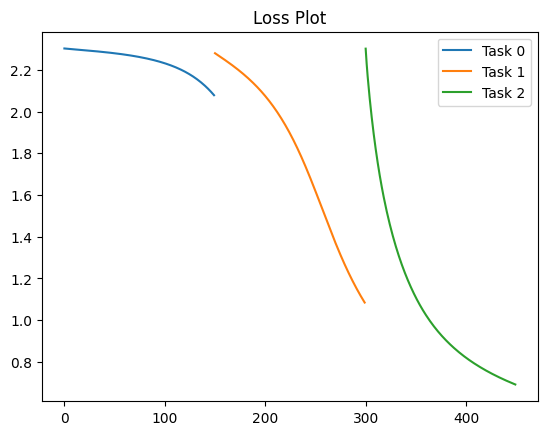

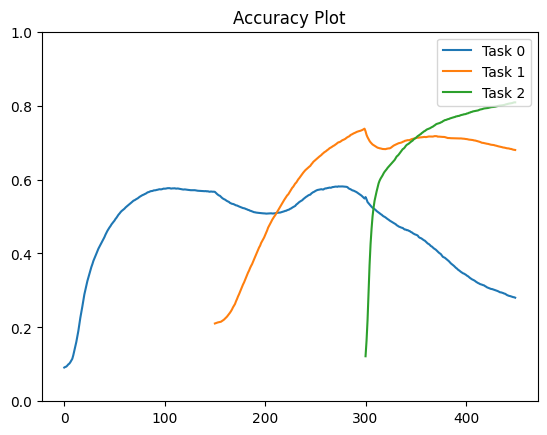

(None, None)

In [ ]:
loss_plot(loss_ewc) , accuracy_plot(acc_ewc)

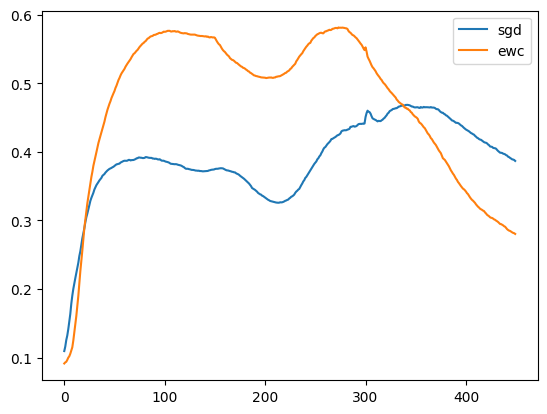

In [ ]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()

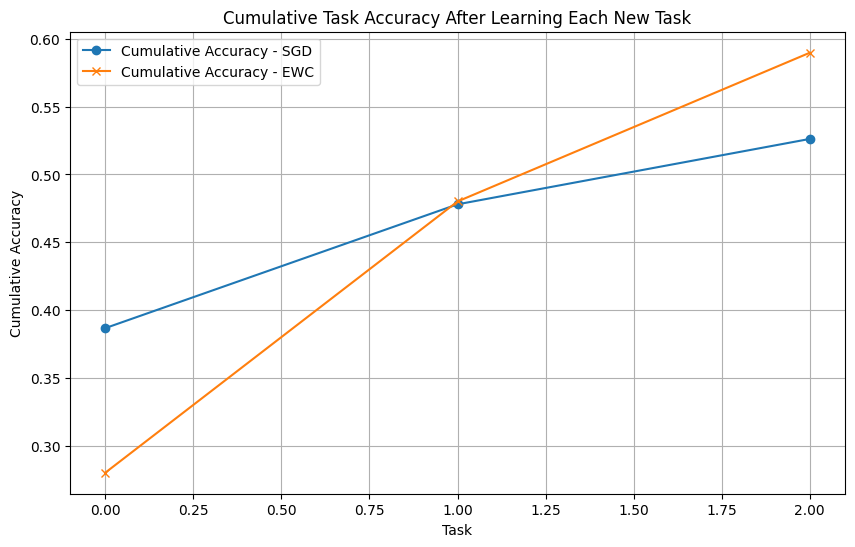

In [ ]:
def cumulative_accuracy_plot(acc_sgd, acc_ewc):
    plt.figure(figsize=(10, 6))

    # Plot cumulative accuracy for SGD
    cum_acc_sgd = [sum(acc_sgd[task][-1] for task in range(i + 1)) / (i + 1) for i in range(num_task)]
    plt.plot(cum_acc_sgd, label="Cumulative Accuracy - SGD", marker='o')

    # Plot cumulative accuracy for EWC
    cum_acc_ewc = [sum(acc_ewc[task][-1] for task in range(i + 1)) / (i + 1) for i in range(num_task)]
    plt.plot(cum_acc_ewc, label="Cumulative Accuracy - EWC", marker='x')

    plt.title("Cumulative Task Accuracy After Learning Each New Task")
    plt.xlabel("Task")
    plt.ylabel("Cumulative Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage example:
cumulative_accuracy_plot(acc, acc_ewc)

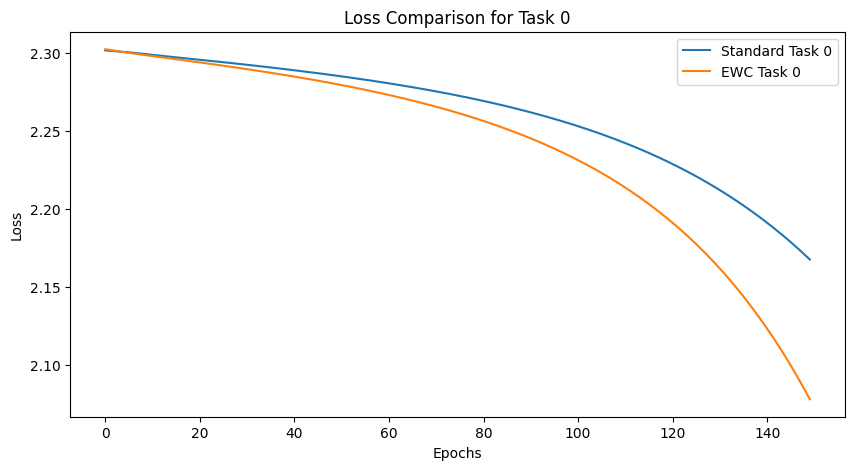

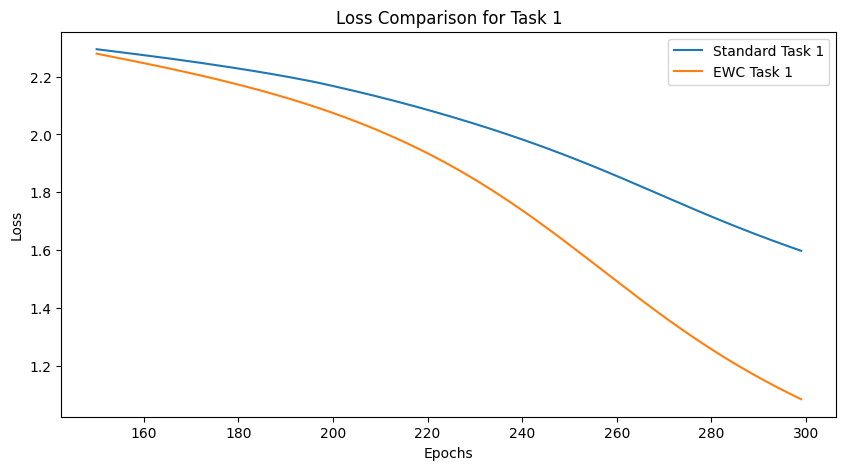

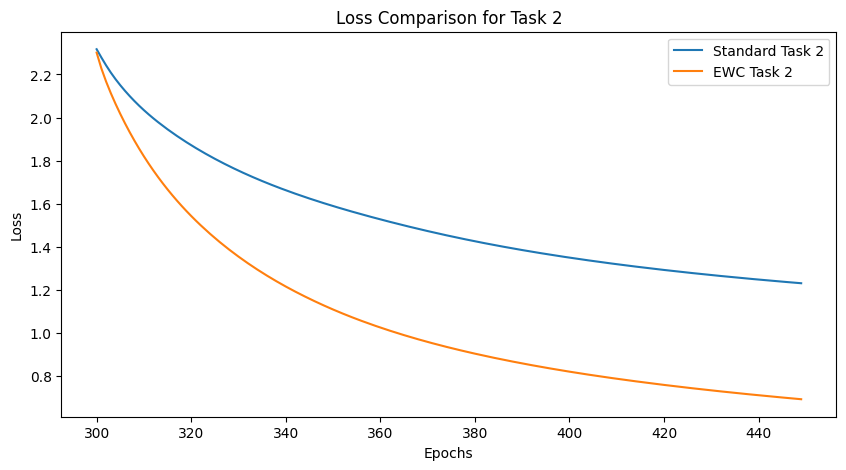

In [ ]:
# Loss Comparison for Each Task
for task in range(num_task):
    plt.figure(figsize=(10, 5))
    plt.plot(range(task * epochs, (task + 1) * epochs), loss[task], label=f'Standard Task {task}')
    plt.plot(range(task * epochs, (task + 1) * epochs), loss_ewc[task], label=f'EWC Task {task}')
    plt.legend()
    plt.title(f'Loss Comparison for Task {task}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

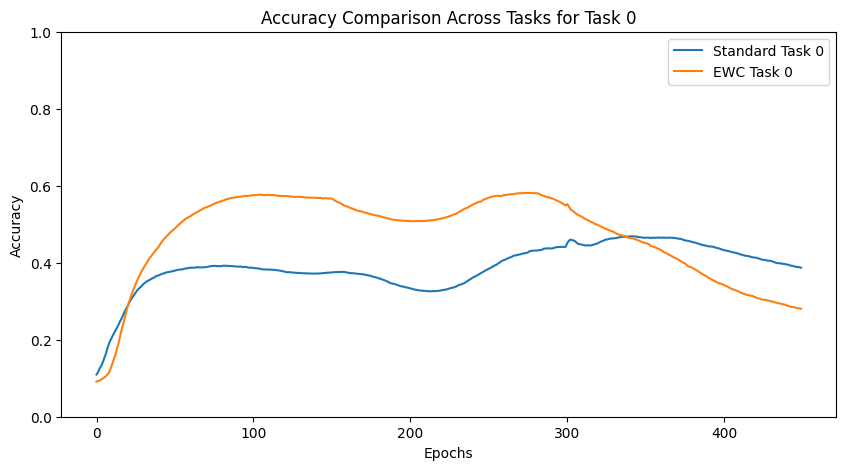

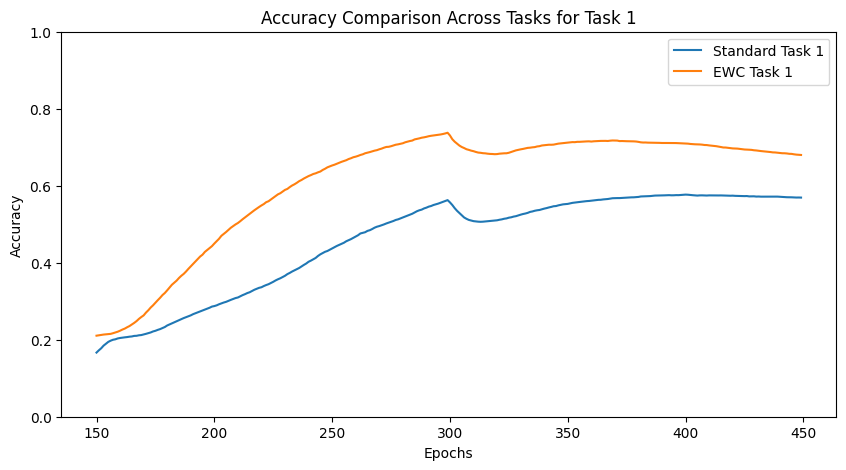

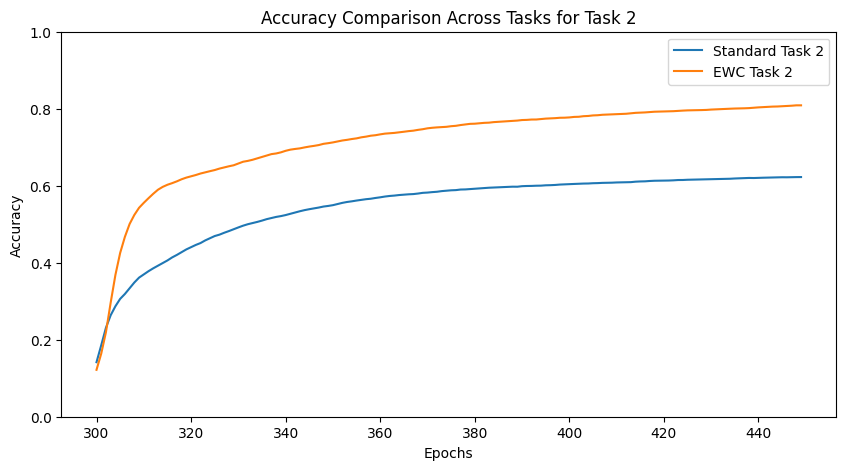

In [ ]:
# Accuracy Comparison Across Tasks
for task in range(num_task):
    plt.figure(figsize=(10, 5))
    plt.plot(range(task * epochs, num_task * epochs), acc[task], label=f'Standard Task {task}')
    plt.plot(range(task * epochs, num_task * epochs), acc_ewc[task], label=f'EWC Task {task}')
    plt.legend()
    plt.title(f'Accuracy Comparison Across Tasks for Task {task}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

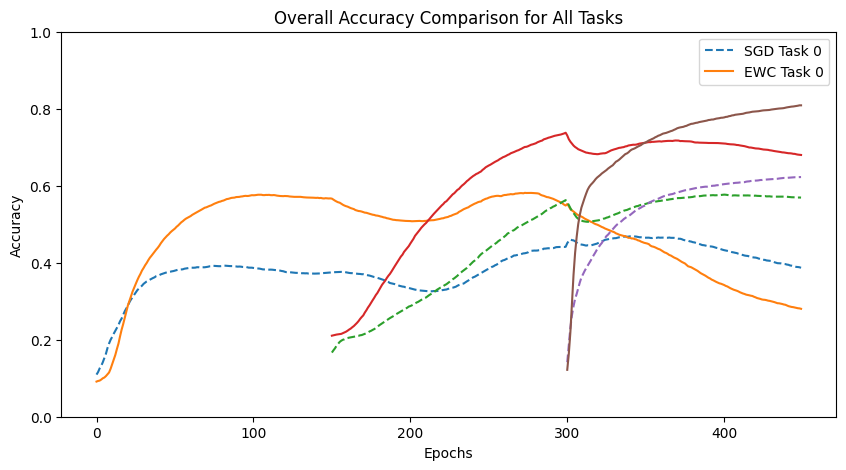

In [ ]:
# Overall Accuracy Comparison for All Tasks
plt.figure(figsize=(10, 5))
plt.plot(range(num_task * epochs), acc[0], label='SGD Task 0', linestyle='dashed')
plt.plot(range(num_task * epochs), acc_ewc[0], label='EWC Task 0', linestyle='solid')
for task in range(1, num_task):
    plt.plot(range(task * epochs, num_task * epochs), acc[task], linestyle='dashed')
    plt.plot(range(task * epochs, num_task * epochs), acc_ewc[task], linestyle='solid')
plt.legend()
plt.title('Overall Accuracy Comparison for All Tasks')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
